In [1]:
#Import

import numpy as np
import matplotlib.pyplot as plt
from multipole_signal import Derivatives
from getdist import plots
from getdist.gaussian_mixtures import GaussianND
import fishermat as fm
import pickle as pk

#Set current directory
import os
import sys

PACKAGE_PARENT = '..'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd())))
sys.path.append(SCRIPT_DIR)
print(SCRIPT_DIR)

#Configuration
large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/Users/danielsb/Documents/GitHub


In [2]:
# Redshift bins

z_bins = np.array([ 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95, 1.05, 1.15, 1.25, 1.35, 1.45, 1.55, 1.65, 1.75, 1.85, 1.95 ])

#z_bins = np.array([ 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95, 1.05, 1.15, 1.25, 1.35, 1.45, 1.55 ])


# Separations

dist = [
    np.arange(20, 164, 4),
    np.arange(32, 164, 4),
]

params_dict0 = {
    'h' : 0.677,
    'As' : 2.05e-9,
    'ns' : 0.965,
    'Ob' : 0.0490, # This is here the density parameter of Baryons
    'Om' : 0.3111, # This is here the density parameter of Cold Dark Matter
}

steps = [1e-3, 1e-1, 1e-4, 1e-2, 1e-2]

# JOINT ANALYSIS. 

### 50x50 vs 30x70 SPLITTINGS.

We run the analysis combining two different population splittings, combining the information as if they were two independent experiments. We include the cross correlations between the observables but assume the parameters of each population are independent. The signal looks like:

$$ \vec{\xi}(z,d) = (\{\xi_l^{\mathrm{LM}}(z,d)\}_{l=0,1,2,4}, \{\xi_l^{\mathrm{NP}}(z,d)\}_{l=0,1,2,4}) $$



## Derivatives (LOAD FROM FILE)

In [3]:
with open('derivatives.pkl', 'rb') as File:
    derivatives_dict = pk.load(File)
    
derivatives_50x50 = derivatives_dict['split_50x50']
derivatives_30x70 = derivatives_dict['split_30x70']

In [4]:
dsignal_dsbias50 = derivatives_50x50['dsignal_dsbias']

dsignal_dgbias50 = derivatives_50x50['dsignal_dgbias']

dsignal_dcosmic50 = derivatives_50x50['dsignal_dcosmic']

dsignal_dnum50 = derivatives_50x50['dsignal_dnumev']

np.shape(dsignal_dsbias50), np.shape(dsignal_dgbias50), np.shape(dsignal_dcosmic50), np.shape(dsignal_dnum50)

((8, 19, 324), (4, 19, 324), (5, 19, 324), (4, 19, 324))

In [5]:
dsignal_dsbias30 = derivatives_30x70['dsignal_dsbias']

dsignal_dgbias30 = derivatives_30x70['dsignal_dgbias']

dsignal_dcosmic30 = derivatives_30x70['dsignal_dcosmic']

dsignal_dnum30 = derivatives_30x70['dsignal_dnumev']

np.shape(dsignal_dsbias30), np.shape(dsignal_dgbias30), np.shape(dsignal_dcosmic30), np.shape(dsignal_dnum30)

((8, 19, 324), (4, 19, 324), (5, 19, 324), (4, 19, 324))

In [6]:
dsignal_dtheta50 = np.concatenate([dsignal_dsbias50, dsignal_dnum50, dsignal_dgbias50, dsignal_dcosmic50])

np.shape(dsignal_dtheta50)

(21, 19, 324)

In [7]:
dsignal_dtheta30 = np.concatenate([dsignal_dsbias30, dsignal_dnum30, dsignal_dgbias30, dsignal_dcosmic30])

np.shape(dsignal_dtheta30)

(21, 19, 324)

REMOVE DIPOLE AND OCTUPOLE

In [8]:
n_sep = len(dist[0])
n_signals = int(len(dsignal_dtheta50[0,0])/n_sep)
ind_to_remove_odd = list(range(3*n_sep,4*n_sep))+list(range(8*n_sep,9*n_sep))

dsignal_dtheta50 = np.delete(dsignal_dtheta50, ind_to_remove_odd, axis=2)
dsignal_dtheta30 = np.delete(dsignal_dtheta30, ind_to_remove_odd, axis=2)

np.shape(dsignal_dtheta50), np.shape(dsignal_dtheta30)


((21, 19, 252), (21, 19, 252))

REMOVE HEXADECAPOLE FROM 50x50 split

In [9]:
n_sep = len(dist[0])
n_signals = int(len(dsignal_dtheta50[0,0])/n_sep)
ind_to_remove_hexa = list(range(7*n_sep,8*n_sep))

print('Number of separations = ', n_sep)
print('Number of signals = ', n_signals)
print('Indices to remove = ', ind_to_remove_hexa)

Number of separations =  36
Number of signals =  7
Indices to remove =  [252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287]


In [10]:
dsignal_dsB50 = np.concatenate([dsignal_dsbias50[:4], np.zeros_like(dsignal_dsbias50[:4])], axis=2)
dsignal_dsB30 = np.concatenate([np.zeros_like(dsignal_dsbias30[:4]), dsignal_dsbias30[:4]], axis=2)

dsignal_dsM = np.concatenate([dsignal_dsbias50[4:], dsignal_dsbias30[4:]], axis=2)
dsignal_dnum = np.concatenate([dsignal_dnum50, dsignal_dnum30], axis=2)
dsignal_dgbias50 = np.concatenate([dsignal_dgbias50, np.zeros_like(dsignal_dgbias50[:4])], axis=2)
dsignal_dgbias30 = np.concatenate([np.zeros_like(dsignal_dgbias30[:4]), dsignal_dgbias30], axis=2)
dsignal_dcosmic = np.concatenate([dsignal_dcosmic50, dsignal_dcosmic30], axis=2)

In [11]:
dsignal_dtheta_multi_ = np.concatenate([dsignal_dsB50, dsignal_dsB30, dsignal_dsM, dsignal_dnum, dsignal_dgbias50, dsignal_dgbias30, dsignal_dcosmic])

ind_to_remove = ind_to_remove_odd + ind_to_remove_hexa + list(range(3*n_sep + 324, 4*n_sep + 324)) + list(range(8*n_sep + 324, 9*n_sep + 324))

dsignal_dtheta_multi = np.delete(dsignal_dtheta_multi_, ind_to_remove, axis=2)


np.shape(dsignal_dtheta_multi_), np.shape(dsignal_dtheta_multi)

((29, 19, 648), (29, 19, 468))

## Covariance Matrix

In [12]:
# Create the PRIORS Cov Matrix for sB, sM, num

errB = [5e-1, 5e-1] 
errF = [5e-1, 5e-1]

num_fit = np.array([7.94599872, -12.03752386, 2.29927261, -15.83887364])

sB_4fit50 = np.array([-0.90110745,  1.82300205, -1.01878441, -0.30342325])
sB_4fit30 = np.array([0.32517601, 0.64417733, 0.16141876, 0.13330362])

sM_4fit = np.array([-0.19376092,  1.07473357, -0.07806244, -0.00558004])

dsB_50 = sB_4fit50 * errB[0] 
dsB_30 = sB_4fit30 * errB[0] 

dsM = sM_4fit * errF[0]

dnum = num_fit * errB[1]

Cov_prior_all = np.diag(np.concatenate([dsB_50**2, dsB_30**2, dsM**2, dnum**2]))

Inv_Cov_prior_all_ = np.linalg.inv(Cov_prior_all)

Inv_Cov_prior_all = np.zeros([len(dsignal_dtheta_multi), len(dsignal_dtheta_multi)])
Inv_Cov_prior_all[:len(Inv_Cov_prior_all_), :len(Inv_Cov_prior_all_)] = Inv_Cov_prior_all_

np.shape(Cov_prior_all), np.shape(Inv_Cov_prior_all)

((16, 16), (29, 29))

In [13]:
Cov_Multipoles_Joint50x30_ = fm.cov_matrix_joint(d=dist[0], z_bins=z_bins, small_off_diagonal=True, splits=[50,30], rtol=1e-4, contributions='CC')

print('\n ... Remove the ODD MULTIPOLES and one HEXADECAPOLE from 50x50 split ... \n')

Cov_Multipoles_Joint50x30 = np.delete(Cov_Multipoles_Joint50x30_, ind_to_remove, axis=1)
Cov_Multipoles_Joint50x30 = np.delete(Cov_Multipoles_Joint50x30, ind_to_remove, axis=2)

np.shape(Cov_Multipoles_Joint50x30_), np.shape(Cov_Multipoles_Joint50x30)


 ... Loading Covariance Matrices (Joint-splittings Analysis) [CC] [MONOBB, MONOBF, MONOFF, DIPBF, QUADBB, QUADBF, QUADFF, HEXAT, OCTBF] ... 




 ... Remove the ODD MULTIPOLES and one HEXADECAPOLE from 50x50 split ... 



((19, 648, 648), (19, 468, 468))

In [14]:
# Check if Cov Matrices are symmetric:

for n, z in enumerate(z_bins):
    print(n, np.allclose(Cov_Multipoles_Joint50x30_[n], Cov_Multipoles_Joint50x30_[n].T, rtol = 1e-15), np.allclose(Cov_Multipoles_Joint50x30[n], Cov_Multipoles_Joint50x30[n].T, rtol = 1e-15))

0 True True
1 True True
2 True True
3 True True
4 True True
5 True True
6 True True
7 True True
8 True True
9 True True
10 True True
11 True True
12 True True
13 True True
14 True True
15 True True
16 True True
17 True True
18 True True


In [15]:
# Load the Covariance Matrix of the multipoles

Inv_Cov_Multipoles_Joint50x30_ = np.linalg.pinv(Cov_Multipoles_Joint50x30)

# Symmetrize the matrix

Inv_Cov_Multipoles_Joint50x30 = [0.5 * (Inv_Cov_Multipoles_Joint50x30_[i] + Inv_Cov_Multipoles_Joint50x30_[i].T) for i in range(len(z_bins))]

In [16]:
# Check if Inverse Cov Matrices are symmetric:

for n, z in enumerate(z_bins):
    print(n, np.allclose(Inv_Cov_Multipoles_Joint50x30_[n], Inv_Cov_Multipoles_Joint50x30_[n].T, rtol = 1e-1), np.allclose(Inv_Cov_Multipoles_Joint50x30[n], Inv_Cov_Multipoles_Joint50x30[n].T, rtol = 1e-3))

0 True True
1 True True
2 True True
3 True True
4 True True
5 True True
6 True True
7 True True
8 True True
9 True True
10 True True
11 True True
12 True True
13 True True
14 True True
15 True True
16 True True
17 True True
18 True True


In [17]:
# Build the Fisher Matrix

Fisher_Matrix_Joint50x30_ = fm.fisher_matrix(d_signal = dsignal_dtheta_multi, inv_cov = Inv_Cov_Multipoles_Joint50x30_, z_bins = z_bins)
Fisher_Matrix_Joint50x30 = Fisher_Matrix_Joint50x30_ + Inv_Cov_prior_all

np.shape(Fisher_Matrix_Joint50x30)


 ... Computing the Fisher Matrix ... 

Signal & Cov must be given as functions (z,d) and (z,d,d') respectively. 


 ... Success! ... 



(29, 29)

In [18]:
print('\n'.join(['\t'.join([str(cell) for cell in row]) for row in Fisher_Matrix_Joint50x30[:8,:8]]))

4.92614091333159	0.0	0.0	0.0	0.0	0.0	0.0	0.0
0.0	1.2036096949339048	0.0	0.0	0.0	0.0	0.0	0.0
0.0	0.0	3.853855353417002	0.0	0.0	0.0	0.0	0.0
0.0	0.0	0.0	43.44724867655685	0.0	0.0	0.0	0.0
0.0	0.0	0.0	0.0	37.82883752123923	0.0	0.0	0.0
0.0	0.0	0.0	0.0	0.0	9.639380358545878	0.0	0.0
0.0	0.0	0.0	0.0	0.0	0.0	153.5154103270564	0.0
0.0	0.0	0.0	0.0	0.0	0.0	0.0	225.10031603189591


In [19]:
print('\n'.join(['\t'.join([str(cell) for cell in row]) for row in Fisher_Matrix_Joint50x30[8:16,8:16]]))

106.5436609609975	0.0	0.0	0.0	0.0	0.0	0.0	0.0
0.0	3.4630468121011844	0.0	0.0	0.0	0.0	0.0	0.0
0.0	0.0	656.4108446886339	0.0	0.0	0.0	0.0	0.0
0.0	0.0	0.0	128465.16144918442	0.0	0.0	0.0	0.0
0.0	0.0	0.0	0.0	0.06335239092003143	0.0	0.0	0.0
0.0	0.0	0.0	0.0	0.0	0.02760486765761777	0.0	0.0
0.0	0.0	0.0	0.0	0.0	0.0	0.7566221650091618	0.0
0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.01594451829440951


In [20]:
print('\n'.join(['\t'.join([str(cell) for cell in row]) for row in Fisher_Matrix_Joint50x30[16:,16:]]))

40200397.177189775	11496092.39074273	-26822340.817363836	-7561554.9893807415	-12178622.794307422	-3250864.0828298694	-6860591.72150068	-2354007.593911155	1527867.6395612452	816034.9785541041	-774800.7775420331	-4497597.240563945	-2954332.48204138
11496092.390742727	4207430.751464681	-7561554.989380742	-2606531.286380943	-3250864.08282987	-1145698.6742734313	-2354007.5939111556	-1009991.9114584718	749301.037634836	365322.69937882957	-272320.85393914924	-2322375.800654699	-571636.2989726163
-26822340.817354232	-7561554.989379332	55870612.02355833	16238836.435566159	-1474556.6022553104	-606120.3778722668	-13396836.980462309	-3514252.365988596	938348.3755325259	-91035.37559519455	1343951.3062371772	-4807043.419848141	8886310.89483506
-7561554.989379338	-2606531.2863807	16238836.435566152	6016146.3322552685	-606120.3778722667	-305877.7549011128	-3514252.3659885963	-1214832.7215122338	250246.51018380275	-46952.12270292796	424922.84231691755	-1373936.167931729	2322624.4084728444
-12178622.794

In [21]:
print('\n'.join(['\t'.join([str(cell) for cell in row]) for row in Fisher_Matrix_Joint50x30[16:24,16:24]]))

40200397.177189775	11496092.39074273	-26822340.817363836	-7561554.9893807415	-12178622.794307422	-3250864.0828298694	-6860591.72150068	-2354007.593911155
11496092.390742727	4207430.751464681	-7561554.989380742	-2606531.286380943	-3250864.08282987	-1145698.6742734313	-2354007.5939111556	-1009991.9114584718
-26822340.817354232	-7561554.989379332	55870612.02355833	16238836.435566159	-1474556.6022553104	-606120.3778722668	-13396836.980462309	-3514252.365988596
-7561554.989379338	-2606531.2863807	16238836.435566152	6016146.3322552685	-606120.3778722667	-305877.7549011128	-3514252.3659885963	-1214832.7215122338
-12178622.794345746	-3250864.0828308137	-1474556.602257222	-606120.3778750729	41427036.72147977	10454321.922662953	-45499124.66845071	-11348707.61216298
-3250864.0828308137	-1145698.6742730998	-606120.3778750732	-305877.75490174955	10454321.922662944	3441882.4875366013	-11348707.61216299	-3518507.8796147336
-6860591.721468543	-2354007.5939130248	-13396836.98043763	-3514252.365981425	-

In [22]:
print('\n'.join(['\t'.join([str(cell) for cell in row]) for row in Fisher_Matrix_Joint50x30[24:,24:]]))

7538169.72267907	2430966.931941119	872868.8166562105	-28331227.54671311	9976728.379868105
2430966.9319411116	834337.6819797552	192908.25765276013	-8767895.256038873	3096324.479891649
872868.8166561602	192908.25765273033	402390.17329543084	-3368413.5611862172	2244703.175721001
-28331227.546713192	-8767895.256038949	-3368413.5611864	115612215.508944	-36188497.783641875
9976728.379867377	3096324.479891361	2244703.175721102	-36188497.78363921	20914135.1046256


In [23]:
print(np.allclose(Fisher_Matrix_Joint50x30, Fisher_Matrix_Joint50x30.T, rtol=1e-6))

True


In [24]:
print(np.allclose(Fisher_Matrix_Joint50x30[:-5,:-5], Fisher_Matrix_Joint50x30[:-5,:-5].T, rtol=1e-6))

True


In [25]:
np.linalg.det(Fisher_Matrix_Joint50x30)

6.77731804618011e+97

In [26]:
Fisher_Matrix_Joint50x30__ = 0.5 * (Fisher_Matrix_Joint50x30 + Fisher_Matrix_Joint50x30.T)

In [27]:
print('\n'.join(['\t'.join([str(cell) for cell in row]) for row in Fisher_Matrix_Joint50x30__[16:,16:]]))

40200397.177189775	11496092.390742728	-26822340.817359034	-7561554.989380039	-12178622.794326585	-3250864.0828303415	-6860591.721484611	-2354007.5939120892	1527867.639561249	816034.9785541083	-774800.7775420116	-4497597.240563195	-2954332.482039797
11496092.390742728	4207430.751464681	-7561554.989380037	-2606531.2863808214	-3250864.0828303415	-1145698.6742732655	-2354007.59391209	-1009991.9114589742	749301.0376348884	365322.6993788518	-272320.85393914435	-2322375.800654562	-571636.2989725661
-26822340.817359034	-7561554.989380037	55870612.02355833	16238836.435566155	-1474556.6022562662	-606120.3778736701	-13396836.98044997	-3514252.365985009	938348.3755323798	-91035.37559532549	1343951.3062373968	-4807043.419848719	8886310.894836854
-7561554.989380039	-2606531.2863808214	16238836.435566155	6016146.3322552685	-606120.3778736698	-305877.75490143115	-3514252.3659850108	-1214832.7215115149	250246.51018373753	-46952.12270296065	424922.84231693525	-1373936.1679318657	2322624.4084731457
-1217

In [28]:
np.linalg.det(Fisher_Matrix_Joint50x30[:-5, :-5])

1.7150311079481172e+69

In [29]:
np.linalg.det(Fisher_Matrix_Joint50x30__[:-5, :-5])

1.7150311079481172e+69

In [30]:
np.linalg.det(Fisher_Matrix_Joint50x30__)

6.777318046180303e+97

In [31]:
np.linalg.det(Fisher_Matrix_Joint50x30)

6.77731804618011e+97

## Constraints

In [32]:
#Absolute Errors

Sigma_Matrix_Joint50x30 = np.linalg.inv(Fisher_Matrix_Joint50x30)

Abs_Errors_all_Joint = np.sqrt(np.diag(Sigma_Matrix_Joint50x30))

# Fiducial values

sB_fit = np.concatenate([sB_4fit50, sB_4fit30]) 
gbias_fit = np.concatenate([np.array([0.554, 0.783]), np.array([0.554, 0.783]), np.array([0.554, 0.783]), np.array([0.554, 0.783])])
cosmic_fid = np.fromiter(params_dict0.values(), dtype=float)
cosmic_fid[1] = np.log(10**10 * cosmic_fid[1])

params_fid = np.concatenate([sB_fit, sM_4fit, num_fit, gbias_fit, cosmic_fid])

# Relative errors

Rel_Errors_all_Joint = np.abs(Abs_Errors_all_Joint/params_fid)

par_errors_all_Joint = Rel_Errors_all_Joint * 100

print()
print('------------ Relative errors * 100 ------------' )
print()
print('sB_50 = ', par_errors_all_Joint[0:int(len(sB_fit)/2)])
print()
print('sB_30 = ', par_errors_all_Joint[int(len(sB_fit)/2):len(sB_fit)])
print()
print('s_model = ', par_errors_all_Joint[len(sB_fit):len(sB_fit)+len(sM_4fit)])
print()
print('number = ', par_errors_all_Joint[(len(sB_fit)+len(sM_4fit)):(len(sB_fit)+len(sM_4fit)+len(num_fit))])
print()
print('gbias_50 = ', par_errors_all_Joint[((len(sB_fit)+len(sM_4fit)+len(num_fit))):((len(sB_fit)+len(sM_4fit)+len(num_fit))+int(len(gbias_fit)/2))])
print()
print('gbias_30 = ', par_errors_all_Joint[(len(sB_fit)+len(sM_4fit)+len(num_fit)+int(len(gbias_fit)/2)):((len(sB_fit)+len(sM_4fit)+len(num_fit))+int(len(gbias_fit)))])
print()
print('cosmic = ', par_errors_all_Joint[((len(sB_fit)+len(sM_4fit)+len(num_fit))+len(gbias_fit)):((len(sB_fit)+len(sM_4fit)+len(num_fit))+len(gbias_fit) + len(cosmic_fid))])
print()


------------ Relative errors * 100 ------------

sB_50 =  [50. 50. 50. 50.]

sB_30 =  [50. 50. 50. 50.]

s_model =  [50. 50. 50. 50.]

number =  [50. 50. 50. 50.]

gbias_50 =  [0.18854866 0.3076305  0.1640094  0.23206152]

gbias_30 =  [0.21123513 0.35370801 0.16040133 0.22650338]

cosmic =  [0.99738791 0.53901455 0.79079187 1.1410406  0.36378508]



In [33]:
np.linalg.det(Fisher_Matrix_Joint50x30), np.linalg.det(Sigma_Matrix_Joint50x30)

(6.77731804618011e+97, 1.4755099188000218e-98)

In [34]:
def isPSD(A, tol=1e-4):
    E = np.linalg.eigvals(A)
    return E, np.all(E > -tol)

# Example usage:
# Your matrix
A = np.array([[1, 2], [2, 4]])
# Check if A is positive semi-definite
print(isPSD(A))

(array([0., 5.]), True)


In [35]:
print(isPSD(Fisher_Matrix_Joint50x30[:-5,:-5], tol=1e-10))

(array([1.34299440e+08, 8.08793162e+07, 3.66321767e+07, 2.80027069e+06,
       9.14960062e+04, 8.42472077e+05, 1.76245363e+06, 1.37970301e+06,
       4.92614091e+00, 1.20360969e+00, 3.85385535e+00, 4.34472487e+01,
       3.78288375e+01, 9.63938036e+00, 1.53515410e+02, 2.25100316e+02,
       1.06543661e+02, 3.46304681e+00, 6.56410845e+02, 1.28465161e+05,
       6.33523909e-02, 2.76048677e-02, 7.56622165e-01, 1.59445183e-02]), True)


In [36]:
print(isPSD(Sigma_Matrix_Joint50x30, tol=1e-10))

(array([3.62000337e-04, 1.74342594e-05, 8.90256654e-06, 2.71620418e-06,
       1.20372137e-06, 9.75227883e-07, 6.34512903e-07, 4.05269363e-07,
       1.46098177e-07, 2.72234785e-08, 1.22189986e-08, 7.03927837e-09,
       7.68812019e-09, 2.02998659e-01, 8.30834119e-01, 2.59480419e-01,
       2.30164172e-02, 2.64348594e-02, 1.03741108e-01, 6.51400402e-03,
       4.44246378e-03, 9.38582353e-03, 2.88763062e-01, 1.52343613e-03,
       7.78421160e-06, 1.57847239e+01, 3.62254952e+01, 1.32166363e+00,
       6.27174795e+01]), True)


In [37]:
# Perform Singular Value Decomposition

U, s, Vh = np.linalg.svd(Fisher_Matrix_Joint50x30)

# s contains the singular values of A
print("Singular values of A:", s)

# Calculate the condition number
condition_number = s[0] / s[-1]
print("Condition number of A:", condition_number)

Singular values of A: [1.42060016e+08 1.30070807e+08 8.18397674e+07 3.67329987e+07
 6.84471239e+06 2.46749469e+06 1.57601208e+06 1.02540136e+06
 8.30757040e+05 3.68160835e+05 1.28465161e+05 1.12327158e+05
 5.73583298e+04 2.76242837e+03 6.56410845e+02 2.25100316e+02
 1.53515410e+02 1.06543661e+02 4.34472487e+01 3.78288375e+01
 9.63938036e+00 4.92614091e+00 3.85385535e+00 3.46304681e+00
 1.20360969e+00 7.56622165e-01 6.33523909e-02 2.76048677e-02
 1.59445183e-02]
Condition number of A: 8909646161.610798


In [38]:
# Create Σ+ (the pseudo-inverse of the diagonal matrix Σ)
S_plus = np.zeros((Fisher_Matrix_Joint50x30.shape[0], Fisher_Matrix_Joint50x30.shape[1])).T
S_plus[:s.shape[0], :s.shape[0]] = np.linalg.inv(np.diag(s))

# Compute the pseudo-inverse of A
A_plus = Vh.T @ S_plus @ U.T

# Verify by multiplying with the original matrix A
identity_matrix = Fisher_Matrix_Joint50x30 @ A_plus

In [39]:
np.allclose(A_plus, Sigma_Matrix_Joint50x30, rtol=1e-20)

True

In [40]:
np.linalg.det(A_plus), np.linalg.det(Sigma_Matrix_Joint50x30)

(1.4755099187997704e-98, 1.4755099188000218e-98)

In [41]:
np.prod(s), np.linalg.det(Fisher_Matrix_Joint50x30)

(6.7773180461805084e+97, 6.77731804618011e+97)

# SINGLE SPLIT 

### $m = 2 \,\rightarrow\,$ $50\%$ Brigth - $50\%$ Faint

In [42]:
len(dsignal_dgbias50[1,1])/2

324.0

In [43]:
dsignal_dtheta_fit_all50 = np.concatenate([dsignal_dsbias50, dsignal_dnum50, dsignal_dgbias50[:,:,:324], dsignal_dcosmic50])

np.shape(dsignal_dtheta_fit_all50)

(21, 19, 324)

In [44]:
dsignal_dtheta_fit_all50 = np.delete(dsignal_dtheta_fit_all50, ind_to_remove_odd, axis=2)

np.shape(dsignal_dtheta_fit_all50)

(21, 19, 252)

In [45]:
# Create the Cov Matrix for sB, sF, num

Cov_priors_50 = np.diag(np.concatenate([dsB_50**2, dsM**2, dnum**2]))

Inv_Cov_prior_50_ = np.linalg.inv(Cov_priors_50)

Inv_Cov_prior_50 = np.zeros([len(dsignal_dtheta_fit_all50), len(dsignal_dtheta_fit_all50)])
Inv_Cov_prior_50[:len(Inv_Cov_prior_50_), :len(Inv_Cov_prior_50_)] = Inv_Cov_prior_50_

np.shape(Cov_priors_50)

(12, 12)

In [46]:
Cov_Multipoles_50 = fm.cov_matrix_survey(d = dist[0], z_bins = z_bins, split=[50, 50], small_off_diagonal = True, rtol=1e-10)

print('\n ... Remove the ODD MULTIPOLES from 50x50 split ... \n')

Cov_Even_Multipoles_50 = np.delete(Cov_Multipoles_50, ind_to_remove_odd, axis=1)
Cov_Even_Multipoles_50 = np.delete(Cov_Even_Multipoles_50, ind_to_remove_odd, axis=2)

np.shape(Cov_Even_Multipoles_50)


 ... Loading Covariance Matrices [MONOBB, MONOBF, MONOFF, DIPBF, QUADBB, QUADBF, QUADFF, HEXAT, OCTBF] ... 


 ... Success! ... 


 ... Remove the ODD MULTIPOLES from 50x50 split ... 



(19, 252, 252)

In [47]:
# Fisher Matrix + prior

Inv_Cov_Multipoles_50 = np.array([np.linalg.inv(Cov_Even_Multipoles_50[i]) for i,_ in enumerate(z_bins)])

Fisher_Matrix_50_ = fm.fisher_matrix(d_signal = dsignal_dtheta_fit_all50, inv_cov = Inv_Cov_Multipoles_50, z_bins = z_bins)

Fisher_Matrix_50 = Fisher_Matrix_50_ + Inv_Cov_prior_50

np.shape(Fisher_Matrix_50)


 ... Computing the Fisher Matrix ... 

Signal & Cov must be given as functions (z,d) and (z,d,d') respectively. 


 ... Success! ... 



(21, 21)

In [48]:
print(np.allclose(Fisher_Matrix_50, Fisher_Matrix_50.T, rtol=1e-11))

True


In [49]:
np.linalg.det(Fisher_Matrix_50)

1.8040523879569553e+62

In [50]:
Sigma_Matrix_50 = np.linalg.inv(Fisher_Matrix_50)

#Absolute Errors

Abs_Errors_all_50 = np.sqrt(np.diag(Sigma_Matrix_50))

# Fiducial values

sbias_fit_50 = np.concatenate([sB_4fit50, sM_4fit])
gbias_fit_50 = np.concatenate([np.array([0.554, 0.783]), np.array([0.554, 0.783])])
cosmic_fid = np.fromiter(params_dict0.values(), dtype=float)
cosmic_fid[1] = np.log(10**10 * cosmic_fid[1])

params_fid_50 = np.concatenate([sbias_fit_50, num_fit, gbias_fit_50, cosmic_fid])

# Relative errors

Rel_Errors_all_50 = np.abs(Abs_Errors_all_50/params_fid_50)

par_errors_all_50 = Rel_Errors_all_50 * 100

print()
print('------------ Relative errors * 100 ------------' )
print()
print('sB = ', par_errors_all_50[0:int(len(sbias_fit_50)/2)])
print()
print('smodel = ', par_errors_all_50[int(len(sbias_fit_50)/2):len(sbias_fit_50)])
print()
print('number = ', par_errors_all_50[len(sbias_fit_50):(len(sbias_fit_50) + len(num_fit))])
print()
print('gbias = ', par_errors_all_50[(len(sbias_fit_50) + len(num_fit)):(len(sbias_fit_50) + len(num_fit) + len(gbias_fit_50))])
print()
print('cosmic = ', par_errors_all_50[(len(sbias_fit_50) + len(num_fit)+len(gbias_fit_50)):])


------------ Relative errors * 100 ------------

sB =  [50. 50. 50. 50.]

smodel =  [50. 50. 50. 50.]

number =  [50. 50. 50. 50.]

gbias =  [0.25920497 0.38901687 0.23719103 0.30796154]

cosmic =  [1.32271453 0.74783458 1.11559857 1.39650628 0.55671791]


In [51]:
print(np.allclose(Sigma_Matrix_50, Sigma_Matrix_50.T, rtol=1e-20))

True


In [52]:
np.linalg.det(Sigma_Matrix_50)

5.543076280243032e-63

In [53]:
# Perform Singular Value Decomposition

U, s, Vh = np.linalg.svd(Fisher_Matrix_50)

# s contains the singular values of A
print("Singular values of A:", s)

# Calculate the condition number
condition_number = s[0] / s[-1]
print("Condition number of A:", condition_number)

Singular values of A: [9.78073986e+07 7.53580706e+07 5.28445140e+06 1.89388489e+06
 1.14706479e+06 3.23722468e+05 1.28465161e+05 8.96152270e+04
 7.89560174e+04 1.42833446e+03 6.56410845e+02 1.06543661e+02
 4.34472487e+01 4.92614091e+00 3.85385535e+00 3.46304681e+00
 1.20360969e+00 7.56622165e-01 6.33523909e-02 2.76048677e-02
 1.59445183e-02]
Condition number of A: 6134233520.960909


In [54]:
# Create Σ+ (the pseudo-inverse of the diagonal matrix Σ)
S_plus = np.zeros((Fisher_Matrix_50.shape[0], Fisher_Matrix_50.shape[1])).T
S_plus[:s.shape[0], :s.shape[0]] = np.linalg.inv(np.diag(s))

# Compute the pseudo-inverse of A
A_plus = Vh.T @ S_plus @ U.T

# Verify by multiplying with the original matrix A
identity_matrix = Fisher_Matrix_50 @ A_plus

In [55]:
np.allclose(A_plus, Sigma_Matrix_50, rtol=1e-20)

True

# SINGLE SPLIT 

### $m = 10/3 \,\rightarrow\,$ $30\%$ Brigth - $70\%$ Faint

In [56]:
len(dsignal_dgbias30[1,1])/2

324.0

In [57]:
dsignal_dtheta_fit_all30 = np.concatenate([dsignal_dsbias30, dsignal_dnum30, dsignal_dgbias30[:,:,324:], dsignal_dcosmic30])

np.shape(dsignal_dtheta_fit_all30)

(21, 19, 324)

In [58]:
dsignal_dtheta_fit_all30 = np.delete(dsignal_dtheta_fit_all30, ind_to_remove_odd, axis=2)

np.shape(dsignal_dtheta_fit_all30)

(21, 19, 252)

In [59]:
# Create the Cov Matrix for sB, sF, num

Cov_priors_30 = np.diag(np.concatenate([dsB_30**2, dsM**2, dnum**2]))

Inv_Cov_prior_30_ = np.linalg.inv(Cov_priors_30)

Inv_Cov_prior_30 = np.zeros([len(dsignal_dtheta_fit_all30), len(dsignal_dtheta_fit_all30)])
Inv_Cov_prior_30[:len(Inv_Cov_prior_30_), :len(Inv_Cov_prior_30_)] = Inv_Cov_prior_30_

np.shape(Cov_priors_30)

(12, 12)

In [60]:
Cov_Multipoles_30 = fm.cov_matrix_survey(d = dist[0], z_bins = z_bins, split=[30, 70], small_off_diagonal = True, rtol=1e-10)

print('\n ... Remove the ODD MULTIPOLES from 30x70 split ... \n')

Cov_Even_Multipoles_30 = np.delete(Cov_Multipoles_30, ind_to_remove_odd, axis=1)
Cov_Even_Multipoles_30 = np.delete(Cov_Even_Multipoles_30, ind_to_remove_odd, axis=2)

np.shape(Cov_Even_Multipoles_30)


 ... Loading Covariance Matrices [MONOBB, MONOBF, MONOFF, DIPBF, QUADBB, QUADBF, QUADFF, HEXAT, OCTBF] ... 




 ... Success! ... 


 ... Remove the ODD MULTIPOLES from 30x70 split ... 



(19, 252, 252)

In [61]:
# Fisher Matrix + prior

Inv_Cov_Multipoles_30 = np.array([np.linalg.inv(Cov_Even_Multipoles_30[i]) for i,_ in enumerate(z_bins)])

Fisher_Matrix_30_ = fm.fisher_matrix(d_signal = dsignal_dtheta_fit_all30, inv_cov = Inv_Cov_Multipoles_30, z_bins = z_bins)

Fisher_Matrix_30 = Fisher_Matrix_30_ + Inv_Cov_prior_30

np.shape(Fisher_Matrix_30)


 ... Computing the Fisher Matrix ... 

Signal & Cov must be given as functions (z,d) and (z,d,d') respectively. 


 ... Success! ... 



(21, 21)

In [62]:
np.allclose(Fisher_Matrix_30, Fisher_Matrix_30.T, rtol=1e-9)

True

In [63]:
np.linalg.det(Fisher_Matrix_30)

5.320080130120159e+66

In [64]:
Sigma_Matrix_30 = np.linalg.inv(Fisher_Matrix_30)

#Absolute Errors

Abs_Errors_all_30 = np.sqrt(np.diag(Sigma_Matrix_30))

# Fiducial values

sbias_fit_30 = np.concatenate([sB_4fit30, sM_4fit])
gbias_fit_30 = np.concatenate([np.array([0.554, 0.783]), np.array([0.554, 0.783])])
cosmic_fid = np.fromiter(params_dict0.values(), dtype=float)
cosmic_fid[1] = np.log(10**10 * cosmic_fid[1])

params_fid_30 = np.concatenate([sbias_fit_30, num_fit, gbias_fit_30, cosmic_fid])

# Relative errors

Rel_Errors_all_30 = np.abs(Abs_Errors_all_30/params_fid_30)

par_errors_all_30 = Rel_Errors_all_30 * 100

print()
print('------------ Relative errors * 100 ------------' )
print()
print('sB = ', par_errors_all_30[0:int(len(sbias_fit_30)/2)])
print()
print('smodel = ', par_errors_all_30[int(len(sbias_fit_30)/2):len(sbias_fit_30)])
print()
print('number = ', par_errors_all_30[len(sbias_fit_30):(len(sbias_fit_30) + len(num_fit))])
print()
print('gbias = ', par_errors_all_30[(len(sbias_fit_30) + len(num_fit)):(len(sbias_fit_30) + len(num_fit) + len(gbias_fit_30))])
print()
print('cosmic = ', par_errors_all_30[(len(sbias_fit_30) + len(num_fit)+len(gbias_fit_30)):])


------------ Relative errors * 100 ------------

sB =  [50. 50. 50. 50.]

smodel =  [50. 50. 50. 50.]

number =  [50. 50. 50. 50.]

gbias =  [0.28556522 0.41027255 0.21295904 0.26899839]

cosmic =  [1.13245448 0.61867637 0.92074202 1.27812952 0.42146914]


In [65]:
np.allclose(Sigma_Matrix_30, Sigma_Matrix_30.T, rtol=1e-20)

True

In [66]:
np.linalg.det(Sigma_Matrix_30)

1.8796709364178304e-67

In [67]:
# Perform Singular Value Decomposition

U, s, Vh = np.linalg.svd(Sigma_Matrix_30)

# s contains the singular values of A
print("Singular values of A:", s)

# Calculate the condition number
condition_number = s[0] / s[-1]
print("(Log)-Condition number of A:", np.log10(condition_number))

Singular values of A: [6.27174795e+01 3.62254952e+01 1.57847239e+01 1.32166363e+00
 2.88763062e-01 1.03741108e-01 2.64348594e-02 9.38582353e-03
 6.51400402e-03 4.44246378e-03 1.52343613e-03 4.76246105e-04
 1.51227653e-05 1.08522219e-05 7.78421160e-06 3.88093515e-06
 9.92247486e-07 3.87305245e-07 1.78992967e-07 9.61168838e-09
 7.75249549e-09]
(Log)-Condition number of A: 9.907947074598423


In [68]:
# Create Σ+ (the pseudo-inverse of the diagonal matrix Σ)
S_plus = np.zeros((Sigma_Matrix_30.shape[0], Sigma_Matrix_30.shape[1])).T
S_plus[:s.shape[0], :s.shape[0]] = np.linalg.inv(np.diag(s))

# Compute the pseudo-inverse of A
A_plus = Vh.T @ S_plus @ U.T

# Verify by multiplying with the original matrix A
identity_matrix = Sigma_Matrix_30 @ A_plus

In [69]:
determinant = np.prod(s)

print(f'The determinant of the Sigma Matrix is: {determinant}')

The determinant of the Sigma Matrix is: 1.8796709364180465e-67


In [70]:
np.allclose(A_plus, Fisher_Matrix_30, rtol=1e-7)

True

Comparison with result of combined analysis

In [71]:
print()
print('------------ Relative errors * 100 ------------' )
print()
print('sB_50 = ', par_errors_all_Joint[0:int(len(sB_fit)/2)])
print()
print('sB_30 = ', par_errors_all_Joint[int(len(sB_fit)/2):len(sB_fit)])
print()
print('s_model = ', par_errors_all_Joint[len(sB_fit):len(sB_fit)+len(sM_4fit)])
print()
print('number = ', par_errors_all_Joint[(len(sB_fit)+len(sM_4fit)):(len(sB_fit)+len(sM_4fit)+len(num_fit))])
print()
print('gbias_50 = ', par_errors_all_Joint[((len(sB_fit)+len(sM_4fit)+len(num_fit))):((len(sB_fit)+len(sM_4fit)+len(num_fit))+int(len(gbias_fit)/2))])
print()
print('gbias_30 = ', par_errors_all_Joint[(len(sB_fit)+len(sM_4fit)+len(num_fit)+int(len(gbias_fit)/2)):((len(sB_fit)+len(sM_4fit)+len(num_fit))+int(len(gbias_fit)))])
print()
print('cosmic = ', par_errors_all_Joint[((len(sB_fit)+len(sM_4fit)+len(num_fit))+len(gbias_fit)):((len(sB_fit)+len(sM_4fit)+len(num_fit))+len(gbias_fit) + len(cosmic_fid))])
print()


------------ Relative errors * 100 ------------

sB_50 =  [50. 50. 50. 50.]

sB_30 =  [50. 50. 50. 50.]

s_model =  [50. 50. 50. 50.]

number =  [50. 50. 50. 50.]

gbias_50 =  [0.18854866 0.3076305  0.1640094  0.23206152]

gbias_30 =  [0.21123513 0.35370801 0.16040133 0.22650338]

cosmic =  [0.99738791 0.53901455 0.79079187 1.1410406  0.36378508]



# Numerical comparison

In [72]:
cosmic50x50 = par_errors_all_50[(len(sbias_fit_50) + len(num_fit)+len(gbias_fit_50)):]
cosmic30x70 = par_errors_all_30[(len(sbias_fit_30) + len(num_fit) + len(gbias_fit_30)):]

cosmicjoint = par_errors_all_Joint[((len(sB_fit)+len(sM_4fit)+len(num_fit))+len(gbias_fit)):((len(sB_fit)+len(sM_4fit)+len(num_fit))+len(gbias_fit) + len(cosmic_fid))]

In [73]:
sm50x50 = par_errors_all_50[int(len(sbias_fit_50)/2):len(sbias_fit_50)]
sm30x70 = par_errors_all_30[int(len(sbias_fit_30)/2):len(sbias_fit_30)]

sB50x50 = par_errors_all_50[0:int(len(sbias_fit_50)/2)]
sB30x70 = par_errors_all_30[0:int(len(sbias_fit_30)/2)]

sB50joint = par_errors_all_Joint[0:int(len(sB_fit)/2)]
sB30joint = par_errors_all_Joint[int(len(sB_fit)/2):len(sB_fit)]

smjoint = par_errors_all_Joint[len(sB_fit):len(sB_fit)+len(sM_4fit)]

In [74]:
np.shape(par_errors_all_Joint)

(29,)

In [75]:
gbias50x50 = par_errors_all_50[(len(sbias_fit_50) + len(num_fit)):(len(sbias_fit_50) + len(num_fit) + len(gbias_fit_50))]
gbias30x70 = par_errors_all_30[(len(sbias_fit_30) + len(num_fit)):(len(sbias_fit_30) + len(num_fit) + len(gbias_fit_30))]

gbias50joint = par_errors_all_Joint[((len(sB_fit)+len(sM_4fit)+len(num_fit))):((len(sB_fit)+len(sM_4fit)+len(num_fit))+int(len(gbias_fit)/2))]
gbias30joint = par_errors_all_Joint[(len(sB_fit)+len(sM_4fit)+len(num_fit)+int(len(gbias_fit)/2)):((len(sB_fit)+len(sM_4fit)+len(num_fit))+int(len(gbias_fit)))]

In [76]:
num50x50 = par_errors_all_50[len(sbias_fit_50):(len(sbias_fit_50) + len(num_fit))]
num30x70 = par_errors_all_30[len(sbias_fit_30):(len(sbias_fit_30) + len(num_fit))]

numjoint = par_errors_all_Joint[(len(sB_fit)+len(sM_4fit)):(len(sB_fit)+len(sM_4fit)+len(num_fit))]

In [77]:
print('\n Difference Joint vs 50x50 \n')
print(' DsB = ', (1-sB50joint/sB50x50) * 100, '\n')
print(' Dsmodel = ', (1-smjoint/sm50x50) * 100, '\n')
print(' Dnum = ', (1-numjoint/num50x50) * 100, '\n')
print(' Dgbias = ',  (1-gbias50joint/gbias50x50) * 100, '\n')
print(' Dcosmic = ', (1-cosmicjoint/cosmic50x50) * 100, '\n')

print('\n Difference Joint vs 30x70 \n')
print(' DsB = ', (1-sB30joint/sB30x70) * 100, '\n')
print(' Dsmodel = ', (1-smjoint/sm30x70) * 100, '\n')
print(' Dnum = ', (1-numjoint/num30x70) * 100, '\n')
print(' Dgbias = ',  (1-gbias30joint/gbias30x70) * 100, '\n')
print(' Dcosmic = ', (1-cosmicjoint/cosmic30x70) * 100, '\n')


 Difference Joint vs 50x50 

 DsB =  [0. 0. 0. 0.] 

 Dsmodel =  [0. 0. 0. 0.] 

 Dnum =  [0. 0. 0. 0.] 

 Dgbias =  [27.25885744 20.92103838 30.85345617 24.64594174] 

 Dcosmic =  [24.59537662 27.92329091 29.1150154  18.29319921 34.65540091] 


 Difference Joint vs 30x70 

 DsB =  [0. 0. 0. 0.] 

 Dsmodel =  [0. 0. 0. 0.] 

 Dnum =  [0. 0. 0. 0.] 

 Dgbias =  [26.02911129 13.78706377 24.67972881 15.79749664] 

 Dcosmic =  [11.92688708 12.87616935 14.1136324  10.72574541 13.68642533] 



In [78]:
print('\n Difference 50x50 vs 30x70 \n')
print(' DsB = ', (1-sB50x50/sB30x70) * 100, '\n')
print(' Dgbias = ',  (1-gbias50x50/gbias30x70) * 100, '\n')
print(' Dsmodel = ', (1-sm50x50/sm30x70) * 100, '\n')
print(' Dnum = ', (1-num50x50/num30x70) * 100, '\n')
print(' Dcosmic = ', (1-cosmic50x50/cosmic30x70) * 100, '\n')


 Difference 50x50 vs 30x70 

 DsB =  [0. 0. 0. 0.] 

 Dgbias =  [  9.23090292   5.18086743 -11.37870652 -14.4845273 ] 

 Dsmodel =  [0. 0. 0. 0.] 

 Dnum =  [0. 0. 0. 0.] 

 Dcosmic =  [-16.80068007 -20.876538   -21.16299112  -9.26171839 -32.08983737] 



# Triangle Plots

In [79]:
np.shape(params_fid), np.shape(params_fid_50)

((29,), (21,))

In [80]:
# Delete rows and columns alien to the 50x50 split

nind = list(range(4,8))

Sigma_Matrix_Joint50x30_ = Sigma_Matrix_Joint50x30

Sigma_Matrix_Joint50x30_ = np.delete(arr=Sigma_Matrix_Joint50x30_, obj=nind, axis=0)
Sigma_Matrix_Joint50x30_ = np.delete(arr=Sigma_Matrix_Joint50x30_, obj=nind, axis=1)

np.shape(Sigma_Matrix_Joint50x30_)

(25, 25)

In [81]:
# Delete elements of params_fid

params_fid_ = params_fid[:-13]

params_fid_ = np.delete(arr=params_fid_, obj=nind, axis=0)

np.shape(params_fid_)

(12,)

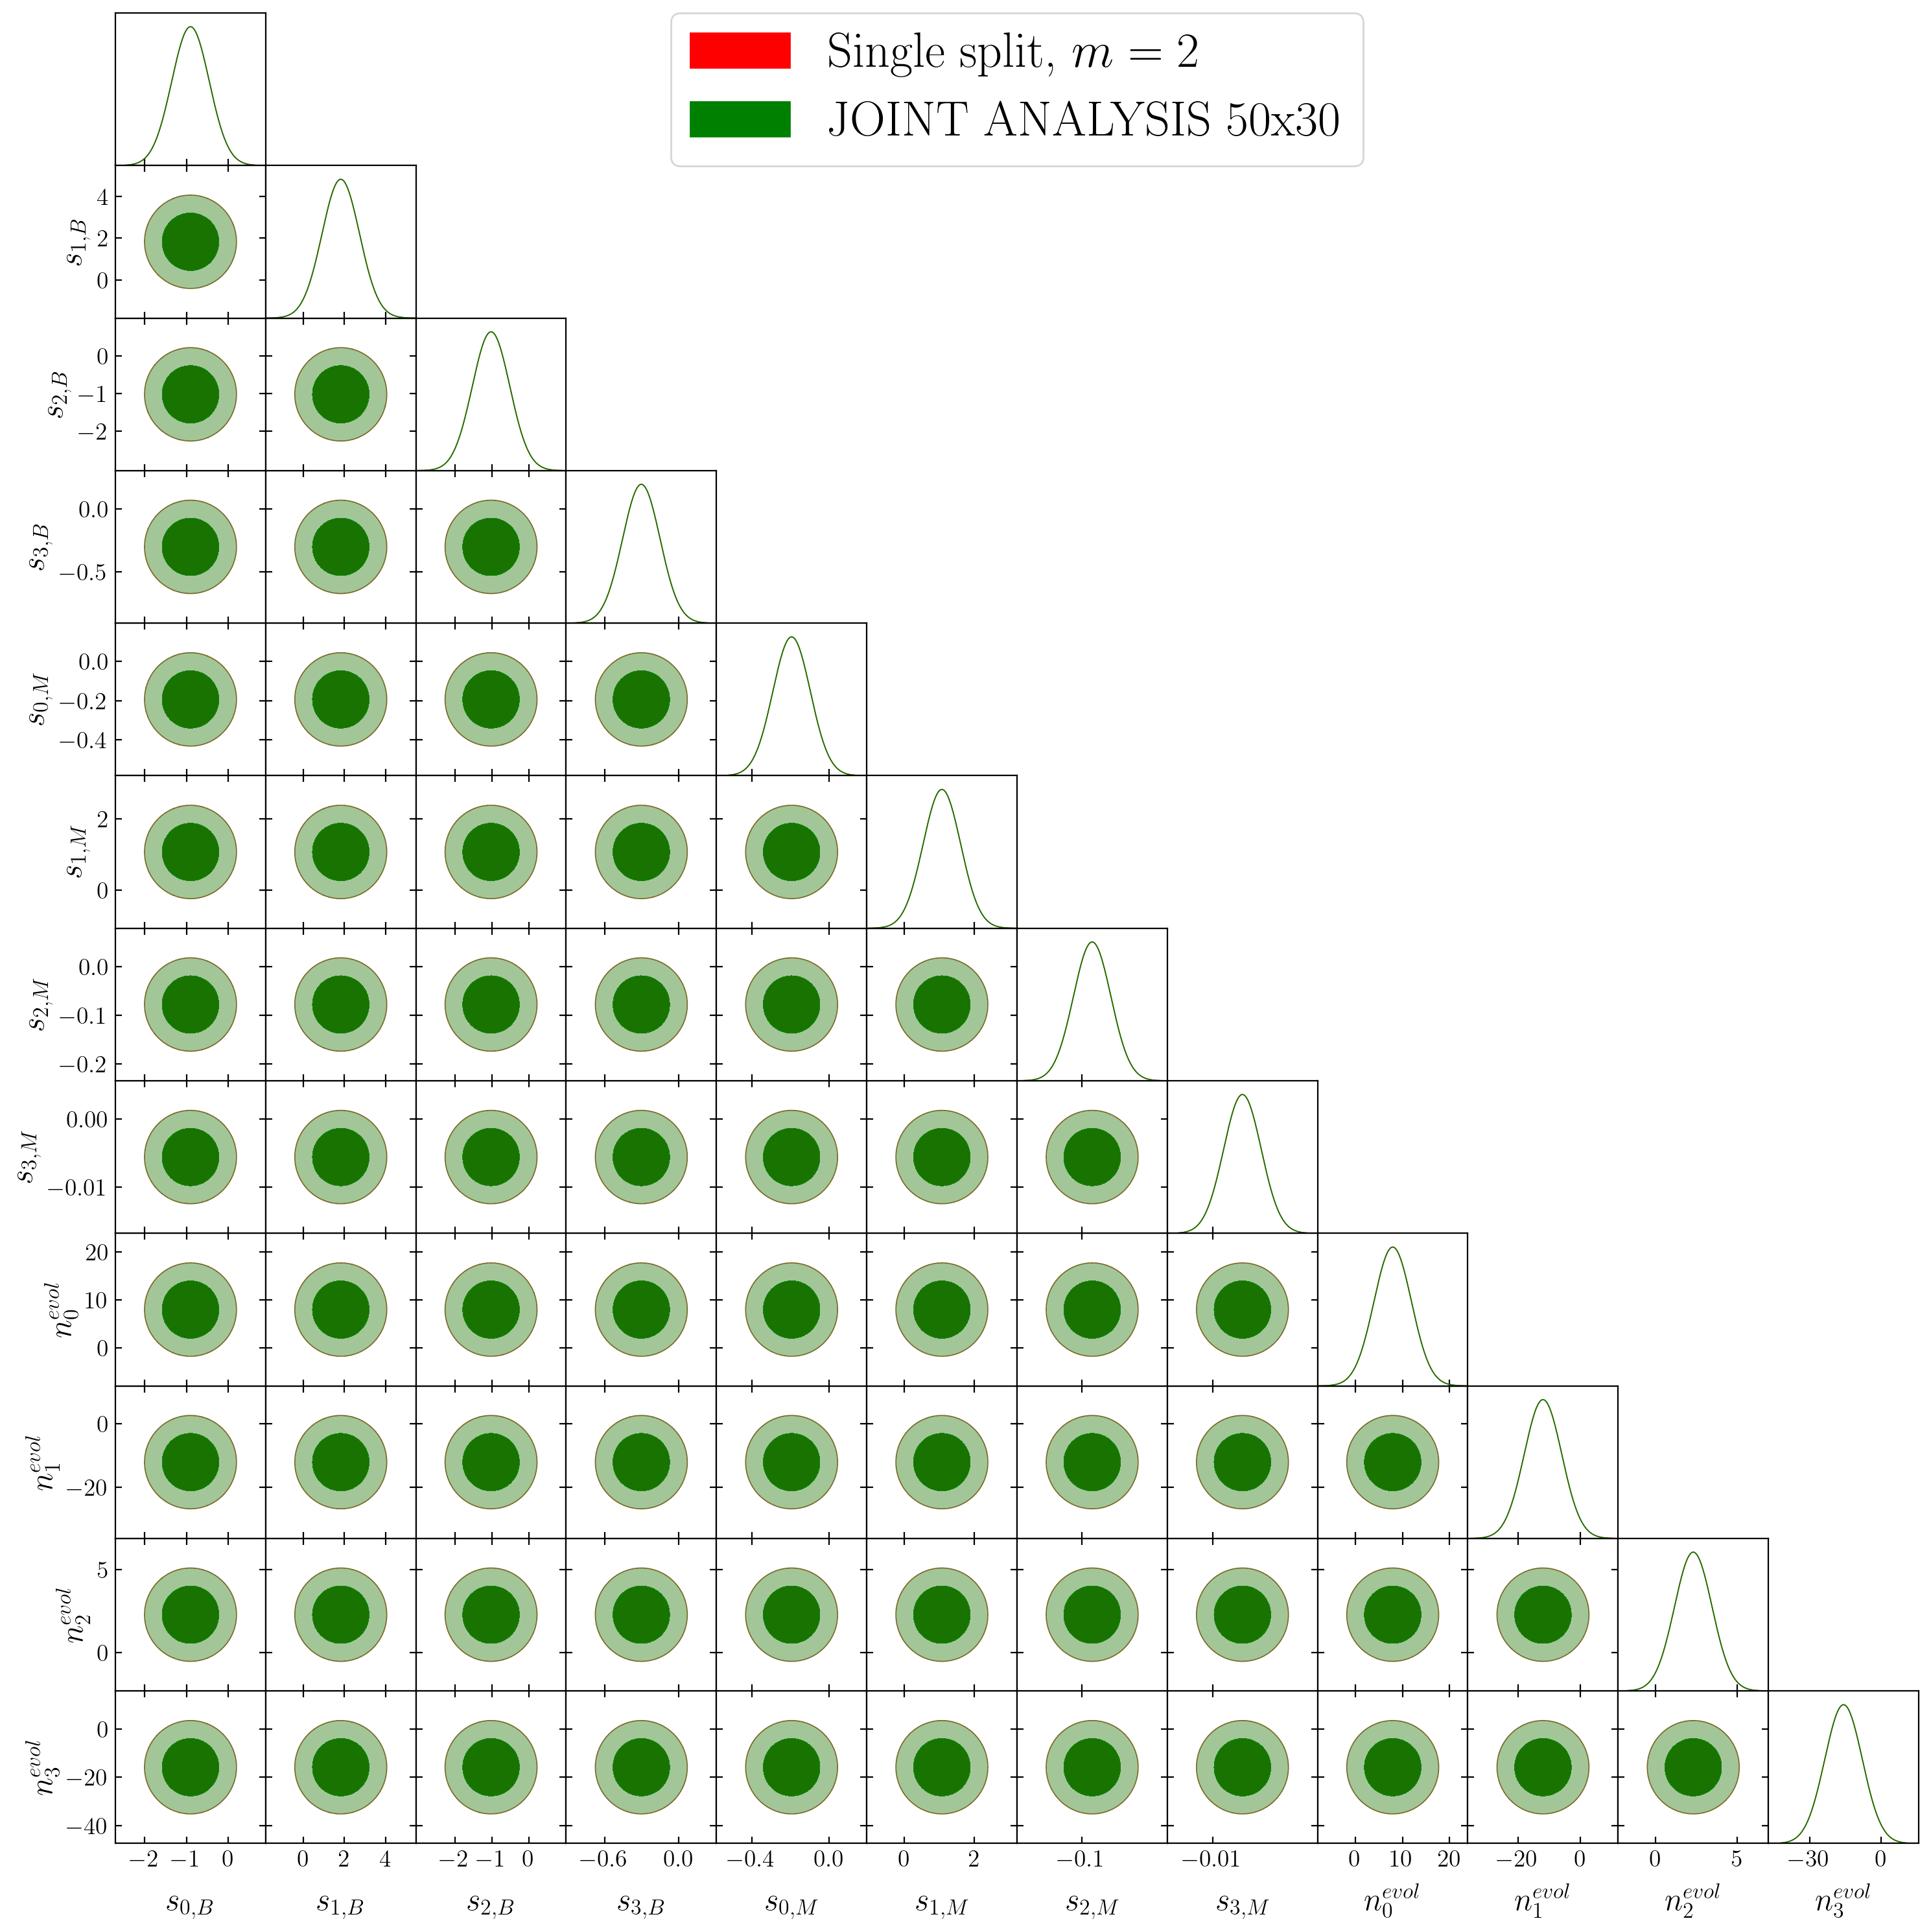

In [82]:
# Triangle plot

mean_joint = params_fid_
mean_50 = params_fid_50[:-9]

sB_names = ['s'+str(int(i))+'B' for i in np.arange(len(sB_4fit50))]
sM_names = ['s'+str(int(i))+'M' for i in np.arange(len(sM_4fit))]

sB_labels=[r's_{'+str(i)+r',B}' for i in np.arange(len(sB_4fit50))]
sM_labels=[r's_{'+str(i)+r',M}' for i in np.arange(len(sM_4fit))]

num_names = ['n'+str(int(i)) for i in np.arange(len(num_fit))]

num_labels=[r'n_{'+str(i)+r'}^{evol}' for i in np.arange(len(num_fit))]

param_names = sB_names + sM_names + num_names 
labels = sB_labels + sM_labels + num_labels 

GaussDist_joint_sbias_nevol_fit_ = GaussianND(mean_joint, Sigma_Matrix_Joint50x30_[:-13,:-13], labels = labels, names = param_names)
GaussDist_50_sbias_nevol_fit = GaussianND(mean_50, Sigma_Matrix_50[:-9,:-9], labels = labels, names = param_names)

g = plots.get_subplot_plotter(width_inch=15)
g.settings.legend_frame = True
g.settings.alpha_filled_add=0.9
g.settings.legend_fontsize=32
g.settings.axes_fontsize=18
g.settings.axes_labelsize=22
g.settings.axis_tick_max_labels=6

g.triangle_plot([GaussDist_50_sbias_nevol_fit, GaussDist_joint_sbias_nevol_fit_], param_names, 
                filled=True, 
                legend_labels=[r'Single split, $m=2$', r'JOINT ANALYSIS 50x30'],
                contour_colors=['red', 'green'])

In [83]:
np.shape(params_fid), np.shape(params_fid_30)

((29,), (21,))

In [84]:
# Delete rows and columns alien to the 30x70 split

nind = list(range(0,4))

Sigma_Matrix_Joint50x30_ = Sigma_Matrix_Joint50x30

Sigma_Matrix_Joint50x30_ = np.delete(arr=Sigma_Matrix_Joint50x30_, obj=nind, axis=0)
Sigma_Matrix_Joint50x30_ = np.delete(arr=Sigma_Matrix_Joint50x30_, obj=nind, axis=1)

np.shape(Sigma_Matrix_Joint50x30_)

(25, 25)

In [85]:
# Delete elements of params_fid

params_fid_ = params_fid[:-13]

params_fid_ = np.delete(arr=params_fid_, obj=nind, axis=0)

np.shape(params_fid_)

(12,)

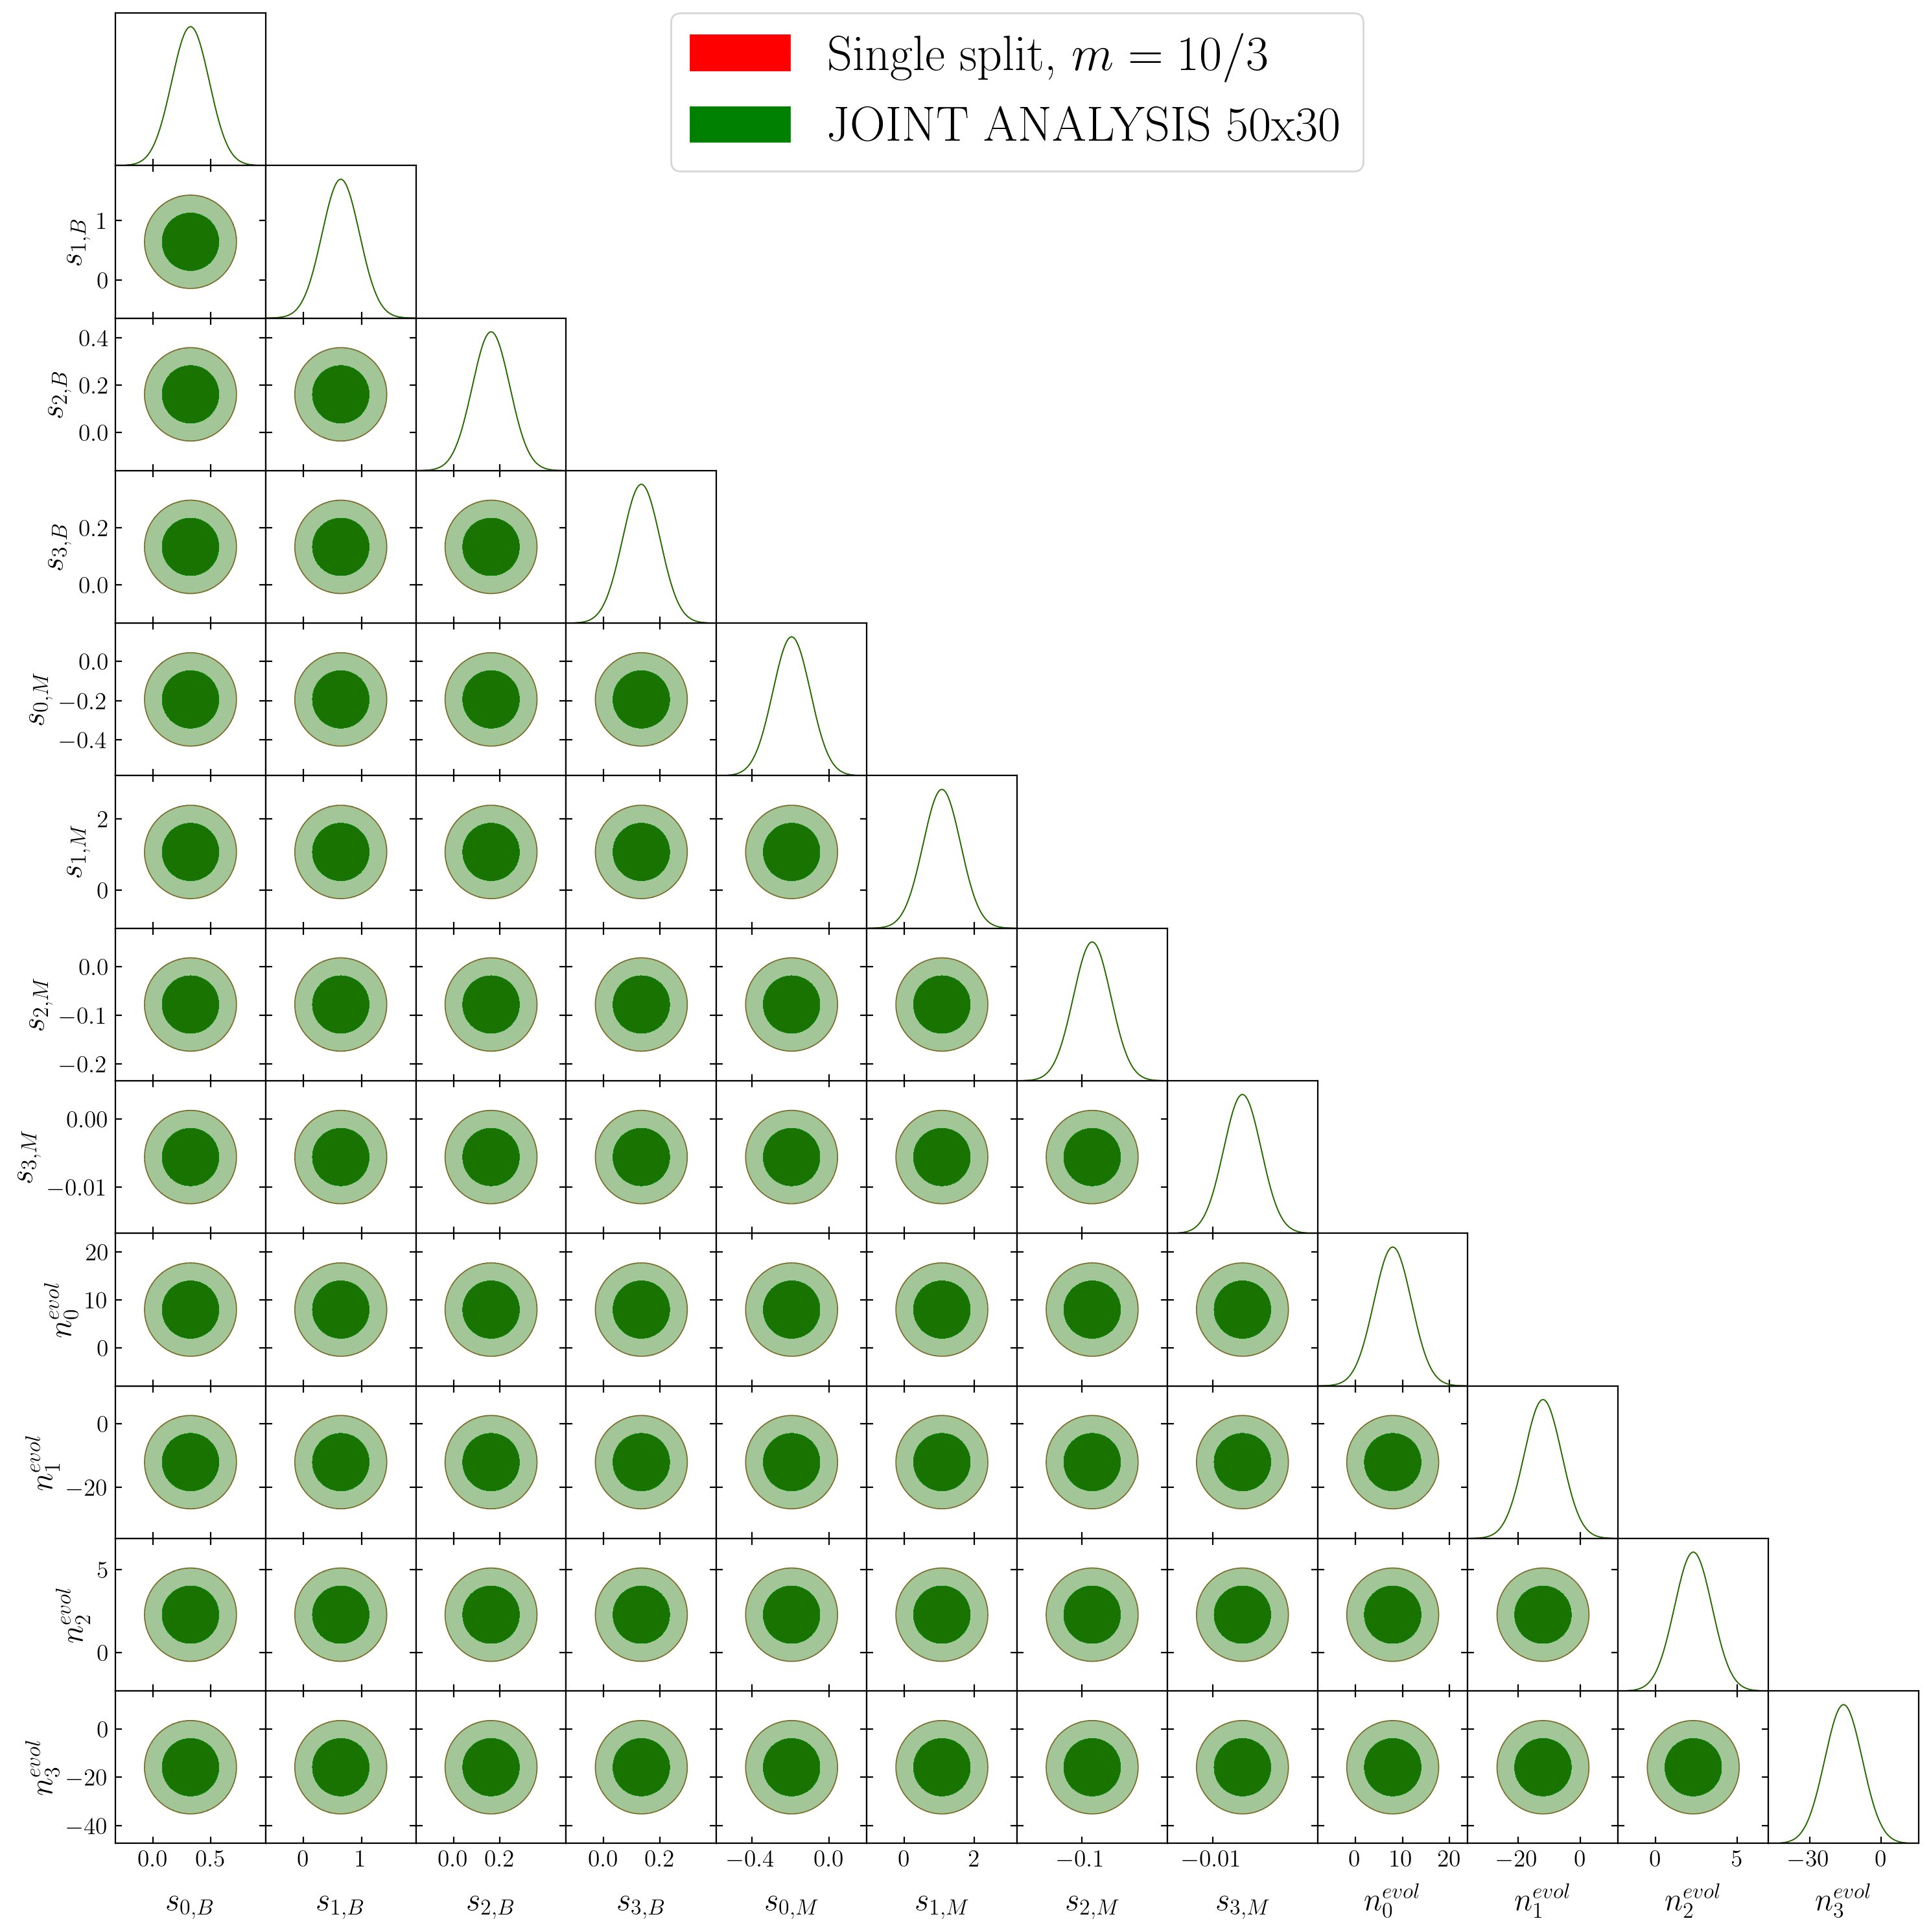

In [86]:
# Triangle plot

mean_joint = params_fid_
mean_30 = params_fid_30[:-9]

sB_names = ['s'+str(int(i))+'B' for i in np.arange(len(sB_4fit50))]
sM_names = ['s'+str(int(i))+'M' for i in np.arange(len(sM_4fit))]

sB_labels=[r's_{'+str(i)+r',B}' for i in np.arange(len(sB_4fit50))]
sM_labels=[r's_{'+str(i)+r',M}' for i in np.arange(len(sM_4fit))]

num_names = ['n'+str(int(i)) for i in np.arange(len(num_fit))]

num_labels=[r'n_{'+str(i)+r'}^{evol}' for i in np.arange(len(num_fit))]

param_names = sB_names + sM_names + num_names 
labels = sB_labels + sM_labels + num_labels 

GaussDist_joint_sbias_nevol_fit_ = GaussianND(mean_joint, Sigma_Matrix_Joint50x30_[:-13,:-13], labels = labels, names = param_names)
GaussDist_30_sbias_nevol_fit = GaussianND(mean_30, Sigma_Matrix_30[:-9,:-9], labels = labels, names = param_names)

g = plots.get_subplot_plotter(width_inch=15)
g.settings.legend_frame = True
g.settings.alpha_filled_add=0.9
g.settings.legend_fontsize=32
g.settings.axes_fontsize=18
g.settings.axes_labelsize=22
g.settings.axis_tick_max_labels=6

g.triangle_plot([GaussDist_30_sbias_nevol_fit, GaussDist_joint_sbias_nevol_fit_], param_names, 
                filled=True, 
                legend_labels=[r'Single split, $m=10/3$', r'JOINT ANALYSIS 50x30'],
                contour_colors=['red', 'green'])

In [87]:
# Delete rows and columns alien to the 50x50 split

nind = list(range(0,16)) + list(range(20,24))

Sigma_Matrix_Joint50x30_ = Sigma_Matrix_Joint50x30

Sigma_Matrix_Joint50x30_ = np.delete(arr=Sigma_Matrix_Joint50x30_, obj=nind, axis=0)
Sigma_Matrix_Joint50x30_ = np.delete(arr=Sigma_Matrix_Joint50x30_, obj=nind, axis=1)

np.shape(Sigma_Matrix_Joint50x30_)

(9, 9)

In [88]:
# Delete elements of params_fid

params_fid_ = params_fid

params_fid_ = np.delete(arr=params_fid_, obj=nind, axis=0)

np.shape(params_fid_)

(9,)

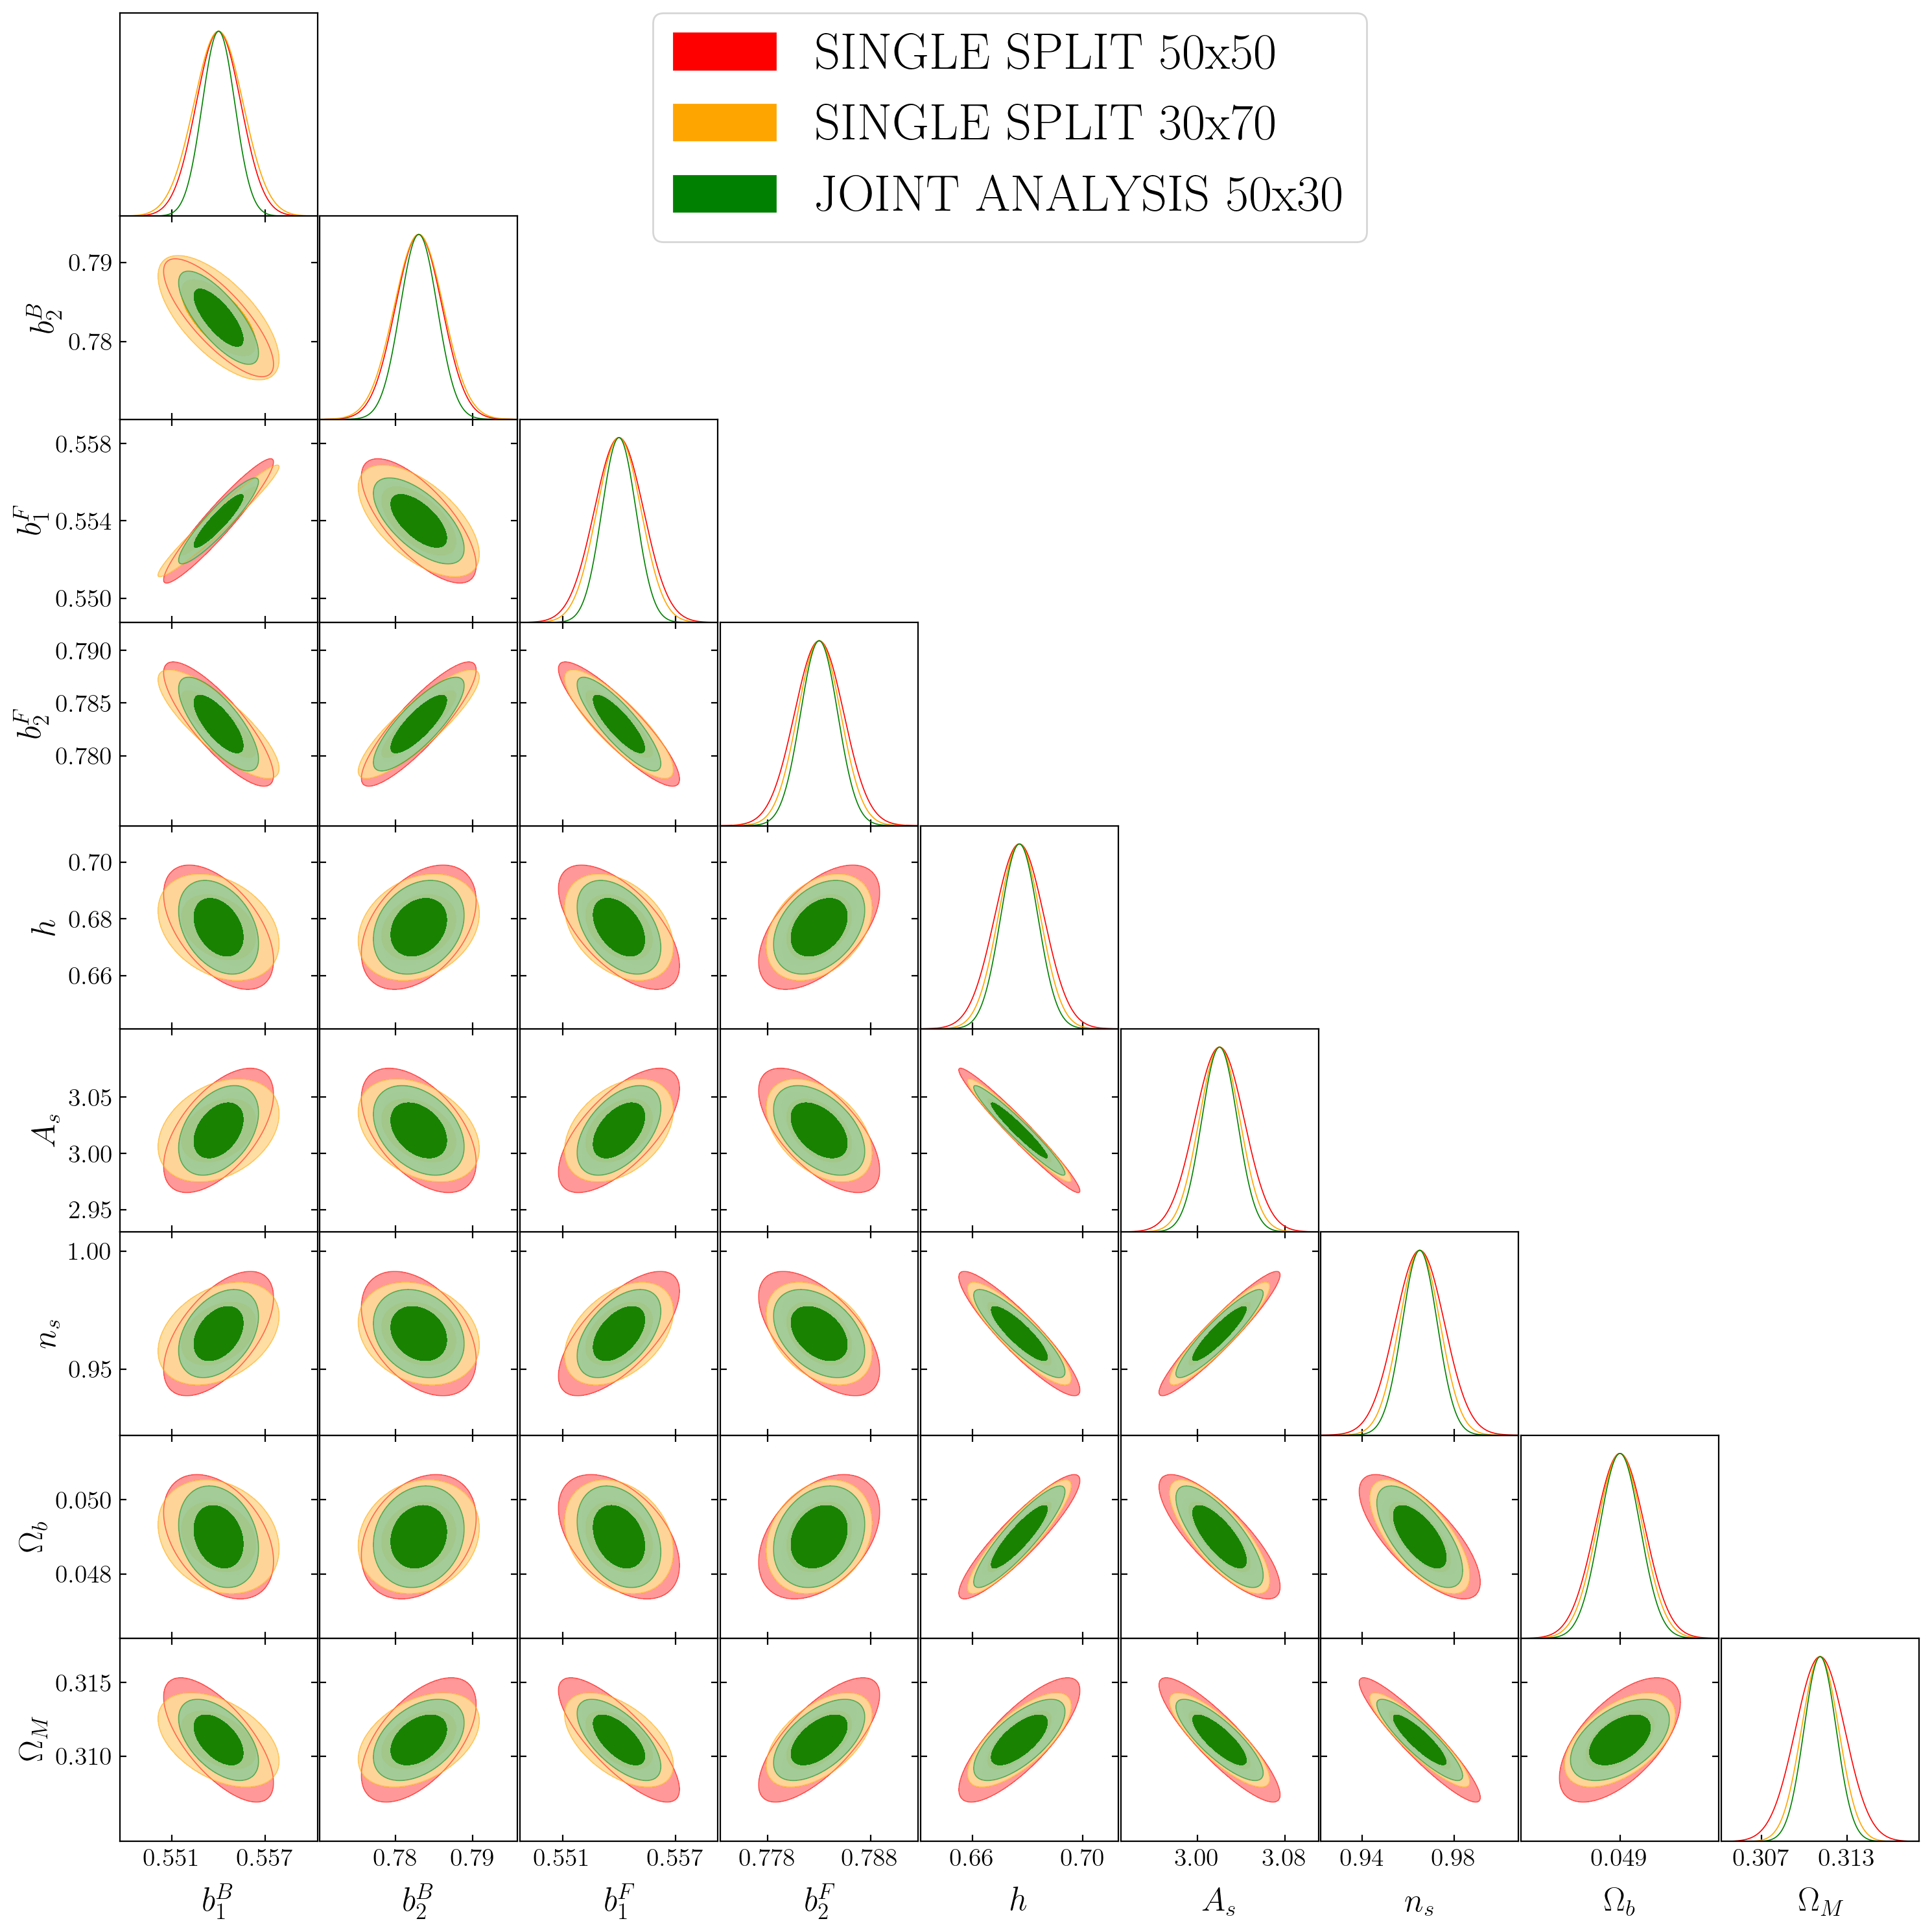

In [89]:
# Triangle plot: GALAXY BIAS AND COSMIC PARAMETERS

mean_50 = params_fid_

gbias_names = ['b1B_m1', 'b2B_m1', 'b1F_m1', 'b2F_m1']
cosmic_names = ['h', 'As', 'ns', 'Ob', 'OM']

gbias_labels = [r'b_1^{B}', r'b_2^{B}', r'b_1^{F}', r'b_2^{F}']
cosmic_labels = [r'h', r'A_s', r'n_s', r'\Omega_b', r'\Omega_M']

param_names = gbias_names + cosmic_names
labels = gbias_labels + cosmic_labels

GaussDist_gbias_cosmic_fit = GaussianND(mean_50, Sigma_Matrix_Joint50x30_, labels = labels, names = param_names)
GaussDist_gbias_cosmic_fit_50 = GaussianND(mean_50, Sigma_Matrix_50[12:, 12:], labels = labels, names = param_names)
GaussDist_gbias_cosmic_fit_30 = GaussianND(mean_50, Sigma_Matrix_30[12:, 12:], labels = labels, names = param_names)


g = plots.get_subplot_plotter(width_inch=15)
g.settings.legend_frame = True
g.settings.alpha_filled_add=0.9
g.settings.legend_fontsize=32
g.settings.axes_fontsize=18
g.settings.axes_labelsize=22
g.settings.axis_tick_max_labels=6

g.triangle_plot([GaussDist_gbias_cosmic_fit_50, GaussDist_gbias_cosmic_fit_30, GaussDist_gbias_cosmic_fit], param_names, 
                filled=True, 
                legend_labels=['SINGLE SPLIT 50x50', 'SINGLE SPLIT 30x70','JOINT ANALYSIS 50x30'],
                contour_colors=['red', 'orange', 'green'])

# JOINT ANALYSIS WITH ONE POPULATION (BRIGHT). 

### 50x50 vs 30x70 SPLITTINGS.

We run the analysis combining two different population splittings, combining the information as if they were two independent experiments. We include the cross correlations between the observables but assume the parameters of each population are independent. The signal looks like:

$$ \vec{\xi}(z,d) = (\{\xi_l^{\mathrm{LM}}(z,d)\}_{l=0,1,2,4}, \{\xi_l^{\mathrm{NP}}(z,d)\}_{l=0,1,2,4}) $$



## Derivatives (LOAD FROM FILE)

In [90]:
with open('derivatives.pkl', 'rb') as File:
    derivatives_dict = pk.load(File)
    
derivatives_50x50 = derivatives_dict['split_50x50']
derivatives_30x70 = derivatives_dict['split_30x70']

In [91]:
dsignal_dsbias50 = derivatives_50x50['dsignal_dsbias']

dsignal_dgbias50 = derivatives_50x50['dsignal_dgbias']

dsignal_dcosmic50 = derivatives_50x50['dsignal_dcosmic']

dsignal_dnum50 = derivatives_50x50['dsignal_dnumev']

np.shape(dsignal_dsbias50), np.shape(dsignal_dgbias50), np.shape(dsignal_dcosmic50), np.shape(dsignal_dnum50)

((8, 19, 324), (4, 19, 324), (5, 19, 324), (4, 19, 324))

In [92]:
dsignal_dsbias30 = derivatives_30x70['dsignal_dsbias']

dsignal_dgbias30 = derivatives_30x70['dsignal_dgbias']

dsignal_dcosmic30 = derivatives_30x70['dsignal_dcosmic']

dsignal_dnum30 = derivatives_30x70['dsignal_dnumev']

np.shape(dsignal_dsbias30), np.shape(dsignal_dgbias30), np.shape(dsignal_dcosmic30), np.shape(dsignal_dnum30)

((8, 19, 324), (4, 19, 324), (5, 19, 324), (4, 19, 324))

In [93]:
dsignal_dtheta50 = np.concatenate([dsignal_dsbias50, dsignal_dnum50, dsignal_dgbias50, dsignal_dcosmic50])

np.shape(dsignal_dtheta50)

(21, 19, 324)

In [94]:
dsignal_dtheta30 = np.concatenate([dsignal_dsbias30, dsignal_dnum30, dsignal_dgbias30, dsignal_dcosmic30])

np.shape(dsignal_dtheta30)

(21, 19, 324)

REMOVE FAINT POPULATION, ODD MULTIPOLES

In [95]:
n_sep = len(dist[0])
n_signals = int(len(dsignal_dtheta50[0,0])/n_sep)

ind_to_remove_faint_odd = list(range(n_sep, 4*n_sep)) + list(range(5*n_sep, 7*n_sep)) + list(range(8*n_sep, 9*n_sep))

dsignal_dtheta50 = np.delete(dsignal_dtheta50, ind_to_remove_faint_odd, axis=2)
dsignal_dtheta30 = np.delete(dsignal_dtheta30, ind_to_remove_faint_odd, axis=2)

np.shape(dsignal_dtheta50), np.shape(dsignal_dtheta30)


((21, 19, 108), (21, 19, 108))

REMOVE HEXADECAPOLE FROM 50x50 split

In [96]:
n_sep = len(dist[0])
n_signals = int(len(dsignal_dtheta50[0,0])/n_sep)
ind_to_remove_hexa = list(range(7*n_sep, 8*n_sep))

print('Number of separations = ', n_sep)
print('Number of signals = ', n_signals)
print('Indices to remove = ', ind_to_remove_hexa)

Number of separations =  36
Number of signals =  3
Indices to remove =  [252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287]


In [97]:
dsignal_dsB50 = np.concatenate([dsignal_dsbias50[:4], np.zeros_like(dsignal_dsbias50[:4])], axis=2)
dsignal_dsB30 = np.concatenate([np.zeros_like(dsignal_dsbias30[:4]), dsignal_dsbias30[:4]], axis=2)

dsignal_dsM = np.concatenate([dsignal_dsbias50[4:], dsignal_dsbias30[4:]], axis=2)
dsignal_dnum = np.concatenate([dsignal_dnum50, dsignal_dnum30], axis=2)
dsignal_dgbias50 = np.concatenate([dsignal_dgbias50, np.zeros_like(dsignal_dgbias50[:4])], axis=2)
dsignal_dgbias30 = np.concatenate([np.zeros_like(dsignal_dgbias30[:4]), dsignal_dgbias30], axis=2)
dsignal_dcosmic = np.concatenate([dsignal_dcosmic50, dsignal_dcosmic30], axis=2)

In [98]:
np.shape(dsignal_dgbias50)

(4, 19, 648)

In [99]:
dsignal_dtheta_multi_ = np.concatenate([dsignal_dsB50, dsignal_dsB30, dsignal_dsM, dsignal_dnum, dsignal_dgbias50[:2], dsignal_dgbias30[:2], dsignal_dcosmic])

ind_to_remove = ind_to_remove_faint_odd + ind_to_remove_hexa + list(range(n_sep+324, 4*n_sep+324)) + list(range(5*n_sep+324, 7*n_sep+324)) + list(range(8*n_sep+324, 9*n_sep+324))

dsignal_dtheta_multi = np.delete(dsignal_dtheta_multi_, ind_to_remove, axis=2)


np.shape(dsignal_dtheta_multi_), np.shape(dsignal_dtheta_multi)

((25, 19, 648), (25, 19, 180))

In [100]:
len(ind_to_remove), len(ind_to_remove_faint_odd), len(ind_to_remove_hexa)

(468, 216, 36)

## Covariance Matrix

In [101]:
# Create the PRIORS Cov Matrix for sB, sM, num

errB = [5e-1, 5e-1] 
errF = [5e-1, 5e-1]

num_fit = np.array([7.94599872, -12.03752386, 2.29927261, -15.83887364])

sB_4fit50 = np.array([-0.90110745,  1.82300205, -1.01878441, -0.30342325])
sB_4fit30 = np.array([0.32517601, 0.64417733, 0.16141876, 0.13330362])

sM_4fit = np.array([-0.19376092,  1.07473357, -0.07806244, -0.00558004])

dsB_50 = sB_4fit50 * errB[0] 
dsB_30 = sB_4fit30 * errB[0] 

dsM = sM_4fit * errF[0]

dnum = num_fit * errB[1]

Cov_prior_all = np.diag(np.concatenate([dsB_50**2, dsB_30**2, dsM**2, dnum**2]))

Inv_Cov_prior_all_ = np.linalg.inv(Cov_prior_all)

Inv_Cov_prior_all = np.zeros([len(dsignal_dtheta_multi), len(dsignal_dtheta_multi)])
Inv_Cov_prior_all[:len(Inv_Cov_prior_all_), :len(Inv_Cov_prior_all_)] = Inv_Cov_prior_all_

np.shape(Cov_prior_all), np.shape(Inv_Cov_prior_all)

((16, 16), (25, 25))

In [102]:
Cov_Multipoles_Joint50x30_ = fm.cov_matrix_joint(d=dist[0], z_bins=z_bins, small_off_diagonal=True, splits=[50,30], rtol=1e-4, contributions='CC')

print('\n ... Remove the FAINT, the ODD MULTIPOLES and one HEXADECAPOLE from 50x50 split ... \n')

Cov_Multipoles_Joint50x30 = np.delete(Cov_Multipoles_Joint50x30_, ind_to_remove, axis=1)
Cov_Multipoles_Joint50x30 = np.delete(Cov_Multipoles_Joint50x30, ind_to_remove, axis=2)

np.shape(Cov_Multipoles_Joint50x30_), np.shape(Cov_Multipoles_Joint50x30)


 ... Loading Covariance Matrices (Joint-splittings Analysis) [CC] [MONOBB, MONOBF, MONOFF, DIPBF, QUADBB, QUADBF, QUADFF, HEXAT, OCTBF] ... 




 ... Remove the FAINT, the ODD MULTIPOLES and one HEXADECAPOLE from 50x50 split ... 



((19, 648, 648), (19, 180, 180))

In [103]:
# Check if Cov Matrices are symmetric:

for n, z in enumerate(z_bins):
    print(n, np.allclose(Cov_Multipoles_Joint50x30_[n], Cov_Multipoles_Joint50x30_[n].T, rtol = 1e-15), np.allclose(Cov_Multipoles_Joint50x30[n], Cov_Multipoles_Joint50x30[n].T, rtol = 1e-15))

0 True True
1 True True
2 True True
3 True True
4 True True
5 True True
6 True True
7 True True
8 True True
9 True True
10 True True
11 True True
12 True True
13 True True
14 True True
15 True True
16 True True
17 True True
18 True True


In [104]:
# Load the Covariance Matrix of the multipoles

Inv_Cov_Multipoles_Joint50x30_ = np.linalg.pinv(Cov_Multipoles_Joint50x30)

# Symmetrize the matrix

Inv_Cov_Multipoles_Joint50x30 = [0.5 * (Inv_Cov_Multipoles_Joint50x30_[i] + Inv_Cov_Multipoles_Joint50x30_[i].T) for i in range(len(z_bins))]

In [105]:
# Check if Inverse Cov Matrices are symmetric:

for n, z in enumerate(z_bins):
    print(n, np.allclose(Inv_Cov_Multipoles_Joint50x30_[n], Inv_Cov_Multipoles_Joint50x30_[n].T, rtol = 1e-1), np.allclose(Inv_Cov_Multipoles_Joint50x30[n], Inv_Cov_Multipoles_Joint50x30[n].T, rtol = 1e-3))

0 True True
1 True True
2 True True
3 True True
4 True True
5 True True
6 True True
7 True True
8 True True
9 True True
10 True True
11 True True
12 True True
13 True True
14 True True
15 True True
16 True True
17 True True
18 True True


In [106]:
# Build the Fisher Matrix

Fisher_Matrix_Joint50x30_ = fm.fisher_matrix(d_signal = dsignal_dtheta_multi, inv_cov = Inv_Cov_Multipoles_Joint50x30_, z_bins = z_bins)
Fisher_Matrix_Joint50x30 = Fisher_Matrix_Joint50x30_ + Inv_Cov_prior_all

np.shape(Fisher_Matrix_Joint50x30)


 ... Computing the Fisher Matrix ... 

Signal & Cov must be given as functions (z,d) and (z,d,d') respectively. 


 ... Success! ... 



(25, 25)

In [107]:
print('\n'.join(['\t'.join([str(cell) for cell in row]) for row in Fisher_Matrix_Joint50x30[:8,:8]]))

4.92614091333159	0.0	0.0	0.0	0.0	0.0	0.0	0.0
0.0	1.2036096949339048	0.0	0.0	0.0	0.0	0.0	0.0
0.0	0.0	3.853855353417002	0.0	0.0	0.0	0.0	0.0
0.0	0.0	0.0	43.44724867655685	0.0	0.0	0.0	0.0
0.0	0.0	0.0	0.0	37.82883752123923	0.0	0.0	0.0
0.0	0.0	0.0	0.0	0.0	9.639380358545878	0.0	0.0
0.0	0.0	0.0	0.0	0.0	0.0	153.5154103270564	0.0
0.0	0.0	0.0	0.0	0.0	0.0	0.0	225.10031603189591


In [108]:
print('\n'.join(['\t'.join([str(cell) for cell in row]) for row in Fisher_Matrix_Joint50x30[8:16,8:16]]))

106.5436609609975	0.0	0.0	0.0	0.0	0.0	0.0	0.0
0.0	3.4630468121011844	0.0	0.0	0.0	0.0	0.0	0.0
0.0	0.0	656.4108446886339	0.0	0.0	0.0	0.0	0.0
0.0	0.0	0.0	128465.16144918442	0.0	0.0	0.0	0.0
0.0	0.0	0.0	0.0	0.06335239092003143	0.0	0.0	0.0
0.0	0.0	0.0	0.0	0.0	0.02760486765761777	0.0	0.0
0.0	0.0	0.0	0.0	0.0	0.0	0.7566221650091618	0.0
0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.01594451829440951


In [109]:
print('\n'.join(['\t'.join([str(cell) for cell in row]) for row in Fisher_Matrix_Joint50x30[16:,16:]]))

19402180.616620004	5846034.144975688	-15039043.629902424	-4335950.8907766715	1426629.18297761	475571.839400173	147424.00200410318	-5216601.360246207	2338502.219330332
5846034.144975688	2336796.469977276	-4335950.890776673	-1615578.3638576907	693359.959788295	249824.24284344082	14363.642244015493	-2470621.8686851347	782116.0878239878
-15039043.629902508	-4335950.890776683	13125906.663908752	4034419.6427094396	868301.9383680986	395982.3934074339	-238350.56401134902	-2805525.6909687202	-340295.35651543085
-4335950.890776683	-1615578.3638576923	4034419.6427094396	1628726.196964492	488267.76928663417	210943.60496916706	-96812.30277196692	-1615097.116707256	69920.6013060152
1426629.182977515	693359.9597882871	868301.938368172	488267.7692866416	3938842.3631033706	1322257.818736456	202482.76395130044	-14880101.628328823	3709027.2634829204
475571.8394001314	249824.2428434357	395982.39340747026	210943.60496917195	1322257.8187364626	480671.3693522841	16756.691450815564	-4689919.290896933	1290619.

In [110]:
print(np.allclose(Fisher_Matrix_Joint50x30, Fisher_Matrix_Joint50x30.T, rtol=1e-6))

True


In [111]:
print(np.allclose(Fisher_Matrix_Joint50x30[:-5,:-5], Fisher_Matrix_Joint50x30[:-5,:-5].T, rtol=1e-6))

True


In [112]:
np.linalg.det(Fisher_Matrix_Joint50x30)

3.870296840845778e+66

## Constraints

In [113]:
#Absolute Errors

Sigma_Matrix_Joint50x30 = np.linalg.inv(Fisher_Matrix_Joint50x30)

Abs_Errors_all_Joint = np.sqrt(np.diag(Sigma_Matrix_Joint50x30))

# Fiducial values

sB_fit = np.concatenate([sB_4fit50, sB_4fit30]) 
gbias_fit = np.concatenate([np.array([0.554, 0.783]), np.array([0.554, 0.783])])
cosmic_fid = np.fromiter(params_dict0.values(), dtype=float)
cosmic_fid[1] = np.log(10**10 * cosmic_fid[1])

params_fid = np.concatenate([sB_fit, sM_4fit, num_fit, gbias_fit, cosmic_fid])

# Relative errors

Rel_Errors_all_Joint = np.abs(Abs_Errors_all_Joint/params_fid)

par_errors_all_Joint = Rel_Errors_all_Joint * 100

print()
print('------------ Relative errors * 100 ------------' )
print()
print('sB_50 = ', par_errors_all_Joint[0:int(len(sB_fit)/2)])
print()
print('sB_30 = ', par_errors_all_Joint[int(len(sB_fit)/2):len(sB_fit)])
print()
print('s_model = ', par_errors_all_Joint[len(sB_fit):len(sB_fit)+len(sM_4fit)])
print()
print('number = ', par_errors_all_Joint[(len(sB_fit)+len(sM_4fit)):(len(sB_fit)+len(sM_4fit)+len(num_fit))])
print()
print('gbias_50 = ', par_errors_all_Joint[((len(sB_fit)+len(sM_4fit)+len(num_fit))):((len(sB_fit)+len(sM_4fit)+len(num_fit))+int(len(gbias_fit)/2))])
print()
print('gbias_30 = ', par_errors_all_Joint[(len(sB_fit)+len(sM_4fit)+len(num_fit)+int(len(gbias_fit)/2)):((len(sB_fit)+len(sM_4fit)+len(num_fit))+int(len(gbias_fit)))])
print()
print('cosmic = ', par_errors_all_Joint[((len(sB_fit)+len(sM_4fit)+len(num_fit))+len(gbias_fit)):((len(sB_fit)+len(sM_4fit)+len(num_fit))+len(gbias_fit) + len(cosmic_fid))])
print()


------------ Relative errors * 100 ------------

sB_50 =  [50. 50. 50. 50.]

sB_30 =  [50. 50. 50. 50.]

s_model =  [50. 50. 50. 50.]

number =  [50. 50. 50. 50.]

gbias_50 =  [0.75712393 0.48601852]

gbias_30 =  [0.95328614 0.61368466]

cosmic =  [1.57862828 0.99428492 1.42026256 1.51191321 0.7605842 ]



In [114]:
np.linalg.det(Fisher_Matrix_Joint50x30), np.linalg.det(Sigma_Matrix_Joint50x30)

(3.870296840845778e+66, 2.5837811442424118e-67)

In [115]:
def isPSD(A, tol=1e-4):
    E = np.linalg.eigvals(A)
    return E, np.all(E > -tol)

# Example usage:
# Your matrix
A = np.array([[1, 2], [2, 4]])
# Check if A is positive semi-definite
print(isPSD(A))

(array([0., 5.]), True)


In [116]:
print(isPSD(Fisher_Matrix_Joint50x30[:-5,:-5], tol=1e-10))

(array([3.44739720e+07, 2.94417927e+04, 1.20052860e+06, 7.89667591e+05,
       4.92614091e+00, 1.20360969e+00, 3.85385535e+00, 4.34472487e+01,
       3.78288375e+01, 9.63938036e+00, 1.53515410e+02, 2.25100316e+02,
       1.06543661e+02, 3.46304681e+00, 6.56410845e+02, 1.28465161e+05,
       6.33523909e-02, 2.76048677e-02, 7.56622165e-01, 1.59445183e-02]), True)


In [117]:
print(isPSD(Sigma_Matrix_Joint50x30, tol=1e-10))

(array([1.17553036e-03, 8.80196476e-05, 1.96137561e-05, 7.35075222e-06,
       1.27095742e-06, 1.07953676e-06, 2.54782762e-07, 2.91256123e-08,
       1.39692401e-08, 2.02998659e-01, 8.30834119e-01, 2.59480419e-01,
       2.30164172e-02, 2.64348594e-02, 1.03741108e-01, 6.51400402e-03,
       4.44246378e-03, 9.38582353e-03, 2.88763062e-01, 1.52343613e-03,
       7.78421160e-06, 1.57847239e+01, 3.62254952e+01, 1.32166363e+00,
       6.27174795e+01]), True)


In [118]:
# Perform Singular Value Decomposition

U, s, Vh = np.linalg.svd(Fisher_Matrix_Joint50x30)

# s contains the singular values of A
print("Singular values of A:", s)

# Calculate the condition number
condition_number = s[0] / s[-1]
print("Condition number of A:", condition_number)

Singular values of A: [7.15858552e+07 3.43340421e+07 3.92491231e+06 9.26323248e+05
 7.86808422e+05 1.36040499e+05 1.28465161e+05 5.09846250e+04
 1.13610998e+04 8.50679862e+02 6.56410845e+02 2.25100316e+02
 1.53515410e+02 1.06543661e+02 4.34472487e+01 3.78288375e+01
 9.63938036e+00 4.92614091e+00 3.85385535e+00 3.46304681e+00
 1.20360969e+00 7.56622165e-01 6.33523909e-02 2.76048677e-02
 1.59445183e-02]
Condition number of A: 4489684407.0077


In [119]:
# Create Σ+ (the pseudo-inverse of the diagonal matrix Σ)
S_plus = np.zeros((Fisher_Matrix_Joint50x30.shape[0], Fisher_Matrix_Joint50x30.shape[1])).T
S_plus[:s.shape[0], :s.shape[0]] = np.linalg.inv(np.diag(s))

# Compute the pseudo-inverse of A
A_plus = Vh.T @ S_plus @ U.T

# Verify by multiplying with the original matrix A
identity_matrix = Fisher_Matrix_Joint50x30 @ A_plus

In [120]:
np.allclose(A_plus, Sigma_Matrix_Joint50x30, rtol=1e-20)

True

In [121]:
np.linalg.det(A_plus), np.linalg.det(Sigma_Matrix_Joint50x30)

(2.5837811442428523e-67, 2.5837811442424118e-67)

In [122]:
np.prod(s), np.linalg.det(Fisher_Matrix_Joint50x30)

(3.87029684084555e+66, 3.870296840845778e+66)

# SINGLE SPLIT 

### $m = 2 \,\rightarrow\,$ $50\%$ Brigth - $50\%$ Faint

In [123]:
len(dsignal_dgbias50[1,1])/2

324.0

In [124]:
dsignal_dtheta_fit_all50 = np.concatenate([dsignal_dsbias50, dsignal_dnum50, dsignal_dgbias50[:2,:,:324], dsignal_dcosmic50])

np.shape(dsignal_dtheta_fit_all50)

(19, 19, 324)

In [125]:
dsignal_dtheta_fit_all50 = np.delete(dsignal_dtheta_fit_all50, ind_to_remove_faint_odd, axis=2)

np.shape(dsignal_dtheta_fit_all50)

(19, 19, 108)

In [126]:
# Create the Cov Matrix for sB, sF, num

Cov_priors_50 = np.diag(np.concatenate([dsB_50**2, dsM**2, dnum**2]))

Inv_Cov_prior_50_ = np.linalg.inv(Cov_priors_50)

Inv_Cov_prior_50 = np.zeros([len(dsignal_dtheta_fit_all50), len(dsignal_dtheta_fit_all50)])
Inv_Cov_prior_50[:len(Inv_Cov_prior_50_), :len(Inv_Cov_prior_50_)] = Inv_Cov_prior_50_

np.shape(Cov_priors_50)

(12, 12)

In [127]:
Cov_Multipoles_50 = fm.cov_matrix_survey(d = dist[0], z_bins = z_bins, split=[50, 50], small_off_diagonal = True, rtol=1e-10)

print('\n ... Remove the FAINT and the ODD MULTIPOLES from 50x50 split ... \n')

Cov_Even_Multipoles_50 = np.delete(Cov_Multipoles_50, ind_to_remove_faint_odd, axis=1)
Cov_Even_Multipoles_50 = np.delete(Cov_Even_Multipoles_50, ind_to_remove_faint_odd, axis=2)

np.shape(Cov_Even_Multipoles_50)


 ... Loading Covariance Matrices [MONOBB, MONOBF, MONOFF, DIPBF, QUADBB, QUADBF, QUADFF, HEXAT, OCTBF] ... 


 ... Success! ... 


 ... Remove the FAINT and the ODD MULTIPOLES from 50x50 split ... 



(19, 108, 108)

In [128]:
# Fisher Matrix + prior

Inv_Cov_Multipoles_50 = np.array([np.linalg.inv(Cov_Even_Multipoles_50[i]) for i,_ in enumerate(z_bins)])

Fisher_Matrix_50_ = fm.fisher_matrix(d_signal = dsignal_dtheta_fit_all50, inv_cov = Inv_Cov_Multipoles_50, z_bins = z_bins)

Fisher_Matrix_50 = Fisher_Matrix_50_ + Inv_Cov_prior_50

np.shape(Fisher_Matrix_50)


 ... Computing the Fisher Matrix ... 

Signal & Cov must be given as functions (z,d) and (z,d,d') respectively. 


 ... Success! ... 



(19, 19)

In [129]:
print(np.allclose(Fisher_Matrix_50, Fisher_Matrix_50.T, rtol=1e-11))

True


In [130]:
np.linalg.det(Fisher_Matrix_50)

1.579233900178075e+46

In [131]:
Sigma_Matrix_50 = np.linalg.inv(Fisher_Matrix_50)

#Absolute Errors

Abs_Errors_all_50 = np.sqrt(np.diag(Sigma_Matrix_50))

# Fiducial values

sbias_fit_50 = np.concatenate([sB_4fit50, sM_4fit])
gbias_fit_50 = np.concatenate([np.array([0.554, 0.783])])
cosmic_fid = np.fromiter(params_dict0.values(), dtype=float)
cosmic_fid[1] = np.log(10**10 * cosmic_fid[1])

params_fid_50 = np.concatenate([sbias_fit_50, num_fit, gbias_fit_50, cosmic_fid])

# Relative errors

Rel_Errors_all_50 = np.abs(Abs_Errors_all_50/params_fid_50)

par_errors_all_50 = Rel_Errors_all_50 * 100

print()
print('------------ Relative errors * 100 ------------' )
print()
print('sB = ', par_errors_all_50[0:int(len(sbias_fit_50)/2)])
print()
print('smodel = ', par_errors_all_50[int(len(sbias_fit_50)/2):len(sbias_fit_50)])
print()
print('number = ', par_errors_all_50[len(sbias_fit_50):(len(sbias_fit_50) + len(num_fit))])
print()
print('gbias = ', par_errors_all_50[(len(sbias_fit_50) + len(num_fit)):(len(sbias_fit_50) + len(num_fit) + len(gbias_fit_50))])
print()
print('cosmic = ', par_errors_all_50[(len(sbias_fit_50) + len(num_fit)+len(gbias_fit_50)):])


------------ Relative errors * 100 ------------

sB =  [50. 50. 50. 50.]

smodel =  [50. 50. 50. 50.]

number =  [50. 50. 50. 50.]

gbias =  [0.88251079 0.56813654]

cosmic =  [1.84615358 1.13214617 1.68993266 1.74452575 0.89027757]


In [132]:
print(np.allclose(Sigma_Matrix_50, Sigma_Matrix_50.T, rtol=1e-20))

True


In [133]:
np.linalg.det(Sigma_Matrix_50)

6.332184231146398e-47

In [134]:
# Perform Singular Value Decomposition

U, s, Vh = np.linalg.svd(Fisher_Matrix_50)

# s contains the singular values of A
print("Singular values of A:", s)

# Calculate the condition number
condition_number = s[0] / s[-1]
print("Condition number of A:", condition_number)

Singular values of A: [6.24436901e+07 3.30738717e+06 1.39305509e+06 1.28465161e+05
 1.26245064e+05 6.76387417e+04 1.53351626e+04 6.56410845e+02
 6.43235238e+02 1.06543661e+02 4.34472487e+01 4.92614091e+00
 3.85385535e+00 3.46304681e+00 1.20360969e+00 7.56622165e-01
 6.33523909e-02 2.76048677e-02 1.59445183e-02]
Condition number of A: 3916310859.500444


In [135]:
# Create Σ+ (the pseudo-inverse of the diagonal matrix Σ)
S_plus = np.zeros((Fisher_Matrix_50.shape[0], Fisher_Matrix_50.shape[1])).T
S_plus[:s.shape[0], :s.shape[0]] = np.linalg.inv(np.diag(s))

# Compute the pseudo-inverse of A
A_plus = Vh.T @ S_plus @ U.T

# Verify by multiplying with the original matrix A
identity_matrix = Fisher_Matrix_50 @ A_plus

In [136]:
np.allclose(A_plus, Sigma_Matrix_50, rtol=1e-20)

True

# SINGLE SPLIT 

### $m = 10/3 \,\rightarrow\,$ $30\%$ Brigth - $70\%$ Faint

In [137]:
len(dsignal_dgbias30[1,1])/2

324.0

In [138]:
dsignal_dtheta_fit_all30 = np.concatenate([dsignal_dsbias30, dsignal_dnum30, dsignal_dgbias30[:2,:,324:], dsignal_dcosmic30])

np.shape(dsignal_dtheta_fit_all30)

(19, 19, 324)

In [139]:
dsignal_dtheta_fit_all30 = np.delete(dsignal_dtheta_fit_all30, ind_to_remove_faint_odd, axis=2)

np.shape(dsignal_dtheta_fit_all30)

(19, 19, 108)

In [140]:
# Create the Cov Matrix for sB, sF, num

Cov_priors_30 = np.diag(np.concatenate([dsB_30**2, dsM**2, dnum**2]))

Inv_Cov_prior_30_ = np.linalg.inv(Cov_priors_30)

Inv_Cov_prior_30 = np.zeros([len(dsignal_dtheta_fit_all30), len(dsignal_dtheta_fit_all30)])
Inv_Cov_prior_30[:len(Inv_Cov_prior_30_), :len(Inv_Cov_prior_30_)] = Inv_Cov_prior_30_

np.shape(Cov_priors_30)

(12, 12)

In [141]:
Cov_Multipoles_30 = fm.cov_matrix_survey(d = dist[0], z_bins = z_bins, split=[30, 70], small_off_diagonal = True, rtol=1e-10)

print('\n ... Remove the FAINT and ODD MULTIPOLES from 30x70 split ... \n')

Cov_Even_Multipoles_30 = np.delete(Cov_Multipoles_30, ind_to_remove_faint_odd, axis=1)
Cov_Even_Multipoles_30 = np.delete(Cov_Even_Multipoles_30, ind_to_remove_faint_odd, axis=2)

np.shape(Cov_Even_Multipoles_30)


 ... Loading Covariance Matrices [MONOBB, MONOBF, MONOFF, DIPBF, QUADBB, QUADBF, QUADFF, HEXAT, OCTBF] ... 




 ... Success! ... 


 ... Remove the FAINT and ODD MULTIPOLES from 30x70 split ... 



(19, 108, 108)

In [142]:
# Fisher Matrix + prior

Inv_Cov_Multipoles_30 = np.array([np.linalg.inv(Cov_Even_Multipoles_30[i]) for i,_ in enumerate(z_bins)])

Fisher_Matrix_30_ = fm.fisher_matrix(d_signal = dsignal_dtheta_fit_all30, inv_cov = Inv_Cov_Multipoles_30, z_bins = z_bins)

Fisher_Matrix_30 = Fisher_Matrix_30_ + Inv_Cov_prior_30

np.shape(Fisher_Matrix_30)


 ... Computing the Fisher Matrix ... 

Signal & Cov must be given as functions (z,d) and (z,d,d') respectively. 


 ... Success! ... 



(19, 19)

In [143]:
np.allclose(Fisher_Matrix_30, Fisher_Matrix_30.T, rtol=1e-9)

True

In [144]:
np.linalg.det(Fisher_Matrix_30)

5.628805128234728e+49

In [145]:
Sigma_Matrix_30 = np.linalg.inv(Fisher_Matrix_30)

#Absolute Errors

Abs_Errors_all_30 = np.sqrt(np.diag(Sigma_Matrix_30))

# Fiducial values

sbias_fit_30 = np.concatenate([sB_4fit30, sM_4fit])
gbias_fit_30 = np.concatenate([np.array([0.554, 0.783])])
cosmic_fid = np.fromiter(params_dict0.values(), dtype=float)
cosmic_fid[1] = np.log(10**10 * cosmic_fid[1])

params_fid_30 = np.concatenate([sbias_fit_30, num_fit, gbias_fit_30, cosmic_fid])

# Relative errors

Rel_Errors_all_30 = np.abs(Abs_Errors_all_30/params_fid_30)

par_errors_all_30 = Rel_Errors_all_30 * 100

print()
print('------------ Relative errors * 100 ------------' )
print()
print('sB = ', par_errors_all_30[0:int(len(sbias_fit_30)/2)])
print()
print('smodel = ', par_errors_all_30[int(len(sbias_fit_30)/2):len(sbias_fit_30)])
print()
print('number = ', par_errors_all_30[len(sbias_fit_30):(len(sbias_fit_30) + len(num_fit))])
print()
print('gbias = ', par_errors_all_30[(len(sbias_fit_30) + len(num_fit)):(len(sbias_fit_30) + len(num_fit) + len(gbias_fit_30))])
print()
print('cosmic = ', par_errors_all_30[(len(sbias_fit_30) + len(num_fit)+len(gbias_fit_30)):])


------------ Relative errors * 100 ------------

sB =  [50. 50. 50. 50.]

smodel =  [50. 50. 50. 50.]

number =  [50. 50. 50. 50.]

gbias =  [1.17898709 0.73559427]

cosmic =  [1.91962638 1.17540912 1.77251154 1.80273113 0.92633778]


In [146]:
np.allclose(Sigma_Matrix_30, Sigma_Matrix_30.T, rtol=1e-20)

True

In [147]:
np.linalg.det(Sigma_Matrix_30)

1.776575982323293e-50

In [148]:
# Perform Singular Value Decomposition

U, s, Vh = np.linalg.svd(Sigma_Matrix_30)

# s contains the singular values of A
print("Singular values of A:", s)

# Calculate the condition number
condition_number = s[0] / s[-1]
print("(Log)-Condition number of A:", np.log10(condition_number))

Singular values of A: [6.27174795e+01 3.62254952e+01 1.57847239e+01 1.32166363e+00
 2.88763062e-01 1.03741108e-01 2.64348594e-02 9.38582353e-03
 6.51400402e-03 4.44246378e-03 1.68201925e-03 1.52343613e-03
 9.62074892e-05 1.89274450e-05 8.33917524e-06 7.78421160e-06
 9.64413082e-07 3.26545503e-07 1.82687352e-08]
(Log)-Condition number of A: 9.535680116233495


In [149]:
# Create Σ+ (the pseudo-inverse of the diagonal matrix Σ)
S_plus = np.zeros((Sigma_Matrix_30.shape[0], Sigma_Matrix_30.shape[1])).T
S_plus[:s.shape[0], :s.shape[0]] = np.linalg.inv(np.diag(s))

# Compute the pseudo-inverse of A
A_plus = Vh.T @ S_plus @ U.T

# Verify by multiplying with the original matrix A
identity_matrix = Sigma_Matrix_30 @ A_plus

In [150]:
determinant = np.prod(s)

print(f'The determinant of the Sigma Matrix is: {determinant}')

The determinant of the Sigma Matrix is: 1.7765759823234235e-50


In [151]:
np.allclose(A_plus, Fisher_Matrix_30, rtol=1e-7)

True

Comparison with result of combined analysis

In [152]:
print()
print('------------ Relative errors * 100 ------------' )
print()
print('sB_50 = ', par_errors_all_Joint[0:int(len(sB_fit)/2)])
print()
print('sB_30 = ', par_errors_all_Joint[int(len(sB_fit)/2):len(sB_fit)])
print()
print('s_model = ', par_errors_all_Joint[len(sB_fit):len(sB_fit)+len(sM_4fit)])
print()
print('number = ', par_errors_all_Joint[(len(sB_fit)+len(sM_4fit)):(len(sB_fit)+len(sM_4fit)+len(num_fit))])
print()
print('gbias_50 = ', par_errors_all_Joint[((len(sB_fit)+len(sM_4fit)+len(num_fit))):((len(sB_fit)+len(sM_4fit)+len(num_fit))+int(len(gbias_fit)/2))])
print()
print('gbias_30 = ', par_errors_all_Joint[(len(sB_fit)+len(sM_4fit)+len(num_fit)+int(len(gbias_fit)/2)):((len(sB_fit)+len(sM_4fit)+len(num_fit))+int(len(gbias_fit)))])
print()
print('cosmic = ', par_errors_all_Joint[((len(sB_fit)+len(sM_4fit)+len(num_fit))+len(gbias_fit)):((len(sB_fit)+len(sM_4fit)+len(num_fit))+len(gbias_fit) + len(cosmic_fid))])
print()


------------ Relative errors * 100 ------------

sB_50 =  [50. 50. 50. 50.]

sB_30 =  [50. 50. 50. 50.]

s_model =  [50. 50. 50. 50.]

number =  [50. 50. 50. 50.]

gbias_50 =  [0.75712393 0.48601852]

gbias_30 =  [0.95328614 0.61368466]

cosmic =  [1.57862828 0.99428492 1.42026256 1.51191321 0.7605842 ]



# Numerical comparison

In [153]:
cosmic50x50_bright = par_errors_all_50[(len(sbias_fit_50) + len(num_fit)+len(gbias_fit_50)):]
cosmic30x70_bright = par_errors_all_30[(len(sbias_fit_30) + len(num_fit) + len(gbias_fit_30)):]

cosmicjoint_bright = par_errors_all_Joint[((len(sB_fit)+len(sM_4fit)+len(num_fit))+len(gbias_fit)):((len(sB_fit)+len(sM_4fit)+len(num_fit))+len(gbias_fit) + len(cosmic_fid))]

In [154]:
sm50x50 = par_errors_all_50[int(len(sbias_fit_50)/2):len(sbias_fit_50)]
sm30x70 = par_errors_all_30[int(len(sbias_fit_30)/2):len(sbias_fit_30)]

sB50x50 = par_errors_all_50[0:int(len(sbias_fit_50)/2)]
sB30x70 = par_errors_all_30[0:int(len(sbias_fit_30)/2)]

sB50joint = par_errors_all_Joint[0:int(len(sB_fit)/2)]
sB30joint = par_errors_all_Joint[int(len(sB_fit)/2):len(sB_fit)]

smjoint = par_errors_all_Joint[len(sB_fit):len(sB_fit)+len(sM_4fit)]

In [155]:
np.shape(par_errors_all_Joint)

(25,)

In [156]:
gbias50x50_bright = par_errors_all_50[(len(sbias_fit_50) + len(num_fit)):(len(sbias_fit_50) + len(num_fit) + len(gbias_fit_50))]
gbias30x70_bright = par_errors_all_30[(len(sbias_fit_30) + len(num_fit)):(len(sbias_fit_30) + len(num_fit) + len(gbias_fit_30))]

gbias50joint_bright = par_errors_all_Joint[((len(sB_fit)+len(sM_4fit)+len(num_fit))):((len(sB_fit)+len(sM_4fit)+len(num_fit))+int(len(gbias_fit)/2))]
gbias30joint_bright = par_errors_all_Joint[(len(sB_fit)+len(sM_4fit)+len(num_fit)+int(len(gbias_fit)/2)):((len(sB_fit)+len(sM_4fit)+len(num_fit))+int(len(gbias_fit)))]

In [157]:
num50x50 = par_errors_all_50[len(sbias_fit_50):(len(sbias_fit_50) + len(num_fit))]
num30x70 = par_errors_all_30[len(sbias_fit_30):(len(sbias_fit_30) + len(num_fit))]

numjoint = par_errors_all_Joint[(len(sB_fit)+len(sM_4fit)):(len(sB_fit)+len(sM_4fit)+len(num_fit))]

In [158]:
print('\n Difference Joint vs 50x50 \n')
print(' DsB = ', (1-sB50joint/sB50x50) * 100, '\n')
print(' Dsmodel = ', (1-smjoint/sm50x50) * 100, '\n')
print(' Dnum = ', (1-numjoint/num50x50) * 100, '\n')
print(' Dgbias = ',  (1-gbias50joint_bright/gbias50x50_bright) * 100, '\n')
print(' Dcosmic = ', (1-cosmicjoint_bright/cosmic50x50_bright) * 100, '\n')

print('\n Difference Joint vs 30x70 \n')
print(' DsB = ', (1-sB30joint/sB30x70) * 100, '\n')
print(' Dsmodel = ', (1-smjoint/sm30x70) * 100, '\n')
print(' Dnum = ', (1-numjoint/num30x70) * 100, '\n')
print(' Dgbias = ',  (1-gbias30joint_bright/gbias30x70_bright) * 100, '\n')
print(' Dcosmic = ', (1-cosmicjoint_bright/cosmic30x70_bright) * 100, '\n')


 Difference Joint vs 50x50 

 DsB =  [0. 0. 0. 0.] 

 Dsmodel =  [0. 0. 0. 0.] 

 Dnum =  [0. 0. 0. 0.] 

 Dgbias =  [14.20797    14.45392371] 

 Dcosmic =  [14.4909559  12.17698361 15.95744676 13.33385533 14.56774608] 


 Difference Joint vs 30x70 

 DsB =  [0. 0. 0. 0.] 

 Dsmodel =  [0. 0. 0. 0.] 

 Dnum =  [0. 0. 0. 0.] 

 Dgbias =  [19.1436326  16.57294104] 

 Dcosmic =  [17.76377424 15.40946022 19.87287383 16.13207388 17.89342775] 



In [159]:
print('\n Difference 50x50 vs 30x70 \n')
print(' DsB = ', (1-sB50x50/sB30x70) * 100, '\n')
print(' Dgbias = ',  (1-gbias50x50_bright/gbias30x70_bright) * 100, '\n')
print(' Dsmodel = ', (1-sm50x50/sm30x70) * 100, '\n')
print(' Dnum = ', (1-num50x50/num30x70) * 100, '\n')
print(' Dcosmic = ', (1-cosmic50x50_bright/cosmic30x70_bright) * 100, '\n')


 Difference 50x50 vs 30x70 

 DsB =  [0. 0. 0. 0.] 

 Dgbias =  [25.14669589 22.76495862] 

 Dsmodel =  [0. 0. 0. 0.] 

 Dnum =  [0. 0. 0. 0.] 

 Dcosmic =  [3.82745284 3.68067136 4.65886259 3.22873316 3.89277061] 



# Triangle Plots

In [160]:
np.shape(params_fid), np.shape(params_fid_50)

((25,), (19,))

In [161]:
# Delete rows and columns alien to the 50x50 split

nind = list(range(4,8))

Sigma_Matrix_Joint50x30_ = Sigma_Matrix_Joint50x30

Sigma_Matrix_Joint50x30_ = np.delete(arr=Sigma_Matrix_Joint50x30_, obj=nind, axis=0)
Sigma_Matrix_Joint50x30_ = np.delete(arr=Sigma_Matrix_Joint50x30_, obj=nind, axis=1)

np.shape(Sigma_Matrix_Joint50x30_)

(21, 21)

In [162]:
# Delete elements of params_fid

params_fid_ = params_fid[:-9]

params_fid_ = np.delete(arr=params_fid_, obj=nind, axis=0)

np.shape(params_fid_)

(12,)

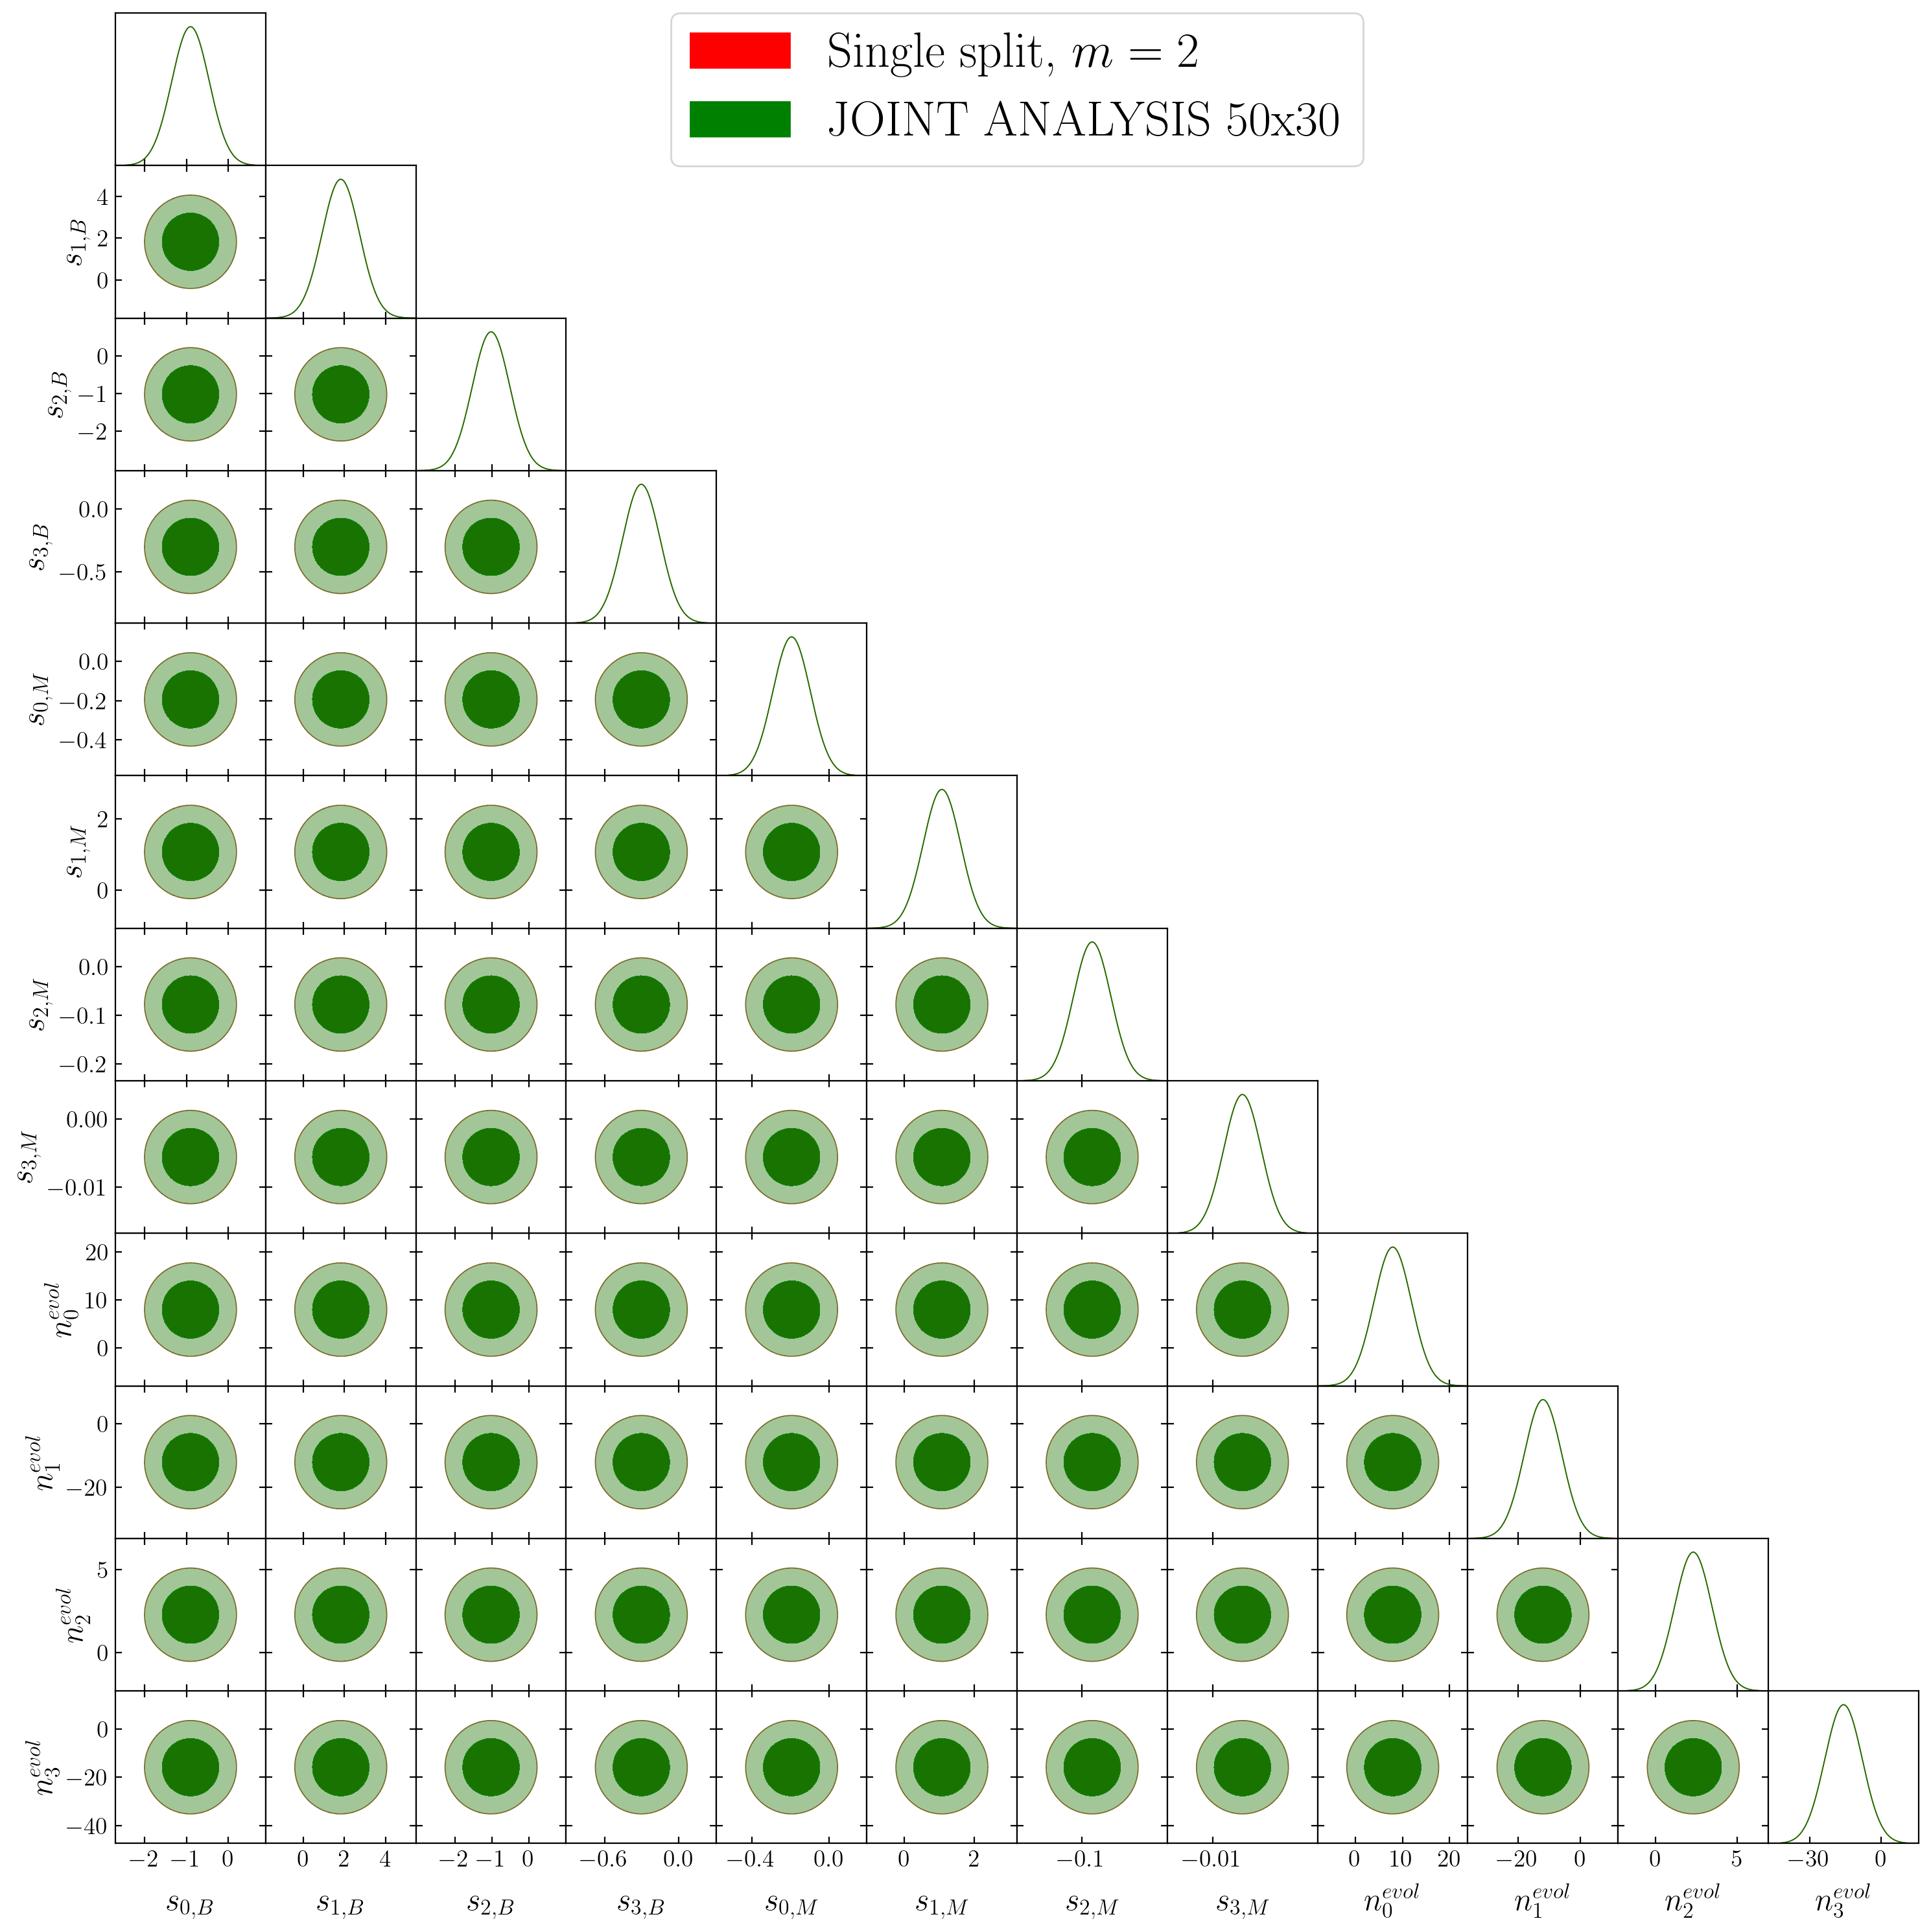

In [163]:
# Triangle plot

mean_joint = params_fid_
mean_50 = params_fid_50[:-7]

sB_names = ['s'+str(int(i))+'B' for i in np.arange(len(sB_4fit50))]
sM_names = ['s'+str(int(i))+'M' for i in np.arange(len(sM_4fit))]

sB_labels=[r's_{'+str(i)+r',B}' for i in np.arange(len(sB_4fit50))]
sM_labels=[r's_{'+str(i)+r',M}' for i in np.arange(len(sM_4fit))]

num_names = ['n'+str(int(i)) for i in np.arange(len(num_fit))]

num_labels=[r'n_{'+str(i)+r'}^{evol}' for i in np.arange(len(num_fit))]

param_names = sB_names + sM_names + num_names 
labels = sB_labels + sM_labels + num_labels 

GaussDist_joint_sbias_nevol_fit_ = GaussianND(mean_joint, Sigma_Matrix_Joint50x30_[:-9,:-9], labels = labels, names = param_names)
GaussDist_50_sbias_nevol_fit = GaussianND(mean_50, Sigma_Matrix_50[:-7,:-7], labels = labels, names = param_names)

g = plots.get_subplot_plotter(width_inch=15)
g.settings.legend_frame = True
g.settings.alpha_filled_add=0.9
g.settings.legend_fontsize=32
g.settings.axes_fontsize=18
g.settings.axes_labelsize=22
g.settings.axis_tick_max_labels=6

g.triangle_plot([GaussDist_50_sbias_nevol_fit, GaussDist_joint_sbias_nevol_fit_], param_names, 
                filled=True, 
                legend_labels=[r'Single split, $m=2$', r'JOINT ANALYSIS 50x30'],
                contour_colors=['red', 'green'])

In [164]:
np.shape(params_fid), np.shape(params_fid_30)

((25,), (19,))

In [165]:
# Delete rows and columns alien to the 30x70 split

nind = list(range(0,4))

Sigma_Matrix_Joint50x30_ = Sigma_Matrix_Joint50x30

Sigma_Matrix_Joint50x30_ = np.delete(arr=Sigma_Matrix_Joint50x30_, obj=nind, axis=0)
Sigma_Matrix_Joint50x30_ = np.delete(arr=Sigma_Matrix_Joint50x30_, obj=nind, axis=1)

np.shape(Sigma_Matrix_Joint50x30_)

(21, 21)

In [166]:
# Delete elements of params_fid

params_fid_ = params_fid[:-9]

params_fid_ = np.delete(arr=params_fid_, obj=nind, axis=0)

np.shape(params_fid_)

(12,)

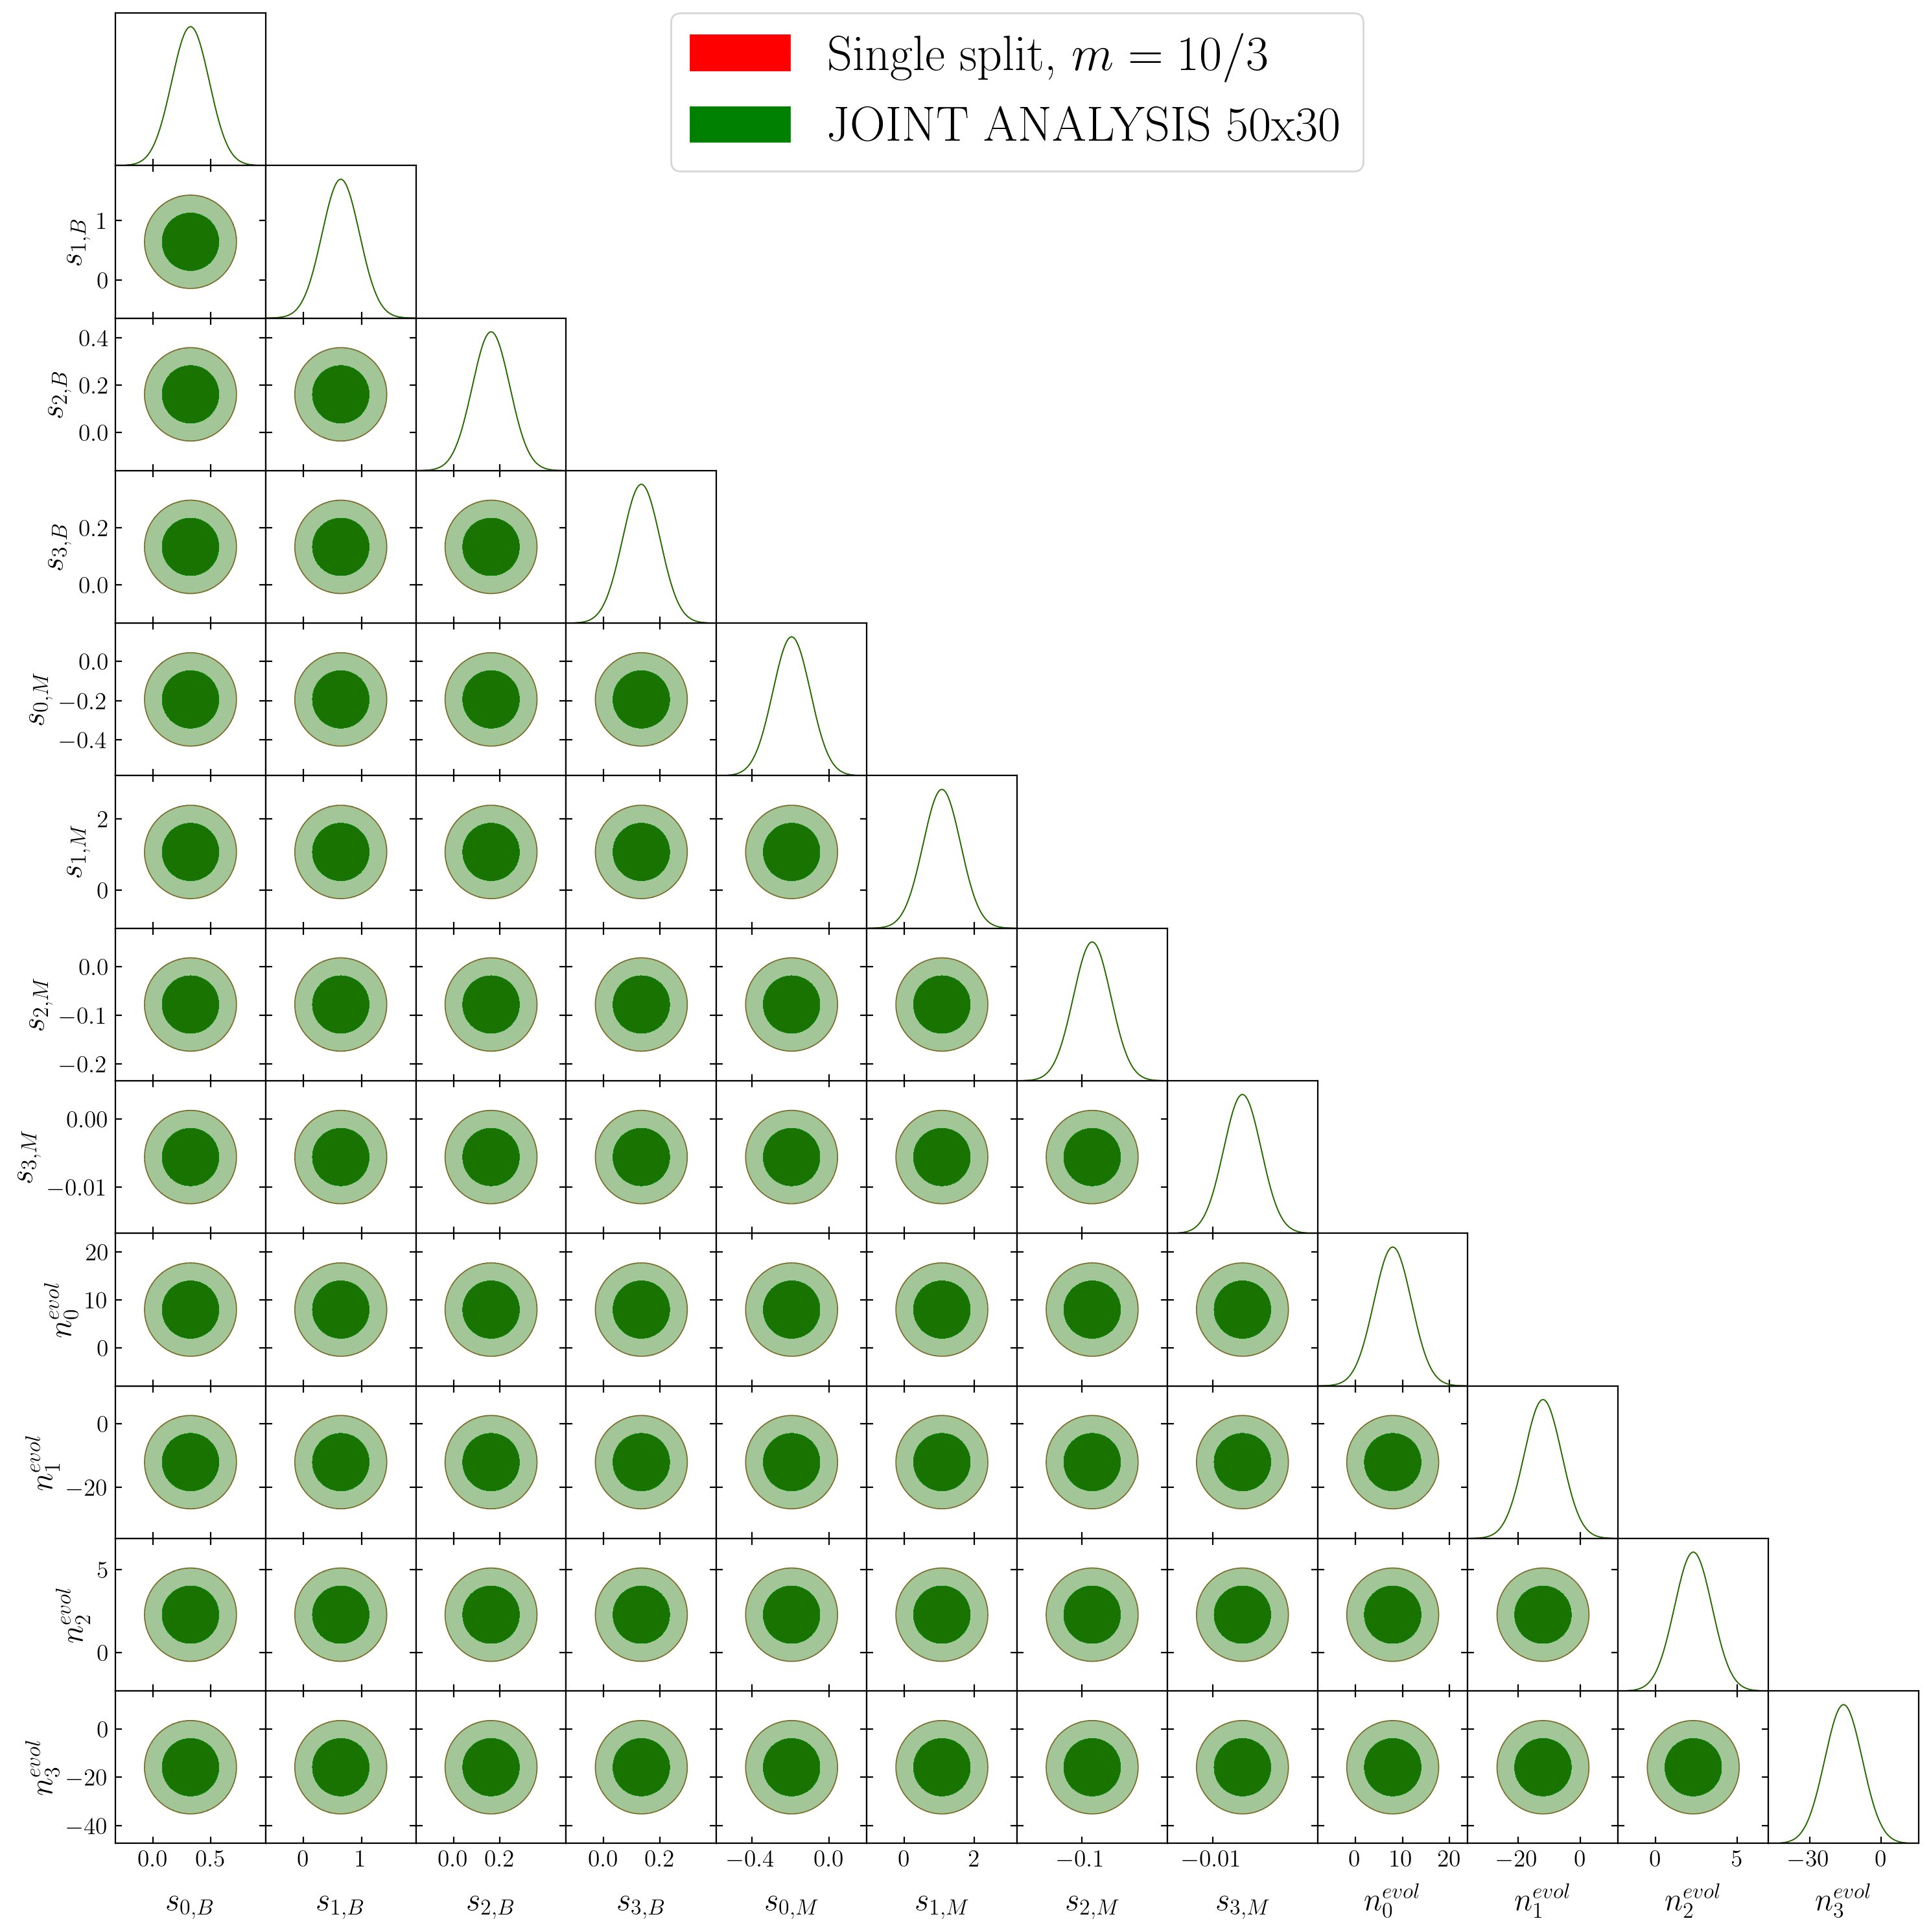

In [167]:
# Triangle plot

mean_joint = params_fid_
mean_30 = params_fid_30[:-7]

sB_names = ['s'+str(int(i))+'B' for i in np.arange(len(sB_4fit50))]
sM_names = ['s'+str(int(i))+'M' for i in np.arange(len(sM_4fit))]

sB_labels=[r's_{'+str(i)+r',B}' for i in np.arange(len(sB_4fit50))]
sM_labels=[r's_{'+str(i)+r',M}' for i in np.arange(len(sM_4fit))]

num_names = ['n'+str(int(i)) for i in np.arange(len(num_fit))]

num_labels=[r'n_{'+str(i)+r'}^{evol}' for i in np.arange(len(num_fit))]

param_names = sB_names + sM_names + num_names 
labels = sB_labels + sM_labels + num_labels 

GaussDist_joint_sbias_nevol_fit_ = GaussianND(mean_joint, Sigma_Matrix_Joint50x30_[:-9,:-9], labels = labels, names = param_names)
GaussDist_30_sbias_nevol_fit = GaussianND(mean_30, Sigma_Matrix_30[:-7,:-7], labels = labels, names = param_names)

g = plots.get_subplot_plotter(width_inch=15)
g.settings.legend_frame = True
g.settings.alpha_filled_add=0.9
g.settings.legend_fontsize=32
g.settings.axes_fontsize=18
g.settings.axes_labelsize=22
g.settings.axis_tick_max_labels=6

g.triangle_plot([GaussDist_30_sbias_nevol_fit, GaussDist_joint_sbias_nevol_fit_], param_names, 
                filled=True, 
                legend_labels=[r'Single split, $m=10/3$', r'JOINT ANALYSIS 50x30'],
                contour_colors=['red', 'green'])

In [168]:
np.shape(Sigma_Matrix_Joint50x30), np.shape(Sigma_Matrix_50)

((25, 25), (19, 19))

In [169]:
# Delete rows and columns alien to the 50x50 split

nind = list(range(0,16)) + list(range(18,20))

Sigma_Matrix_Joint50x30_ = Sigma_Matrix_Joint50x30

Sigma_Matrix_Joint50x30_ = np.delete(arr=Sigma_Matrix_Joint50x30_, obj=nind, axis=0)
Sigma_Matrix_Joint50x30_ = np.delete(arr=Sigma_Matrix_Joint50x30_, obj=nind, axis=1)

np.shape(Sigma_Matrix_Joint50x30_)

(7, 7)

In [170]:
# Delete elements of params_fid

params_fid_ = params_fid

params_fid_ = np.delete(arr=params_fid_, obj=nind, axis=0)

np.shape(params_fid_)

(7,)

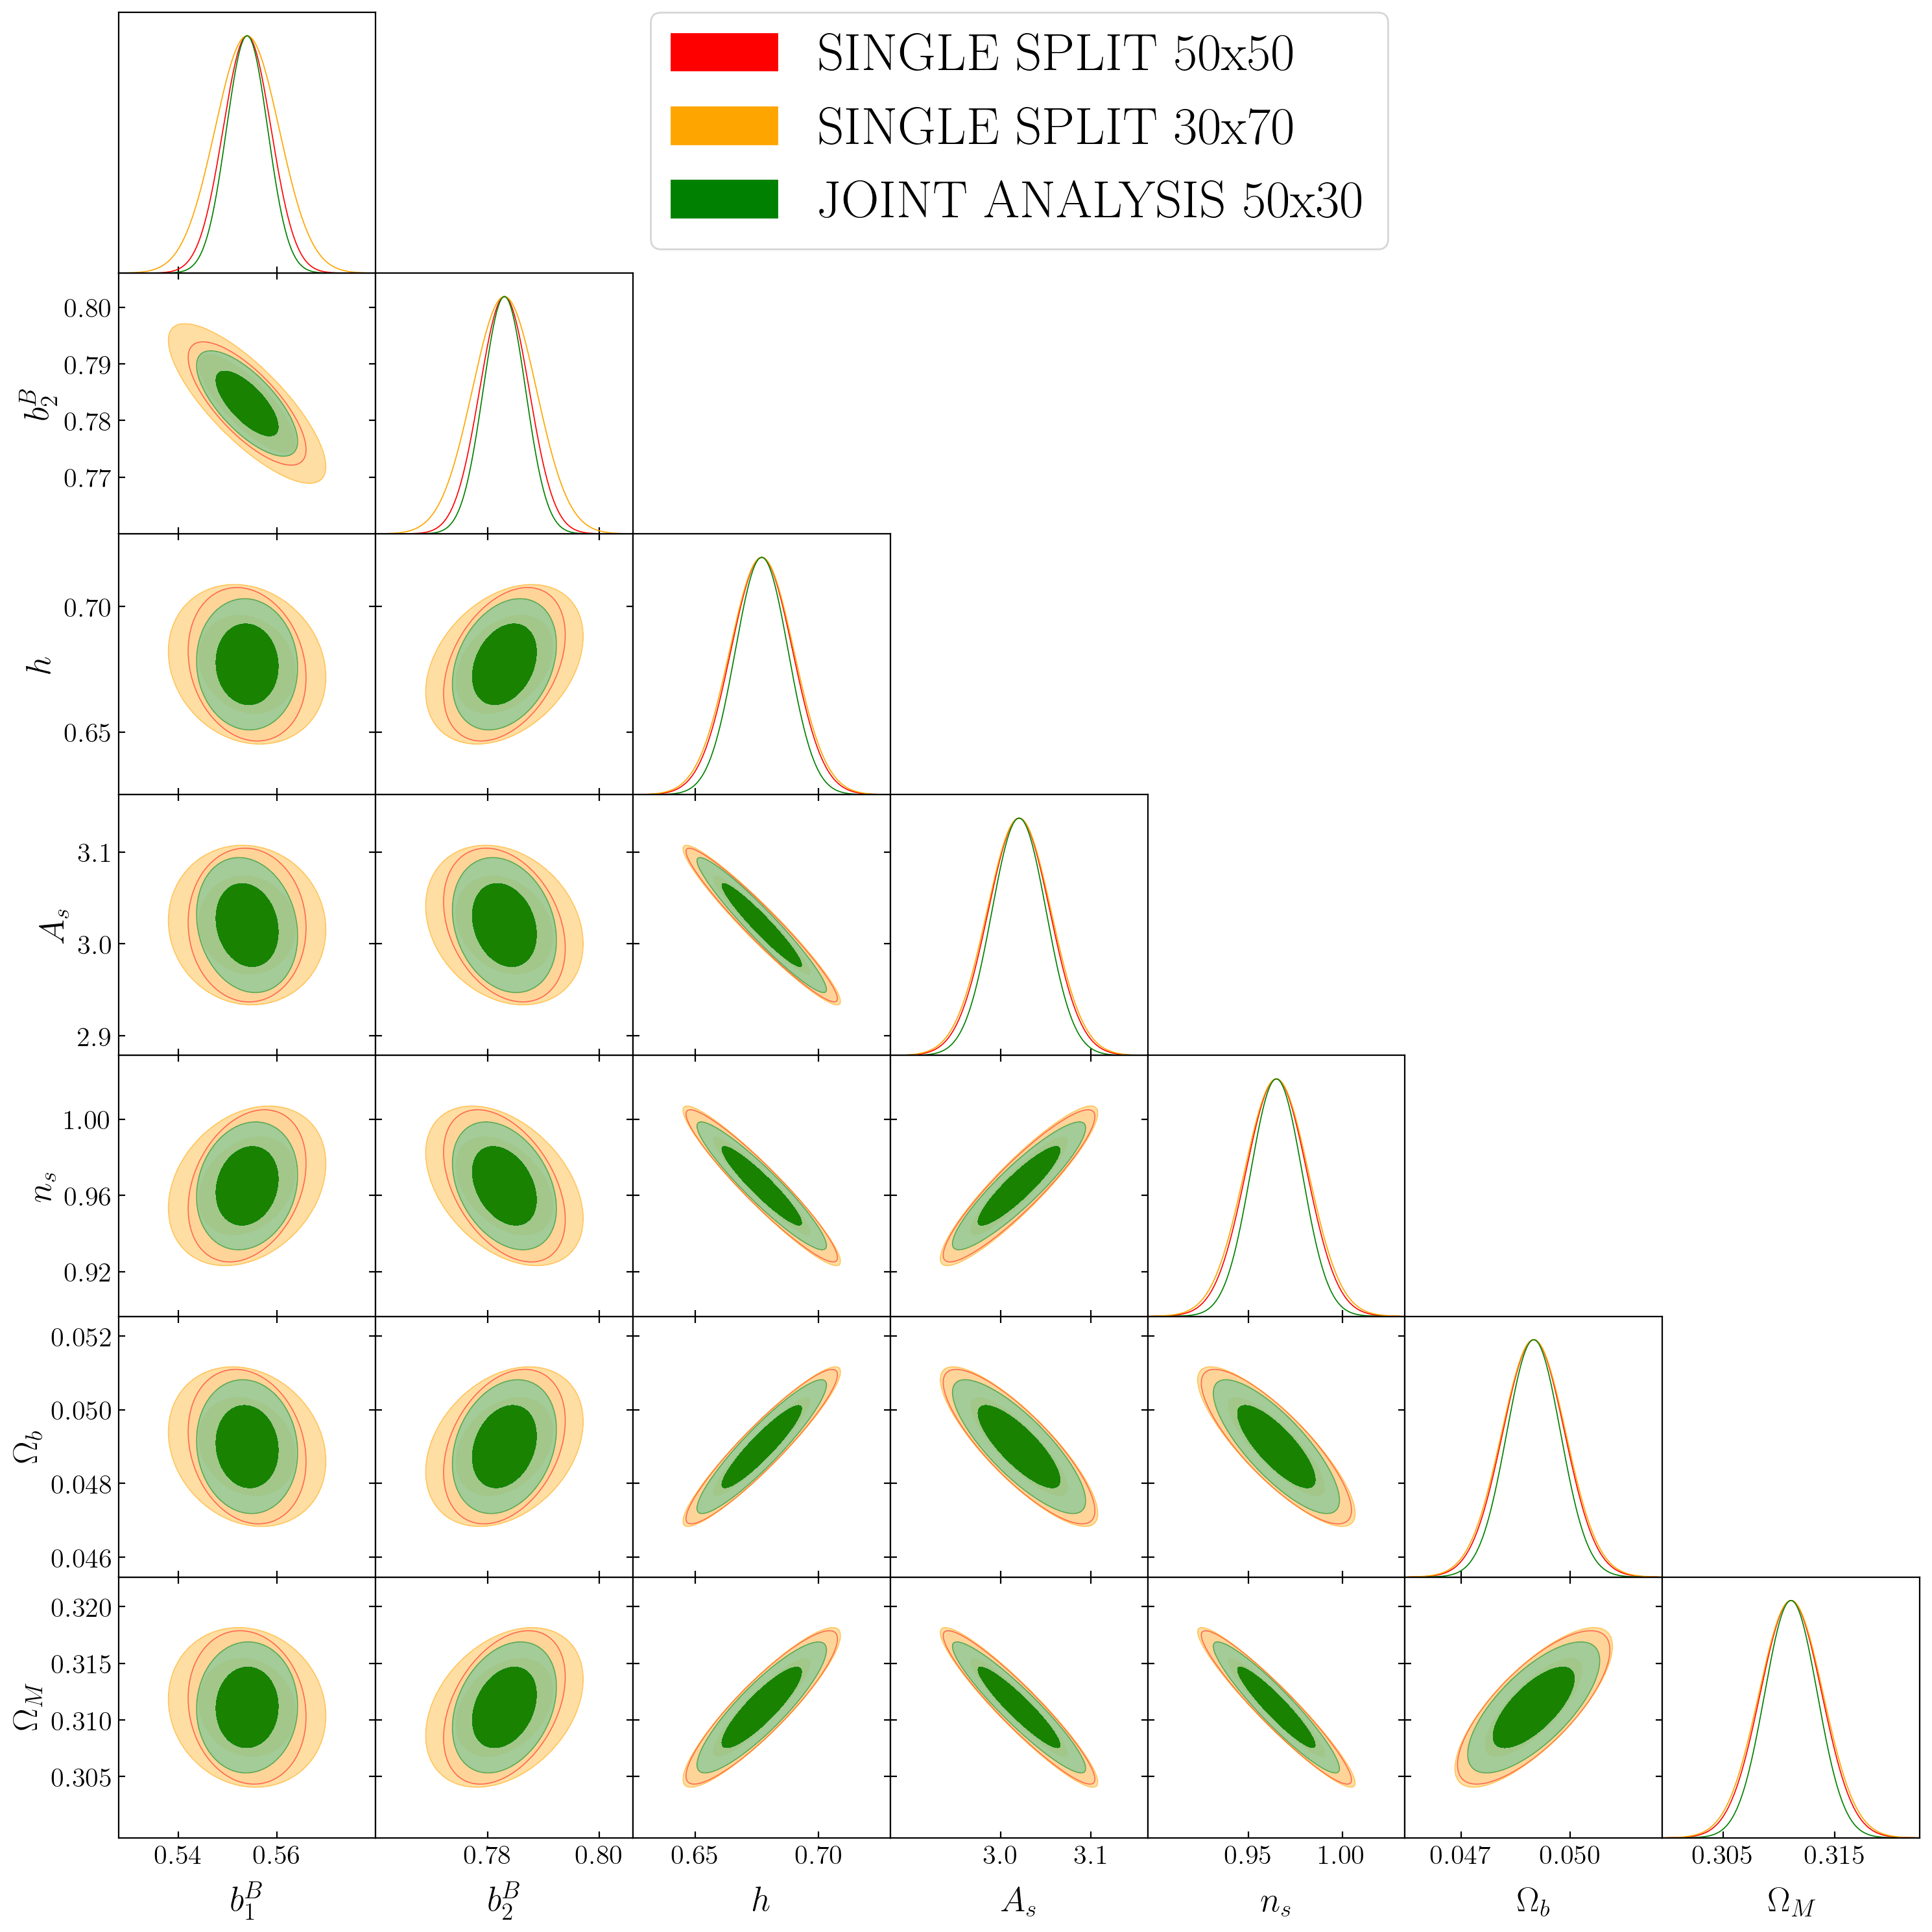

In [171]:
# Triangle plot: GALAXY BIAS AND COSMIC PARAMETERS

mean_50 = params_fid_

gbias_names = ['b1B_m1', 'b2B_m1']
cosmic_names = ['h', 'As', 'ns', 'Ob', 'OM']

gbias_labels = [r'b_1^{B}', r'b_2^{B}']
cosmic_labels = [r'h', r'A_s', r'n_s', r'\Omega_b', r'\Omega_M']

param_names = gbias_names + cosmic_names
labels = gbias_labels + cosmic_labels

GaussDist_gbias_cosmic_fit = GaussianND(mean_50, Sigma_Matrix_Joint50x30_, labels = labels, names = param_names)
GaussDist_gbias_cosmic_fit_50 = GaussianND(mean_50, Sigma_Matrix_50[12:, 12:], labels = labels, names = param_names)
GaussDist_gbias_cosmic_fit_30 = GaussianND(mean_50, Sigma_Matrix_30[12:, 12:], labels = labels, names = param_names)


g = plots.get_subplot_plotter(width_inch=15)
g.settings.legend_frame = True
g.settings.alpha_filled_add=0.9
g.settings.legend_fontsize=32
g.settings.axes_fontsize=18
g.settings.axes_labelsize=22
g.settings.axis_tick_max_labels=6

g.triangle_plot([GaussDist_gbias_cosmic_fit_50, GaussDist_gbias_cosmic_fit_30, GaussDist_gbias_cosmic_fit], param_names, 
                filled=True, 
                legend_labels=['SINGLE SPLIT 50x50', 'SINGLE SPLIT 30x70','JOINT ANALYSIS 50x30'],
                contour_colors=['red', 'orange', 'green'])

# JOINT ANALYSIS WITH ONE POPULATION (FAINT). 

### 50x50 vs 30x70 SPLITTINGS.

We run the analysis combining two different population splittings, combining the information as if they were two independent experiments. We include the cross correlations between the observables but assume the parameters of each population are independent. The signal looks like:

$$ \vec{\xi}(z,d) = (\{\xi_l^{\mathrm{LM}}(z,d)\}_{l=0,1,2,4}, \{\xi_l^{\mathrm{NP}}(z,d)\}_{l=0,1,2,4}) $$



## Derivatives (LOAD FROM FILE)

In [172]:
with open('derivatives.pkl', 'rb') as File:
    derivatives_dict = pk.load(File)
    
derivatives_50x50 = derivatives_dict['split_50x50']
derivatives_30x70 = derivatives_dict['split_30x70']

In [173]:
dsignal_dsbias50 = derivatives_50x50['dsignal_dsbias']

dsignal_dgbias50 = derivatives_50x50['dsignal_dgbias']

dsignal_dcosmic50 = derivatives_50x50['dsignal_dcosmic']

dsignal_dnum50 = derivatives_50x50['dsignal_dnumev']

np.shape(dsignal_dsbias50), np.shape(dsignal_dgbias50), np.shape(dsignal_dcosmic50), np.shape(dsignal_dnum50)

((8, 19, 324), (4, 19, 324), (5, 19, 324), (4, 19, 324))

In [174]:
dsignal_dsbias30 = derivatives_30x70['dsignal_dsbias']

dsignal_dgbias30 = derivatives_30x70['dsignal_dgbias']

dsignal_dcosmic30 = derivatives_30x70['dsignal_dcosmic']

dsignal_dnum30 = derivatives_30x70['dsignal_dnumev']

np.shape(dsignal_dsbias30), np.shape(dsignal_dgbias30), np.shape(dsignal_dcosmic30), np.shape(dsignal_dnum30)

((8, 19, 324), (4, 19, 324), (5, 19, 324), (4, 19, 324))

In [175]:
dsignal_dtheta50 = np.concatenate([dsignal_dsbias50, dsignal_dnum50, dsignal_dgbias50, dsignal_dcosmic50])

np.shape(dsignal_dtheta50)

(21, 19, 324)

In [176]:
dsignal_dtheta30 = np.concatenate([dsignal_dsbias30, dsignal_dnum30, dsignal_dgbias30, dsignal_dcosmic30])

np.shape(dsignal_dtheta30)

(21, 19, 324)

REMOVE BRIGHT POPULATION, ODD MULTIPOLES

In [177]:
n_sep = len(dist[0])
n_signals = int(len(dsignal_dtheta50[0,0])/n_sep)
ind_to_remove_bright_odd = list(range(0*n_sep, 2*n_sep)) + list(range(3*n_sep, 6*n_sep)) + list(range(8*n_sep, 9*n_sep))

dsignal_dtheta50 = np.delete(dsignal_dtheta50, ind_to_remove_bright_odd, axis=2)
dsignal_dtheta30 = np.delete(dsignal_dtheta30, ind_to_remove_bright_odd, axis=2)

np.shape(dsignal_dtheta50), np.shape(dsignal_dtheta30)


((21, 19, 108), (21, 19, 108))

REMOVE HEXADECAPOLE FROM 50x50 split

In [178]:
n_sep = len(dist[0])
n_signals = int(len(dsignal_dtheta50[0,0])/n_sep)
ind_to_remove_hexa = list(range(7*n_sep, 8*n_sep))

print('Number of separations = ', n_sep)
print('Number of signals = ', n_signals)
print('Indices to remove = ', ind_to_remove_hexa)

Number of separations =  36
Number of signals =  3
Indices to remove =  [252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287]


In [179]:
dsignal_dsB50 = np.concatenate([dsignal_dsbias50[:4], np.zeros_like(dsignal_dsbias50[:4])], axis=2)
dsignal_dsB30 = np.concatenate([np.zeros_like(dsignal_dsbias30[:4]), dsignal_dsbias30[:4]], axis=2)

dsignal_dsM = np.concatenate([dsignal_dsbias50[4:], dsignal_dsbias30[4:]], axis=2)
dsignal_dnum = np.concatenate([dsignal_dnum50, dsignal_dnum30], axis=2)
dsignal_dgbias50 = np.concatenate([dsignal_dgbias50, np.zeros_like(dsignal_dgbias50[:4])], axis=2)
dsignal_dgbias30 = np.concatenate([np.zeros_like(dsignal_dgbias30[:4]), dsignal_dgbias30], axis=2)
dsignal_dcosmic = np.concatenate([dsignal_dcosmic50, dsignal_dcosmic30], axis=2)

In [180]:
dsignal_dtheta_multi_ = np.concatenate([dsignal_dsB50, dsignal_dsB30, dsignal_dsM, dsignal_dnum, dsignal_dgbias50[2:], dsignal_dgbias30[2:], dsignal_dcosmic])

ind_to_remove = ind_to_remove_bright_odd + ind_to_remove_hexa + list(range(0*n_sep + 324, 2*n_sep + 324)) + list(range(3*n_sep + 324, 6*n_sep + 324)) + list(range(8*n_sep + 324, 9*n_sep + 324))

dsignal_dtheta_multi = np.delete(dsignal_dtheta_multi_, ind_to_remove, axis=2)


np.shape(dsignal_dtheta_multi_), np.shape(dsignal_dtheta_multi)

((25, 19, 648), (25, 19, 180))

In [181]:
len(ind_to_remove), len(ind_to_remove_faint_odd), len(ind_to_remove_hexa)

(468, 216, 36)

## Covariance Matrix

In [182]:
# Create the PRIORS Cov Matrix for sB, sM, num

errB = [5e-1, 5e-1] 
errF = [5e-1, 5e-1]

num_fit = np.array([7.94599872, -12.03752386, 2.29927261, -15.83887364])

sB_4fit50 = np.array([-0.90110745,  1.82300205, -1.01878441, -0.30342325])
sB_4fit30 = np.array([0.32517601, 0.64417733, 0.16141876, 0.13330362])

sM_4fit = np.array([-0.19376092,  1.07473357, -0.07806244, -0.00558004])

dsB_50 = sB_4fit50 * errB[0] 
dsB_30 = sB_4fit30 * errB[0] 

dsM = sM_4fit * errF[0]

dnum = num_fit * errB[1]

Cov_prior_all = np.diag(np.concatenate([dsB_50**2, dsB_30**2, dsM**2, dnum**2]))

Inv_Cov_prior_all_ = np.linalg.inv(Cov_prior_all)

Inv_Cov_prior_all = np.zeros([len(dsignal_dtheta_multi), len(dsignal_dtheta_multi)])
Inv_Cov_prior_all[:len(Inv_Cov_prior_all_), :len(Inv_Cov_prior_all_)] = Inv_Cov_prior_all_

np.shape(Cov_prior_all), np.shape(Inv_Cov_prior_all)

((16, 16), (25, 25))

In [183]:
Cov_Multipoles_Joint50x30_ = fm.cov_matrix_joint(d=dist[0], z_bins=z_bins, small_off_diagonal=True, splits=[50,30], rtol=1e-4, contributions='CC')

print('\n ... Remove the BRIGHT POPULATION, ODD MULTIPOLES and one HEXADECAPOLE from 50x50 split ... \n')

Cov_Multipoles_Joint50x30 = np.delete(Cov_Multipoles_Joint50x30_, ind_to_remove, axis=1)
Cov_Multipoles_Joint50x30 = np.delete(Cov_Multipoles_Joint50x30, ind_to_remove, axis=2)

np.shape(Cov_Multipoles_Joint50x30_), np.shape(Cov_Multipoles_Joint50x30)


 ... Loading Covariance Matrices (Joint-splittings Analysis) [CC] [MONOBB, MONOBF, MONOFF, DIPBF, QUADBB, QUADBF, QUADFF, HEXAT, OCTBF] ... 




 ... Remove the BRIGHT POPULATION, ODD MULTIPOLES and one HEXADECAPOLE from 50x50 split ... 



((19, 648, 648), (19, 180, 180))

In [184]:
# Check if Cov Matrices are symmetric:

for n, z in enumerate(z_bins):
    print(n, np.allclose(Cov_Multipoles_Joint50x30_[n], Cov_Multipoles_Joint50x30_[n].T, rtol = 1e-15), np.allclose(Cov_Multipoles_Joint50x30[n], Cov_Multipoles_Joint50x30[n].T, rtol = 1e-15))

0 True True
1 True True
2 True True
3 True True
4 True True
5 True True
6 True True
7 True True
8 True True
9 True True
10 True True
11 True True
12 True True
13 True True
14 True True
15 True True
16 True True
17 True True
18 True True


In [185]:
# Load the Covariance Matrix of the multipoles

Inv_Cov_Multipoles_Joint50x30_ = np.linalg.pinv(Cov_Multipoles_Joint50x30)

# Symmetrize the matrix

Inv_Cov_Multipoles_Joint50x30 = [0.5 * (Inv_Cov_Multipoles_Joint50x30_[i] + Inv_Cov_Multipoles_Joint50x30_[i].T) for i in range(len(z_bins))]

In [186]:
# Check if Inverse Cov Matrices are symmetric:

for n, z in enumerate(z_bins):
    print(n, np.allclose(Inv_Cov_Multipoles_Joint50x30_[n], Inv_Cov_Multipoles_Joint50x30_[n].T, rtol = 1e-1), np.allclose(Inv_Cov_Multipoles_Joint50x30[n], Inv_Cov_Multipoles_Joint50x30[n].T, rtol = 1e-3))

0 True True
1 True True
2 True True
3 True True
4 True True
5 True True
6 True True
7 True True
8 True True
9 True True
10 True True
11 True True
12 True True
13 True True
14 True True
15 True True
16 True True
17 True True
18 True True


In [187]:
# Build the Fisher Matrix

Fisher_Matrix_Joint50x30_ = fm.fisher_matrix(d_signal = dsignal_dtheta_multi, inv_cov = Inv_Cov_Multipoles_Joint50x30_, z_bins = z_bins)
Fisher_Matrix_Joint50x30 = Fisher_Matrix_Joint50x30_ + Inv_Cov_prior_all

np.shape(Fisher_Matrix_Joint50x30)


 ... Computing the Fisher Matrix ... 

Signal & Cov must be given as functions (z,d) and (z,d,d') respectively. 


 ... Success! ... 



(25, 25)

In [188]:
print('\n'.join(['\t'.join([str(cell) for cell in row]) for row in Fisher_Matrix_Joint50x30[:8,:8]]))

4.92614091333159	0.0	0.0	0.0	0.0	0.0	0.0	0.0
0.0	1.2036096949339048	0.0	0.0	0.0	0.0	0.0	0.0
0.0	0.0	3.853855353417002	0.0	0.0	0.0	0.0	0.0
0.0	0.0	0.0	43.44724867655685	0.0	0.0	0.0	0.0
0.0	0.0	0.0	0.0	37.82883752123923	0.0	0.0	0.0
0.0	0.0	0.0	0.0	0.0	9.639380358545878	0.0	0.0
0.0	0.0	0.0	0.0	0.0	0.0	153.5154103270564	0.0
0.0	0.0	0.0	0.0	0.0	0.0	0.0	225.10031603189591


In [189]:
print('\n'.join(['\t'.join([str(cell) for cell in row]) for row in Fisher_Matrix_Joint50x30[8:16,8:16]]))

106.5436609609975	0.0	0.0	0.0	0.0	0.0	0.0	0.0
0.0	3.4630468121011844	0.0	0.0	0.0	0.0	0.0	0.0
0.0	0.0	656.4108446886339	0.0	0.0	0.0	0.0	0.0
0.0	0.0	0.0	128465.16144918442	0.0	0.0	0.0	0.0
0.0	0.0	0.0	0.0	0.06335239092003143	0.0	0.0	0.0
0.0	0.0	0.0	0.0	0.0	0.02760486765761777	0.0	0.0
0.0	0.0	0.0	0.0	0.0	0.0	0.7566221650091618	0.0
0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.01594451829440951


In [190]:
print('\n'.join(['\t'.join([str(cell) for cell in row]) for row in Fisher_Matrix_Joint50x30[16:,16:]]))

28848558.38401183	7816583.347529989	-21125744.92844474	-5639522.307888816	1703188.9921571158	507757.33334251156	368851.4375792373	-6419955.343624268	4189490.209913985
7816583.34752999	2810391.4759957637	-5639522.307888816	-1947413.3056449248	649687.4692204435	208101.81679153713	96184.67894239174	-2400476.3942183703	1155743.1215071294
-21125744.928444754	-5639522.307888817	20844925.335497547	6401732.578460247	2584219.272750228	983039.3291204759	-96544.19635687595	-9005189.803414037	1377146.4530369674
-5639522.307888816	-1947413.3056449231	6401732.578460248	2585112.5665906398	1164357.6958818717	439666.721788976	-32407.548114802008	-4067619.8574485797	837548.1111600306
1703188.9921572662	649687.4692204641	2584219.272750119	1164357.695881856	4451926.567479522	1403866.579901229	652840.8957414094	-16744544.154120816	6097571.815559811
507757.3333425464	208101.81679154164	983039.3291204498	439666.7217889716	1403866.5799012273	462786.35975209397	170912.3269475167	-5131360.075355248	1918162.5464

In [191]:
print(np.allclose(Fisher_Matrix_Joint50x30, Fisher_Matrix_Joint50x30.T, rtol=1e-6))

True


In [192]:
print(np.allclose(Fisher_Matrix_Joint50x30[:-5,:-5], Fisher_Matrix_Joint50x30[:-5,:-5].T, rtol=1e-6))

True


In [193]:
np.linalg.det(Fisher_Matrix_Joint50x30)

3.1572419355304885e+67

## Constraints

In [194]:
#Absolute Errors

Sigma_Matrix_Joint50x30 = np.linalg.inv(Fisher_Matrix_Joint50x30)

Abs_Errors_all_Joint = np.sqrt(np.diag(Sigma_Matrix_Joint50x30))

# Fiducial values

sB_fit = np.concatenate([sB_4fit50, sB_4fit30]) 
gbias_fit = np.concatenate([np.array([0.554, 0.783]), np.array([0.554, 0.783])])
cosmic_fid = np.fromiter(params_dict0.values(), dtype=float)
cosmic_fid[1] = np.log(10**10 * cosmic_fid[1])

params_fid = np.concatenate([sB_fit, sM_4fit, num_fit, gbias_fit, cosmic_fid])

# Relative errors

Rel_Errors_all_Joint = np.abs(Abs_Errors_all_Joint/params_fid)

par_errors_all_Joint = Rel_Errors_all_Joint * 100

print()
print('------------ Relative errors * 100 ------------' )
print()
print('sB_50 = ', par_errors_all_Joint[0:int(len(sB_fit)/2)])
print()
print('sB_30 = ', par_errors_all_Joint[int(len(sB_fit)/2):len(sB_fit)])
print()
print('s_model = ', par_errors_all_Joint[len(sB_fit):len(sB_fit)+len(sM_4fit)])
print()
print('number = ', par_errors_all_Joint[(len(sB_fit)+len(sM_4fit)):(len(sB_fit)+len(sM_4fit)+len(num_fit))])
print()
print('gbias_50 = ', par_errors_all_Joint[((len(sB_fit)+len(sM_4fit)+len(num_fit))):((len(sB_fit)+len(sM_4fit)+len(num_fit))+int(len(gbias_fit)/2))])
print()
print('gbias_30 = ', par_errors_all_Joint[(len(sB_fit)+len(sM_4fit)+len(num_fit)+int(len(gbias_fit)/2)):((len(sB_fit)+len(sM_4fit)+len(num_fit))+int(len(gbias_fit)))])
print()
print('cosmic = ', par_errors_all_Joint[((len(sB_fit)+len(sM_4fit)+len(num_fit))+len(gbias_fit)):((len(sB_fit)+len(sM_4fit)+len(num_fit))+len(gbias_fit) + len(cosmic_fid))])
print()


------------ Relative errors * 100 ------------

sB_50 =  [50. 50. 50. 50.]

sB_30 =  [50. 50. 50. 50.]

s_model =  [50. 50. 50. 50.]

number =  [50. 50. 50. 50.]

gbias_50 =  [0.21440306 0.35470457]

gbias_30 =  [0.26551231 0.35881853]

cosmic =  [1.84188555 1.13643791 1.46491187 1.91989557 0.80318947]



In [195]:
np.linalg.det(Fisher_Matrix_Joint50x30), np.linalg.det(Sigma_Matrix_Joint50x30)

(3.1572419355304885e+67, 3.1673214166655415e-68)

In [196]:
def isPSD(A, tol=1e-4):
    E = np.linalg.eigvals(A)
    return E, np.all(E > -tol)

# Example usage:
# Your matrix
A = np.array([[1, 2], [2, 4]])
# Check if A is positive semi-definite
print(isPSD(A))

(array([0., 5.]), True)


In [197]:
print(isPSD(Fisher_Matrix_Joint50x30[:-5,:-5], tol=1e-10))

(array([4.99566762e+07, 4.03017016e+06, 1.20718932e+05, 9.81422454e+05,
       4.92614091e+00, 1.20360969e+00, 3.85385535e+00, 4.34472487e+01,
       3.78288375e+01, 9.63938036e+00, 1.53515410e+02, 2.25100316e+02,
       1.06543661e+02, 3.46304681e+00, 6.56410845e+02, 1.28465161e+05,
       6.33523909e-02, 2.76048677e-02, 7.56622165e-01, 1.59445183e-02]), True)


In [198]:
print(isPSD(Sigma_Matrix_Joint50x30, tol=1e-10))

(array([1.50484146e-03, 3.06990334e-05, 1.45056416e-05, 7.83987185e-06,
       1.05914153e-06, 5.08594310e-07, 3.75193762e-07, 1.99613110e-08,
       1.22714885e-08, 2.02998659e-01, 8.30834119e-01, 2.59480419e-01,
       2.30164172e-02, 2.64348594e-02, 1.03741108e-01, 6.51400402e-03,
       4.44246378e-03, 9.38582353e-03, 2.88763062e-01, 1.52343613e-03,
       7.78421160e-06, 1.57847239e+01, 3.62254952e+01, 1.32166363e+00,
       6.27174795e+01]), True)


In [199]:
# Perform Singular Value Decomposition

U, s, Vh = np.linalg.svd(Fisher_Matrix_Joint50x30)

# s contains the singular values of A
print("Singular values of A:", s)

# Calculate the condition number
condition_number = s[0] / s[-1]
print("Condition number of A:", condition_number)

Singular values of A: [8.14897070e+07 5.00969099e+07 2.66528951e+06 1.96620367e+06
 9.44160878e+05 1.28465161e+05 1.27553105e+05 6.89386950e+04
 3.25743155e+04 6.64521830e+02 6.56410845e+02 2.25100316e+02
 1.53515410e+02 1.06543661e+02 4.34472487e+01 3.78288375e+01
 9.63938036e+00 4.92614091e+00 3.85385535e+00 3.46304681e+00
 1.20360969e+00 7.56622165e-01 6.33523909e-02 2.76048677e-02
 1.59445183e-02]
Condition number of A: 5110829032.436813


In [200]:
# Create Σ+ (the pseudo-inverse of the diagonal matrix Σ)
S_plus = np.zeros((Fisher_Matrix_Joint50x30.shape[0], Fisher_Matrix_Joint50x30.shape[1])).T
S_plus[:s.shape[0], :s.shape[0]] = np.linalg.inv(np.diag(s))

# Compute the pseudo-inverse of A
A_plus = Vh.T @ S_plus @ U.T

# Verify by multiplying with the original matrix A
identity_matrix = Fisher_Matrix_Joint50x30 @ A_plus

In [201]:
np.allclose(A_plus, Sigma_Matrix_Joint50x30, rtol=1e-20)

True

In [202]:
np.linalg.det(A_plus), np.linalg.det(Sigma_Matrix_Joint50x30)

(3.1673214166645515e-68, 3.1673214166655415e-68)

In [203]:
np.prod(s), np.linalg.det(Fisher_Matrix_Joint50x30)

(3.1572419355311374e+67, 3.1572419355304885e+67)

# SINGLE SPLIT 

### $m = 2 \,\rightarrow\,$ $50\%$ Brigth - $50\%$ Faint

In [204]:
len(dsignal_dgbias50[1,1])/2

324.0

In [205]:
dsignal_dtheta_fit_all50 = np.concatenate([dsignal_dsbias50, dsignal_dnum50, dsignal_dgbias50[2:,:,:324], dsignal_dcosmic50])

np.shape(dsignal_dtheta_fit_all50)

(19, 19, 324)

In [206]:
dsignal_dtheta_fit_all50 = np.delete(dsignal_dtheta_fit_all50, ind_to_remove_bright_odd, axis=2)

np.shape(dsignal_dtheta_fit_all50)

(19, 19, 108)

In [207]:
# Create the Cov Matrix for sB, sF, num

Cov_priors_50 = np.diag(np.concatenate([dsB_50**2, dsM**2, dnum**2]))

Inv_Cov_prior_50_ = np.linalg.inv(Cov_priors_50)

Inv_Cov_prior_50 = np.zeros([len(dsignal_dtheta_fit_all50), len(dsignal_dtheta_fit_all50)])
Inv_Cov_prior_50[:len(Inv_Cov_prior_50_), :len(Inv_Cov_prior_50_)] = Inv_Cov_prior_50_

np.shape(Cov_priors_50)

(12, 12)

In [208]:
Cov_Multipoles_50 = fm.cov_matrix_survey(d = dist[0], z_bins = z_bins, split=[50, 50], small_off_diagonal = True, rtol=1e-10)

print('\n ... Remove the BRIGHT POPULATION and ODD MULTIPOLES from 50x50 split ... \n')

Cov_Even_Multipoles_50 = np.delete(Cov_Multipoles_50, ind_to_remove_bright_odd, axis=1)
Cov_Even_Multipoles_50 = np.delete(Cov_Even_Multipoles_50, ind_to_remove_bright_odd, axis=2)

np.shape(Cov_Even_Multipoles_50)


 ... Loading Covariance Matrices [MONOBB, MONOBF, MONOFF, DIPBF, QUADBB, QUADBF, QUADFF, HEXAT, OCTBF] ... 


 ... Success! ... 


 ... Remove the BRIGHT POPULATION and ODD MULTIPOLES from 50x50 split ... 



(19, 108, 108)

In [209]:
# Fisher Matrix + prior

Inv_Cov_Multipoles_50 = np.array([np.linalg.inv(Cov_Even_Multipoles_50[i]) for i,_ in enumerate(z_bins)])

Fisher_Matrix_50_ = fm.fisher_matrix(d_signal = dsignal_dtheta_fit_all50, inv_cov = Inv_Cov_Multipoles_50, z_bins = z_bins)

Fisher_Matrix_50 = Fisher_Matrix_50_ + Inv_Cov_prior_50

np.shape(Fisher_Matrix_50)


 ... Computing the Fisher Matrix ... 

Signal & Cov must be given as functions (z,d) and (z,d,d') respectively. 


 ... Success! ... 



(19, 19)

In [210]:
print(np.allclose(Fisher_Matrix_50, Fisher_Matrix_50.T, rtol=1e-11))

True


In [211]:
np.linalg.det(Fisher_Matrix_50)

1.653036682443271e+46

In [212]:
Sigma_Matrix_50 = np.linalg.inv(Fisher_Matrix_50)

#Absolute Errors

Abs_Errors_all_50 = np.sqrt(np.diag(Sigma_Matrix_50))

# Fiducial values

sbias_fit_50 = np.concatenate([sB_4fit50, sM_4fit])
gbias_fit_50 = np.concatenate([np.array([0.554, 0.783])])
cosmic_fid = np.fromiter(params_dict0.values(), dtype=float)
cosmic_fid[1] = np.log(10**10 * cosmic_fid[1])

params_fid_50 = np.concatenate([sbias_fit_50, num_fit, gbias_fit_50, cosmic_fid])

# Relative errors

Rel_Errors_all_50 = np.abs(Abs_Errors_all_50/params_fid_50)

par_errors_all_50 = Rel_Errors_all_50 * 100

print()
print('------------ Relative errors * 100 ------------' )
print()
print('sB = ', par_errors_all_50[0:int(len(sbias_fit_50)/2)])
print()
print('smodel = ', par_errors_all_50[int(len(sbias_fit_50)/2):len(sbias_fit_50)])
print()
print('number = ', par_errors_all_50[len(sbias_fit_50):(len(sbias_fit_50) + len(num_fit))])
print()
print('gbias = ', par_errors_all_50[(len(sbias_fit_50) + len(num_fit)):(len(sbias_fit_50) + len(num_fit) + len(gbias_fit_50))])
print()
print('cosmic = ', par_errors_all_50[(len(sbias_fit_50) + len(num_fit)+len(gbias_fit_50)):])


------------ Relative errors * 100 ------------

sB =  [50. 50. 50. 50.]

smodel =  [50. 50. 50. 50.]

number =  [50. 50. 50. 50.]

gbias =  [0.24867974 0.44495619]

cosmic =  [2.3438039  1.4171619  1.8093616  2.49724144 0.9664905 ]


In [213]:
print(np.allclose(Sigma_Matrix_50, Sigma_Matrix_50.T, rtol=1e-20))

True


In [214]:
np.linalg.det(Sigma_Matrix_50)

6.049472529080272e-47

In [215]:
# Perform Singular Value Decomposition

U, s, Vh = np.linalg.svd(Fisher_Matrix_50)

# s contains the singular values of A
print("Singular values of A:", s)

# Calculate the condition number
condition_number = s[0] / s[-1]
print("Condition number of A:", condition_number)

Singular values of A: [6.46073260e+07 2.85437893e+06 1.66563890e+06 1.75178879e+05
 1.28465161e+05 4.63940144e+04 2.38087511e+04 6.56410845e+02
 4.26767657e+02 1.06543661e+02 4.34472487e+01 4.92614091e+00
 3.85385535e+00 3.46304681e+00 1.20360969e+00 7.56622165e-01
 6.33523909e-02 2.76048677e-02 1.59445183e-02]
Condition number of A: 4052008647.433912


In [216]:
# Create Σ+ (the pseudo-inverse of the diagonal matrix Σ)
S_plus = np.zeros((Fisher_Matrix_50.shape[0], Fisher_Matrix_50.shape[1])).T
S_plus[:s.shape[0], :s.shape[0]] = np.linalg.inv(np.diag(s))

# Compute the pseudo-inverse of A
A_plus = Vh.T @ S_plus @ U.T

# Verify by multiplying with the original matrix A
identity_matrix = Fisher_Matrix_50 @ A_plus

In [217]:
np.allclose(A_plus, Sigma_Matrix_50, rtol=1e-20)

True

# SINGLE SPLIT 

### $m = 10/3 \,\rightarrow\,$ $30\%$ Brigth - $70\%$ Faint

In [218]:
len(dsignal_dgbias30[1,1])/2

324.0

In [219]:
dsignal_dtheta_fit_all30 = np.concatenate([dsignal_dsbias30, dsignal_dnum30, dsignal_dgbias30[2:,:,324:], dsignal_dcosmic30])

np.shape(dsignal_dtheta_fit_all30)

(19, 19, 324)

In [220]:
dsignal_dtheta_fit_all30 = np.delete(dsignal_dtheta_fit_all30, ind_to_remove_bright_odd, axis=2)

np.shape(dsignal_dtheta_fit_all30)

(19, 19, 108)

In [221]:
# Create the Cov Matrix for sB, sF, num

Cov_priors_30 = np.diag(np.concatenate([dsB_30**2, dsM**2, dnum**2]))

Inv_Cov_prior_30_ = np.linalg.inv(Cov_priors_30)

Inv_Cov_prior_30 = np.zeros([len(dsignal_dtheta_fit_all30), len(dsignal_dtheta_fit_all30)])
Inv_Cov_prior_30[:len(Inv_Cov_prior_30_), :len(Inv_Cov_prior_30_)] = Inv_Cov_prior_30_

np.shape(Cov_priors_30)

(12, 12)

In [222]:
Cov_Multipoles_30 = fm.cov_matrix_survey(d = dist[0], z_bins = z_bins, split=[30, 70], small_off_diagonal = True, rtol=1e-10)

print('\n ... Remove the BRIGHT POPULATION and ODD MULTIPOLES from 30x70 split ... \n')

Cov_Even_Multipoles_30 = np.delete(Cov_Multipoles_30, ind_to_remove_bright_odd, axis=1)
Cov_Even_Multipoles_30 = np.delete(Cov_Even_Multipoles_30, ind_to_remove_bright_odd, axis=2)

np.shape(Cov_Even_Multipoles_30)


 ... Loading Covariance Matrices [MONOBB, MONOBF, MONOFF, DIPBF, QUADBB, QUADBF, QUADFF, HEXAT, OCTBF] ... 




 ... Success! ... 


 ... Remove the BRIGHT POPULATION and ODD MULTIPOLES from 30x70 split ... 



(19, 108, 108)

In [223]:
# Fisher Matrix + prior

Inv_Cov_Multipoles_30 = np.array([np.linalg.inv(Cov_Even_Multipoles_30[i]) for i,_ in enumerate(z_bins)])

Fisher_Matrix_30_ = fm.fisher_matrix(d_signal = dsignal_dtheta_fit_all30, inv_cov = Inv_Cov_Multipoles_30, z_bins = z_bins)

Fisher_Matrix_30 = Fisher_Matrix_30_ + Inv_Cov_prior_30

np.shape(Fisher_Matrix_30)


 ... Computing the Fisher Matrix ... 

Signal & Cov must be given as functions (z,d) and (z,d,d') respectively. 


 ... Success! ... 



(19, 19)

In [224]:
np.allclose(Fisher_Matrix_30, Fisher_Matrix_30.T, rtol=1e-9)

True

In [225]:
np.linalg.det(Fisher_Matrix_30)

6.215175063548951e+50

In [226]:
Sigma_Matrix_30 = np.linalg.inv(Fisher_Matrix_30)

#Absolute Errors

Abs_Errors_all_30 = np.sqrt(np.diag(Sigma_Matrix_30))

# Fiducial values

sbias_fit_30 = np.concatenate([sB_4fit30, sM_4fit])
gbias_fit_30 = np.concatenate([np.array([0.554, 0.783])])
cosmic_fid = np.fromiter(params_dict0.values(), dtype=float)
cosmic_fid[1] = np.log(10**10 * cosmic_fid[1])

params_fid_30 = np.concatenate([sbias_fit_30, num_fit, gbias_fit_30, cosmic_fid])

# Relative errors

Rel_Errors_all_30 = np.abs(Abs_Errors_all_30/params_fid_30)

par_errors_all_30 = Rel_Errors_all_30 * 100

print()
print('------------ Relative errors * 100 ------------' )
print()
print('sB = ', par_errors_all_30[0:int(len(sbias_fit_30)/2)])
print()
print('smodel = ', par_errors_all_30[int(len(sbias_fit_30)/2):len(sbias_fit_30)])
print()
print('number = ', par_errors_all_30[len(sbias_fit_30):(len(sbias_fit_30) + len(num_fit))])
print()
print('gbias = ', par_errors_all_30[(len(sbias_fit_30) + len(num_fit)):(len(sbias_fit_30) + len(num_fit) + len(gbias_fit_30))])
print()
print('cosmic = ', par_errors_all_30[(len(sbias_fit_30) + len(num_fit)+len(gbias_fit_30)):])


------------ Relative errors * 100 ------------

sB =  [50. 50. 50. 50.]

smodel =  [50. 50. 50. 50.]

number =  [50. 50. 50. 50.]

gbias =  [0.3060357 0.389084 ]

cosmic =  [2.03985112 1.2501404  1.67769746 2.08885639 0.89995893]


In [227]:
np.allclose(Sigma_Matrix_30, Sigma_Matrix_30.T, rtol=1e-20)

True

In [228]:
np.linalg.det(Sigma_Matrix_30)

1.6089651373860778e-51

In [229]:
# Perform Singular Value Decomposition

U, s, Vh = np.linalg.svd(Sigma_Matrix_30)

# s contains the singular values of A
print("Singular values of A:", s)

# Calculate the condition number
condition_number = s[0] / s[-1]
print("(Log)-Condition number of A:", np.log10(condition_number))

Singular values of A: [6.27174795e+01 3.62254952e+01 1.57847239e+01 1.32166363e+00
 2.88763062e-01 1.03741108e-01 2.64348594e-02 9.38582353e-03
 6.51400402e-03 4.44246378e-03 1.84001842e-03 1.52343613e-03
 3.84572758e-05 1.41779557e-05 7.78421160e-06 6.18296908e-06
 4.43209371e-07 3.51710197e-07 1.37634653e-08]
(Log)-Condition number of A: 9.658660803288882


In [230]:
# Create Σ+ (the pseudo-inverse of the diagonal matrix Σ)
S_plus = np.zeros((Sigma_Matrix_30.shape[0], Sigma_Matrix_30.shape[1])).T
S_plus[:s.shape[0], :s.shape[0]] = np.linalg.inv(np.diag(s))

# Compute the pseudo-inverse of A
A_plus = Vh.T @ S_plus @ U.T

# Verify by multiplying with the original matrix A
identity_matrix = Sigma_Matrix_30 @ A_plus

In [231]:
determinant = np.prod(s)

print(f'The determinant of the Sigma Matrix is: {determinant}')

The determinant of the Sigma Matrix is: 1.6089651373853514e-51


In [232]:
np.allclose(A_plus, Fisher_Matrix_30, rtol=1e-7)

True

Comparison with result of combined analysis

In [233]:
print()
print('------------ Relative errors * 100 ------------' )
print()
print('sB_50 = ', par_errors_all_Joint[0:int(len(sB_fit)/2)])
print()
print('sB_30 = ', par_errors_all_Joint[int(len(sB_fit)/2):len(sB_fit)])
print()
print('s_model = ', par_errors_all_Joint[len(sB_fit):len(sB_fit)+len(sM_4fit)])
print()
print('number = ', par_errors_all_Joint[(len(sB_fit)+len(sM_4fit)):(len(sB_fit)+len(sM_4fit)+len(num_fit))])
print()
print('gbias_50 = ', par_errors_all_Joint[((len(sB_fit)+len(sM_4fit)+len(num_fit))):((len(sB_fit)+len(sM_4fit)+len(num_fit))+int(len(gbias_fit)/2))])
print()
print('gbias_30 = ', par_errors_all_Joint[(len(sB_fit)+len(sM_4fit)+len(num_fit)+int(len(gbias_fit)/2)):((len(sB_fit)+len(sM_4fit)+len(num_fit))+int(len(gbias_fit)))])
print()
print('cosmic = ', par_errors_all_Joint[((len(sB_fit)+len(sM_4fit)+len(num_fit))+len(gbias_fit)):((len(sB_fit)+len(sM_4fit)+len(num_fit))+len(gbias_fit) + len(cosmic_fid))])
print()


------------ Relative errors * 100 ------------

sB_50 =  [50. 50. 50. 50.]

sB_30 =  [50. 50. 50. 50.]

s_model =  [50. 50. 50. 50.]

number =  [50. 50. 50. 50.]

gbias_50 =  [0.21440306 0.35470457]

gbias_30 =  [0.26551231 0.35881853]

cosmic =  [1.84188555 1.13643791 1.46491187 1.91989557 0.80318947]



# Numerical comparison

In [234]:
cosmic50x50_faint = par_errors_all_50[(len(sbias_fit_50) + len(num_fit)+len(gbias_fit_50)):]
cosmic30x70_faint = par_errors_all_30[(len(sbias_fit_30) + len(num_fit) + len(gbias_fit_30)):]

cosmicjoint_faint = par_errors_all_Joint[((len(sB_fit)+len(sM_4fit)+len(num_fit))+len(gbias_fit)):((len(sB_fit)+len(sM_4fit)+len(num_fit))+len(gbias_fit) + len(cosmic_fid))]

In [235]:
sm50x50 = par_errors_all_50[int(len(sbias_fit_50)/2):len(sbias_fit_50)]
sm30x70 = par_errors_all_30[int(len(sbias_fit_30)/2):len(sbias_fit_30)]

sB50x50 = par_errors_all_50[0:int(len(sbias_fit_50)/2)]
sB30x70 = par_errors_all_30[0:int(len(sbias_fit_30)/2)]

sB50joint = par_errors_all_Joint[0:int(len(sB_fit)/2)]
sB30joint = par_errors_all_Joint[int(len(sB_fit)/2):len(sB_fit)]

smjoint = par_errors_all_Joint[len(sB_fit):len(sB_fit)+len(sM_4fit)]

In [236]:
np.shape(par_errors_all_Joint)

(25,)

In [237]:
gbias50x50_faint = par_errors_all_50[(len(sbias_fit_50) + len(num_fit)):(len(sbias_fit_50) + len(num_fit) + len(gbias_fit_50))]
gbias30x70_faint = par_errors_all_30[(len(sbias_fit_30) + len(num_fit)):(len(sbias_fit_30) + len(num_fit) + len(gbias_fit_30))]

gbias50joint_faint = par_errors_all_Joint[((len(sB_fit)+len(sM_4fit)+len(num_fit))):((len(sB_fit)+len(sM_4fit)+len(num_fit))+int(len(gbias_fit)/2))]
gbias30joint_faint = par_errors_all_Joint[(len(sB_fit)+len(sM_4fit)+len(num_fit)+int(len(gbias_fit)/2)):((len(sB_fit)+len(sM_4fit)+len(num_fit))+int(len(gbias_fit)))]

In [238]:
num50x50 = par_errors_all_50[len(sbias_fit_50):(len(sbias_fit_50) + len(num_fit))]
num30x70 = par_errors_all_30[len(sbias_fit_30):(len(sbias_fit_30) + len(num_fit))]

numjoint = par_errors_all_Joint[(len(sB_fit)+len(sM_4fit)):(len(sB_fit)+len(sM_4fit)+len(num_fit))]

In [239]:
print('\n Difference Joint vs 50x50 \n')
print(' DsB = ', (1-sB50joint/sB50x50) * 100, '\n')
print(' Dsmodel = ', (1-smjoint/sm50x50) * 100, '\n')
print(' Dnum = ', (1-numjoint/num50x50) * 100, '\n')
print(' Dgbias = ',  (1-gbias50joint_faint/gbias50x50_faint) * 100, '\n')
print(' Dcosmic = ', (1-cosmicjoint_faint/cosmic50x50_faint) * 100, '\n')

print('\n Difference Joint vs 30x70 \n')
print(' DsB = ', (1-sB30joint/sB30x70) * 100, '\n')
print(' Dsmodel = ', (1-smjoint/sm30x70) * 100, '\n')
print(' Dnum = ', (1-numjoint/num30x70) * 100, '\n')
print(' Dgbias = ',  (1-gbias30joint_faint/gbias30x70_faint) * 100, '\n')
print(' Dcosmic = ', (1-cosmicjoint_faint/cosmic30x70_faint) * 100, '\n')


 Difference Joint vs 50x50 

 DsB =  [0. 0. 0. 0.] 

 Dsmodel =  [0. 0. 0. 0.] 

 Dnum =  [0. 0. 0. 0.] 

 Dgbias =  [13.78346087 20.28325853] 

 Dcosmic =  [21.4146905  19.80888646 19.03708644 23.11934526 16.89628967] 


 Difference Joint vs 30x70 

 DsB =  [0. 0. 0. 0.] 

 Dsmodel =  [0. 0. 0. 0.] 

 Dnum =  [0. 0. 0. 0.] 

 Dgbias =  [13.241395    7.77864755] 

 Dcosmic =  [ 9.70490305  9.09517783 12.68319211  8.08867551 10.75265335] 



In [240]:
print('\n Difference 50x50 vs 30x70 \n')
print(' DsB = ', (1-sB50x50/sB30x70) * 100, '\n')
print(' Dgbias = ',  (1-gbias50x50_faint/gbias30x70_faint) * 100, '\n')
print(' Dsmodel = ', (1-sm50x50/sm30x70) * 100, '\n')
print(' Dnum = ', (1-num50x50/num30x70) * 100, '\n')
print(' Dcosmic = ', (1-cosmic50x50_faint/cosmic30x70_faint) * 100, '\n')


 Difference 50x50 vs 30x70 

 DsB =  [0. 0. 0. 0.] 

 Dgbias =  [ 18.74159386 -14.35992832] 

 Dsmodel =  [0. 0. 0. 0.] 

 Dnum =  [0. 0. 0. 0.] 

 Dcosmic =  [-14.90073339 -13.36021929  -7.8479072  -19.55065263  -7.39273409] 



# Triangle Plots

In [241]:
np.shape(params_fid), np.shape(params_fid_50)

((25,), (19,))

In [242]:
# Delete rows and columns alien to the 50x50 split

nind = list(range(4,8))

Sigma_Matrix_Joint50x30_ = Sigma_Matrix_Joint50x30

Sigma_Matrix_Joint50x30_ = np.delete(arr=Sigma_Matrix_Joint50x30_, obj=nind, axis=0)
Sigma_Matrix_Joint50x30_ = np.delete(arr=Sigma_Matrix_Joint50x30_, obj=nind, axis=1)

np.shape(Sigma_Matrix_Joint50x30_)

(21, 21)

In [243]:
# Delete elements of params_fid

params_fid_ = params_fid[:-9]

params_fid_ = np.delete(arr=params_fid_, obj=nind, axis=0)

np.shape(params_fid_)

(12,)

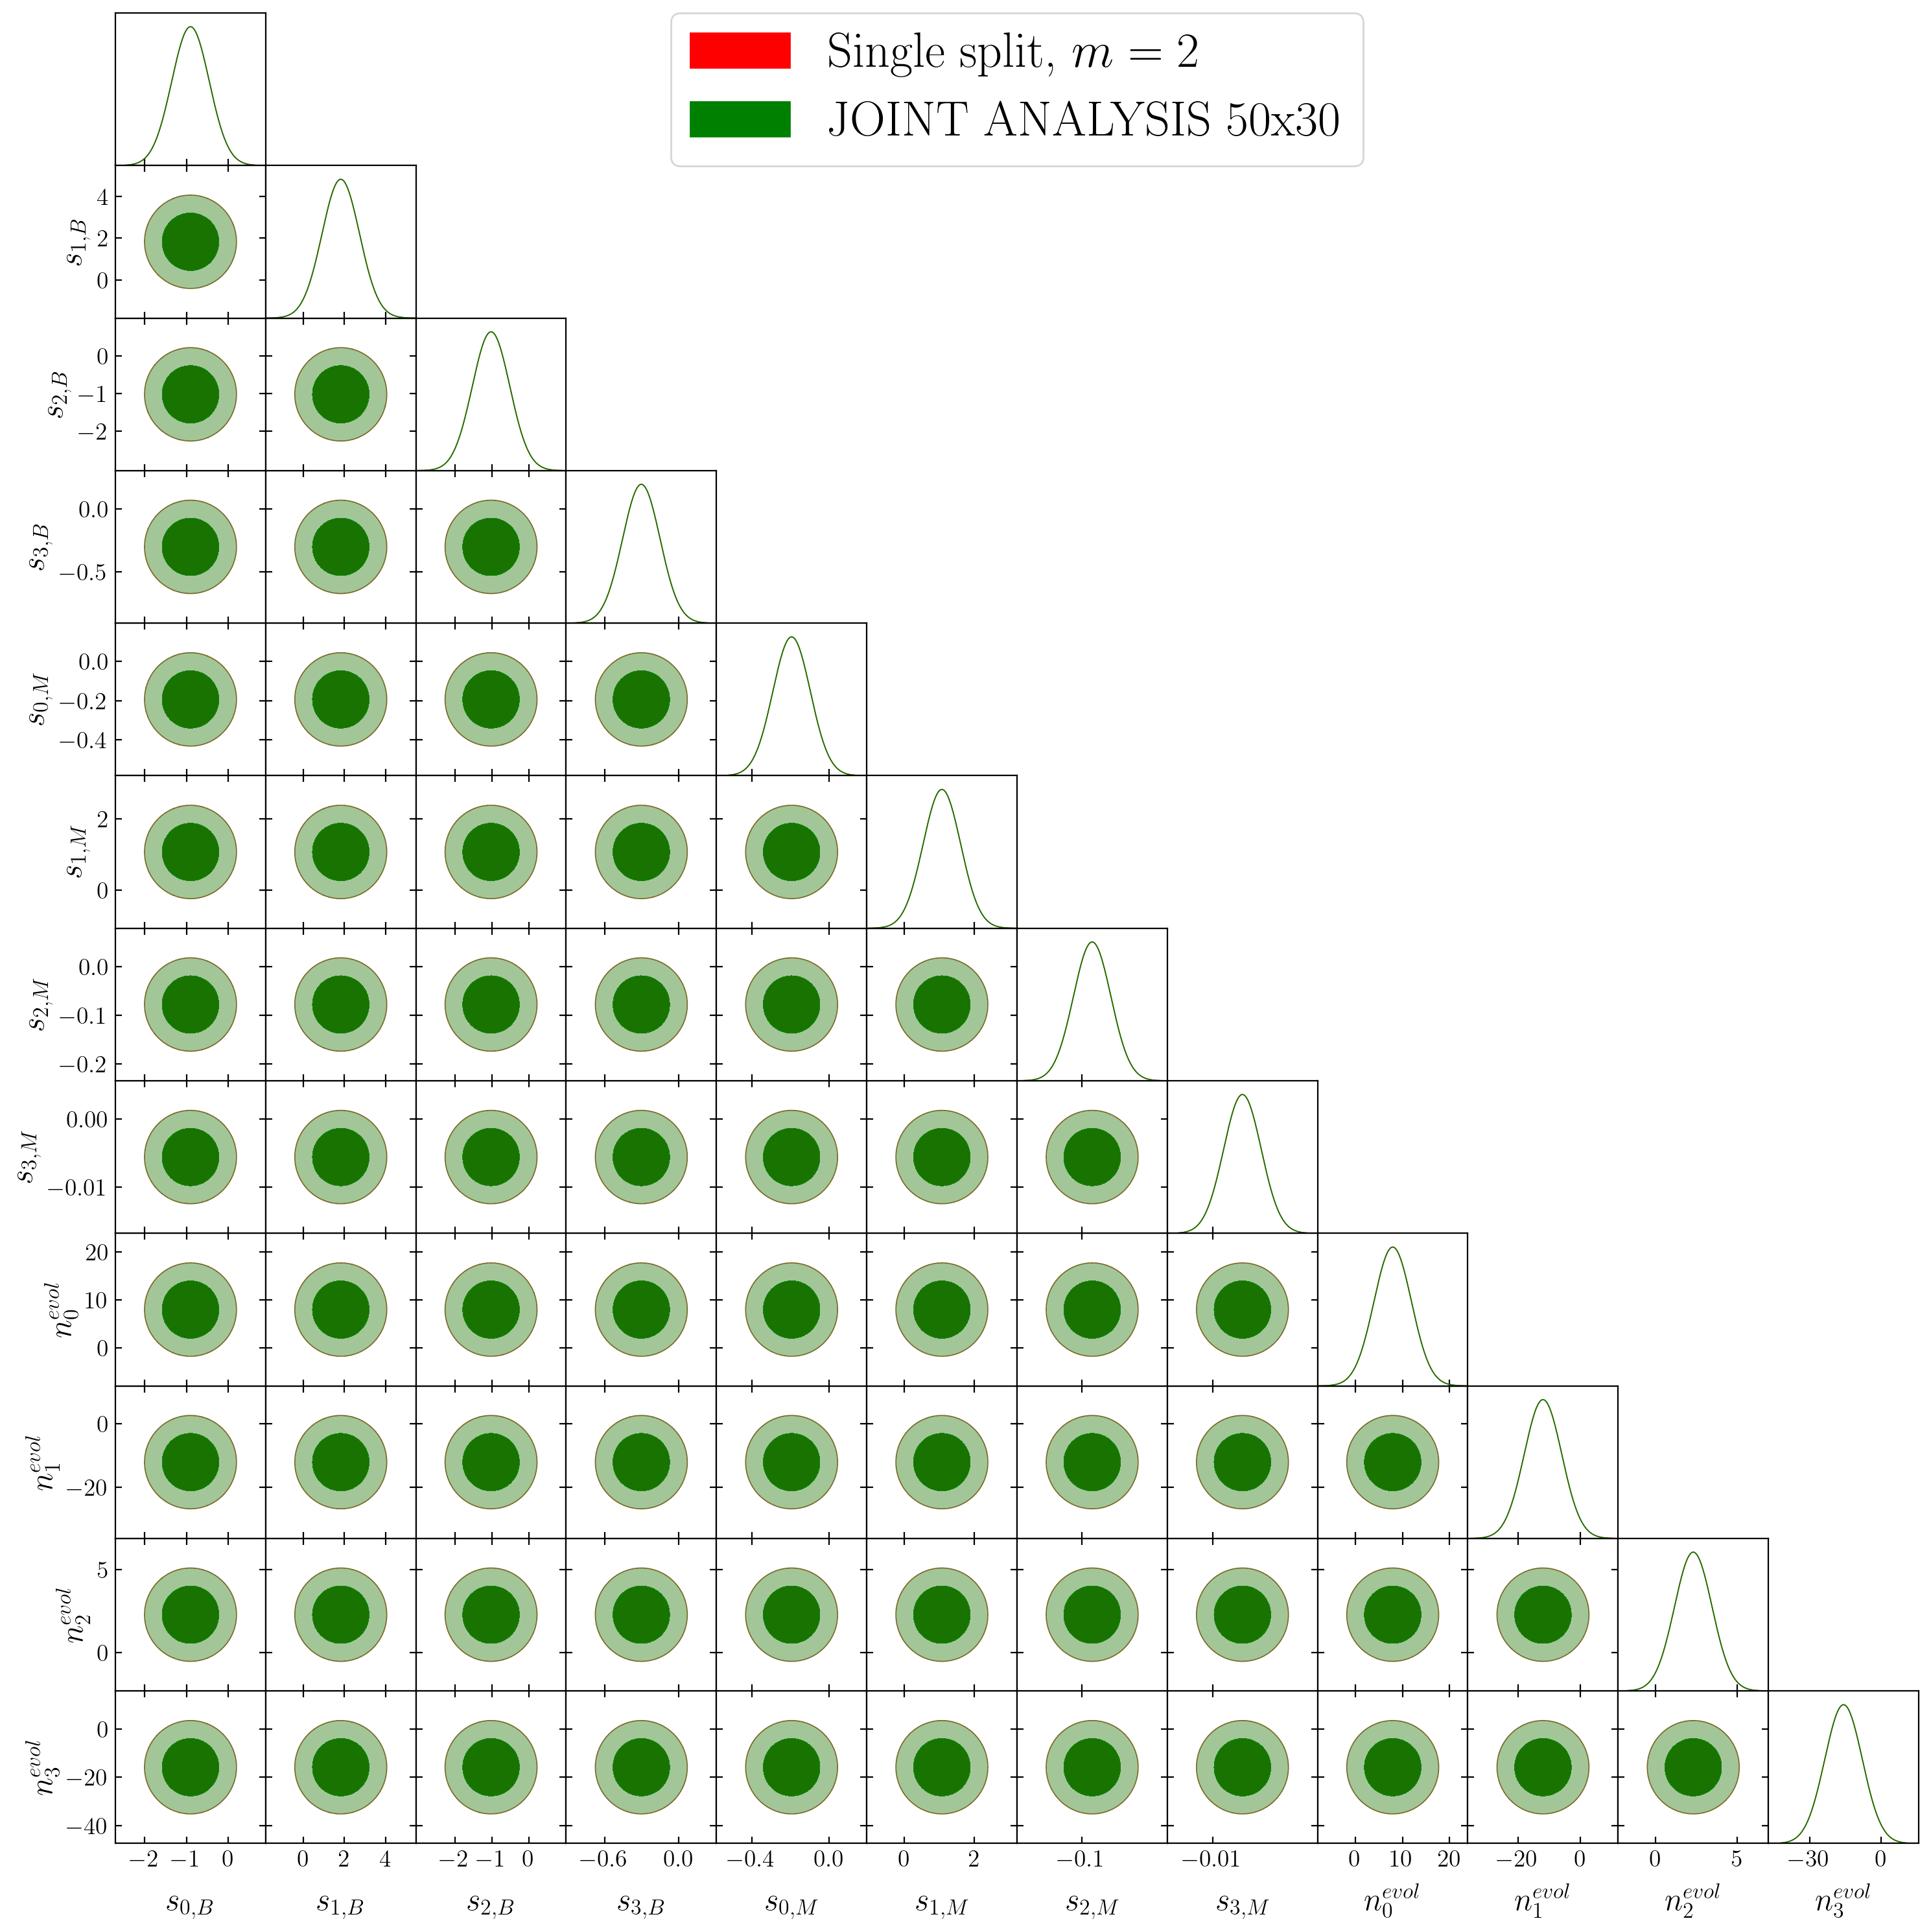

In [244]:
# Triangle plot

mean_joint = params_fid_
mean_50 = params_fid_50[:-7]

sB_names = ['s'+str(int(i))+'B' for i in np.arange(len(sB_4fit50))]
sM_names = ['s'+str(int(i))+'M' for i in np.arange(len(sM_4fit))]

sB_labels=[r's_{'+str(i)+r',B}' for i in np.arange(len(sB_4fit50))]
sM_labels=[r's_{'+str(i)+r',M}' for i in np.arange(len(sM_4fit))]

num_names = ['n'+str(int(i)) for i in np.arange(len(num_fit))]

num_labels=[r'n_{'+str(i)+r'}^{evol}' for i in np.arange(len(num_fit))]

param_names = sB_names + sM_names + num_names 
labels = sB_labels + sM_labels + num_labels 

GaussDist_joint_sbias_nevol_fit_ = GaussianND(mean_joint, Sigma_Matrix_Joint50x30_[:-9,:-9], labels = labels, names = param_names)
GaussDist_50_sbias_nevol_fit = GaussianND(mean_50, Sigma_Matrix_50[:-7,:-7], labels = labels, names = param_names)

g = plots.get_subplot_plotter(width_inch=15)
g.settings.legend_frame = True
g.settings.alpha_filled_add=0.9
g.settings.legend_fontsize=32
g.settings.axes_fontsize=18
g.settings.axes_labelsize=22
g.settings.axis_tick_max_labels=6

g.triangle_plot([GaussDist_50_sbias_nevol_fit, GaussDist_joint_sbias_nevol_fit_], param_names, 
                filled=True, 
                legend_labels=[r'Single split, $m=2$', r'JOINT ANALYSIS 50x30'],
                contour_colors=['red', 'green'])

In [245]:
np.shape(params_fid), np.shape(params_fid_30)

((25,), (19,))

In [246]:
# Delete rows and columns alien to the 30x70 split

nind = list(range(0,4))

Sigma_Matrix_Joint50x30_ = Sigma_Matrix_Joint50x30

Sigma_Matrix_Joint50x30_ = np.delete(arr=Sigma_Matrix_Joint50x30_, obj=nind, axis=0)
Sigma_Matrix_Joint50x30_ = np.delete(arr=Sigma_Matrix_Joint50x30_, obj=nind, axis=1)

np.shape(Sigma_Matrix_Joint50x30_)

(21, 21)

In [247]:
# Delete elements of params_fid

params_fid_ = params_fid[:-9]

params_fid_ = np.delete(arr=params_fid_, obj=nind, axis=0)

np.shape(params_fid_)

(12,)

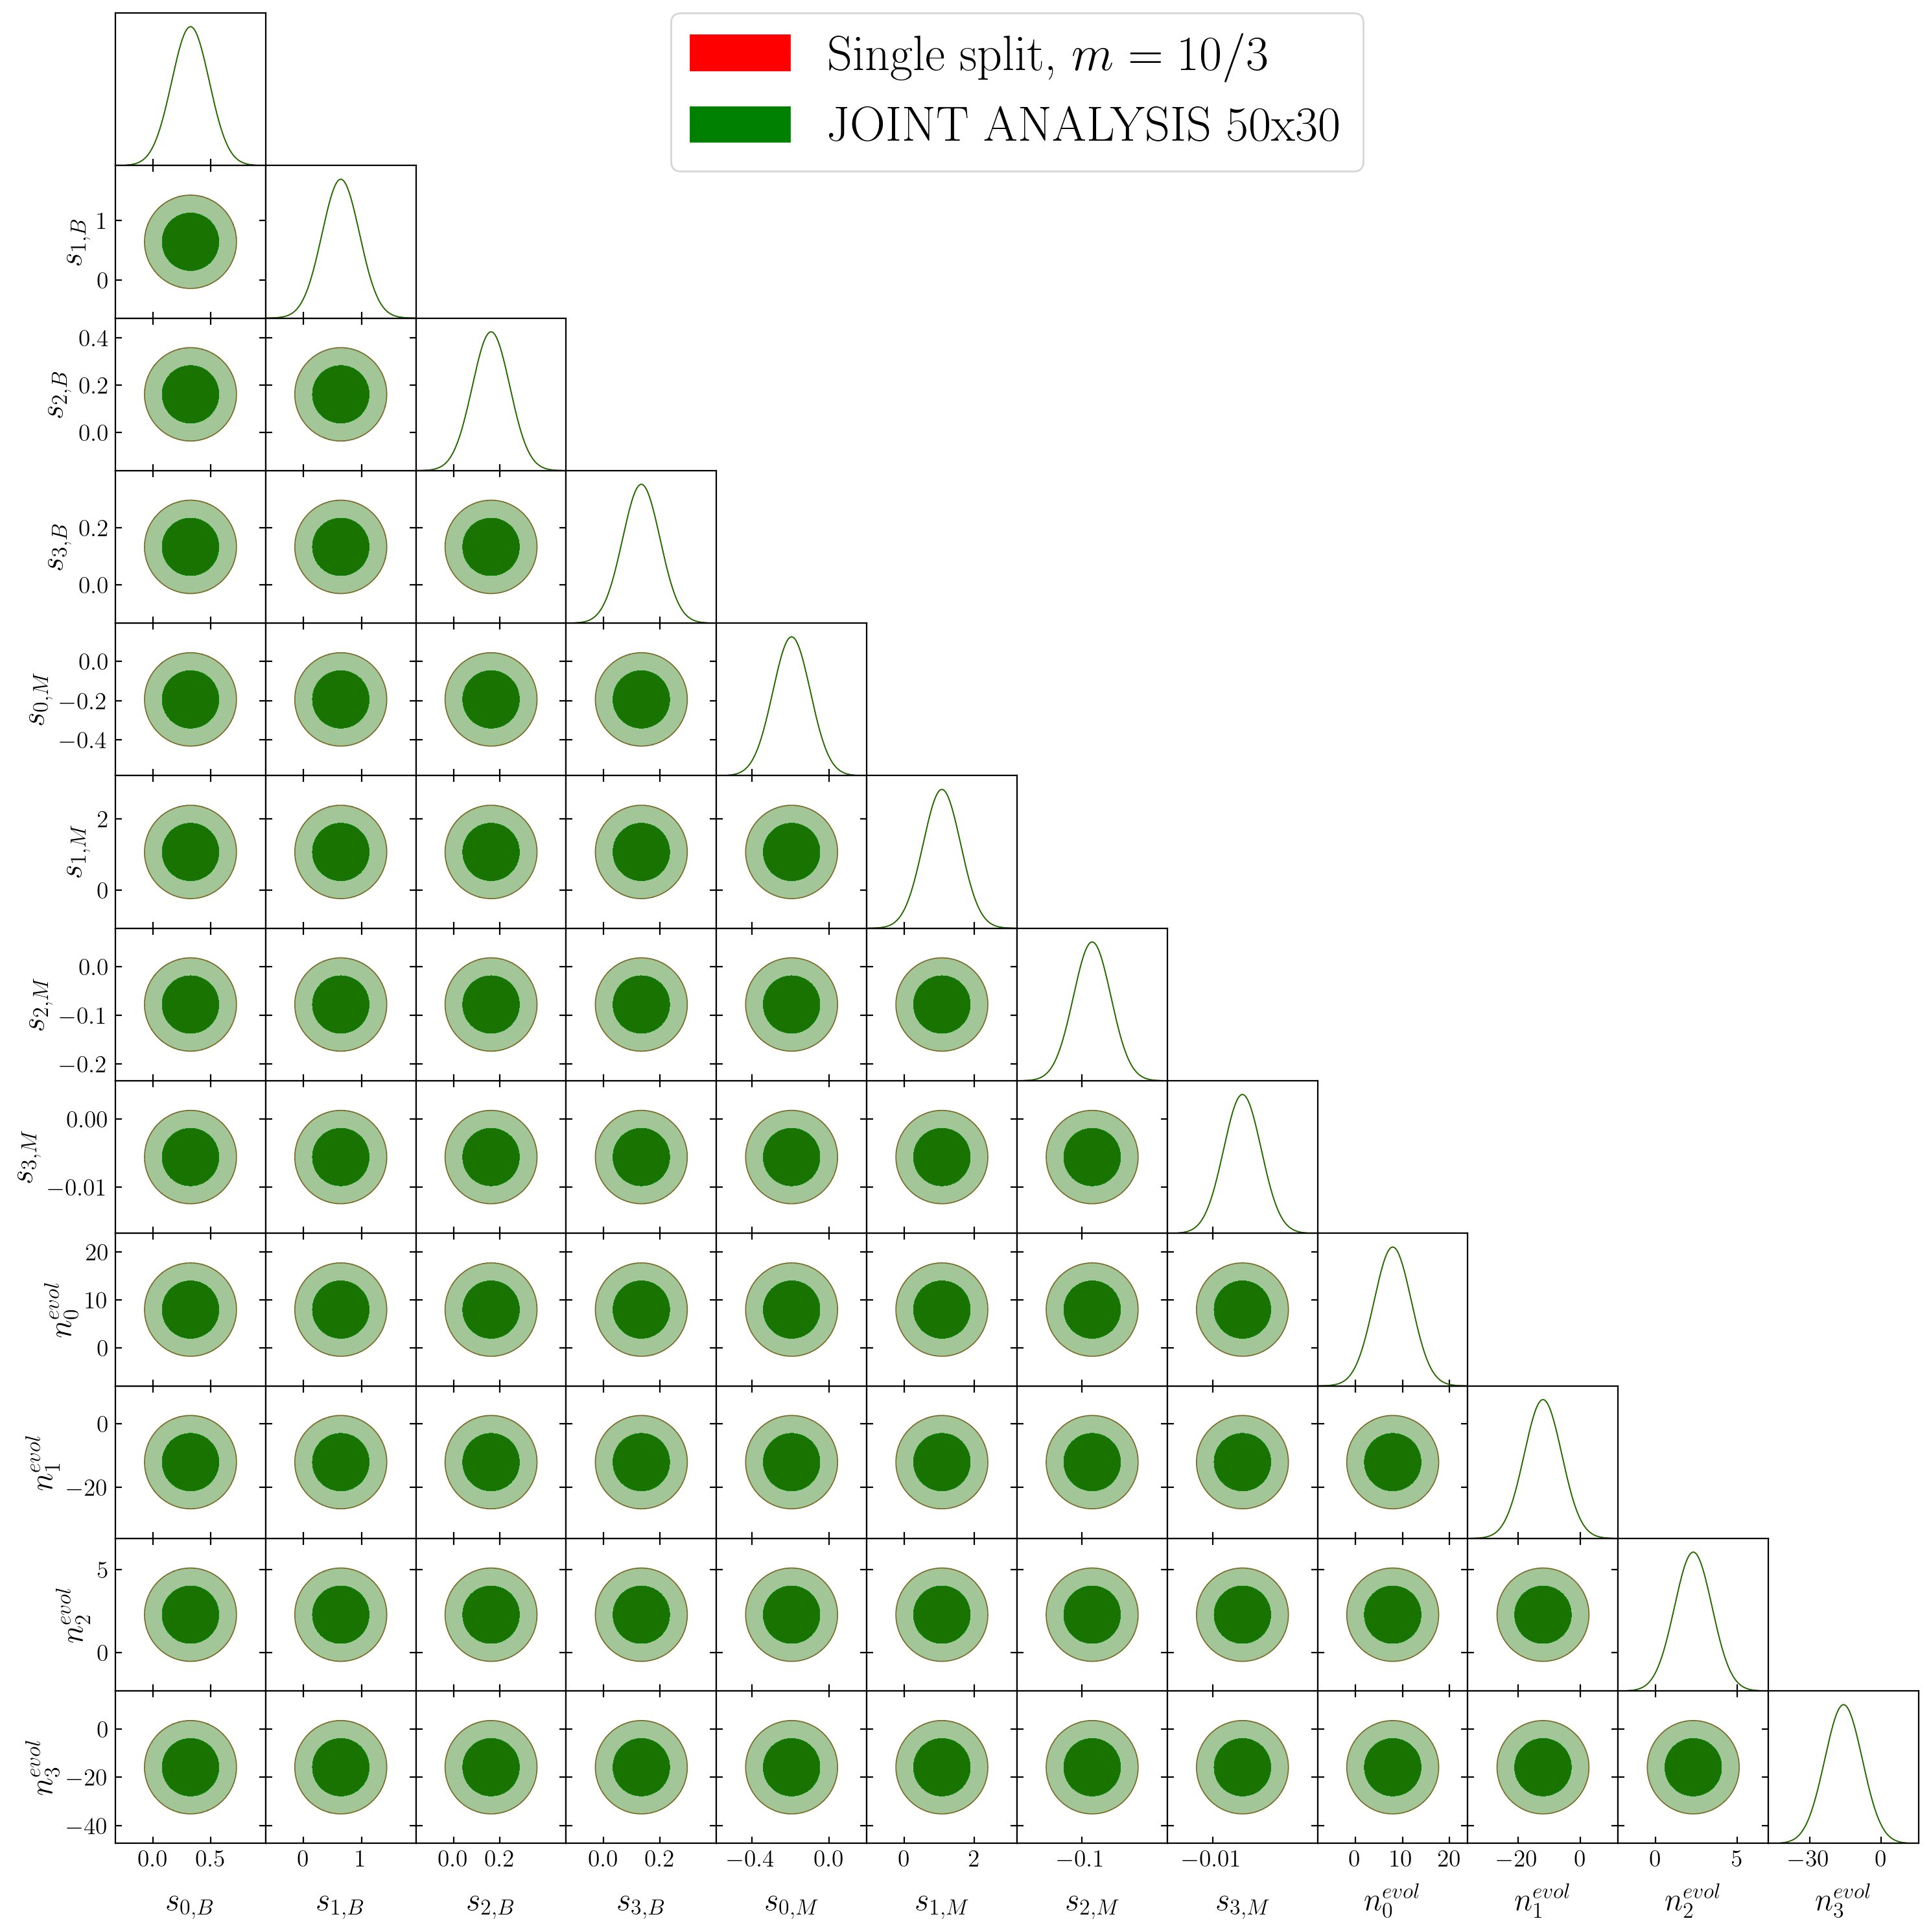

In [248]:
# Triangle plot

mean_joint = params_fid_
mean_30 = params_fid_30[:-7]

sB_names = ['s'+str(int(i))+'B' for i in np.arange(len(sB_4fit50))]
sM_names = ['s'+str(int(i))+'M' for i in np.arange(len(sM_4fit))]

sB_labels=[r's_{'+str(i)+r',B}' for i in np.arange(len(sB_4fit50))]
sM_labels=[r's_{'+str(i)+r',M}' for i in np.arange(len(sM_4fit))]

num_names = ['n'+str(int(i)) for i in np.arange(len(num_fit))]

num_labels=[r'n_{'+str(i)+r'}^{evol}' for i in np.arange(len(num_fit))]

param_names = sB_names + sM_names + num_names 
labels = sB_labels + sM_labels + num_labels 

GaussDist_joint_sbias_nevol_fit_ = GaussianND(mean_joint, Sigma_Matrix_Joint50x30_[:-9,:-9], labels = labels, names = param_names)
GaussDist_30_sbias_nevol_fit = GaussianND(mean_30, Sigma_Matrix_30[:-7,:-7], labels = labels, names = param_names)

g = plots.get_subplot_plotter(width_inch=15)
g.settings.legend_frame = True
g.settings.alpha_filled_add=0.9
g.settings.legend_fontsize=32
g.settings.axes_fontsize=18
g.settings.axes_labelsize=22
g.settings.axis_tick_max_labels=6

g.triangle_plot([GaussDist_30_sbias_nevol_fit, GaussDist_joint_sbias_nevol_fit_], param_names, 
                filled=True, 
                legend_labels=[r'Single split, $m=10/3$', r'JOINT ANALYSIS 50x30'],
                contour_colors=['red', 'green'])

In [249]:
np.shape(Sigma_Matrix_Joint50x30), np.shape(Sigma_Matrix_50)

((25, 25), (19, 19))

In [250]:
# Delete rows and columns alien to the 50x50 split

nind = list(range(0,16)) + list(range(18,20))

Sigma_Matrix_Joint50x30_ = Sigma_Matrix_Joint50x30

Sigma_Matrix_Joint50x30_ = np.delete(arr=Sigma_Matrix_Joint50x30_, obj=nind, axis=0)
Sigma_Matrix_Joint50x30_ = np.delete(arr=Sigma_Matrix_Joint50x30_, obj=nind, axis=1)

np.shape(Sigma_Matrix_Joint50x30_)

(7, 7)

In [251]:
# Delete elements of params_fid

params_fid_ = params_fid

params_fid_ = np.delete(arr=params_fid_, obj=nind, axis=0)

np.shape(params_fid_)

(7,)

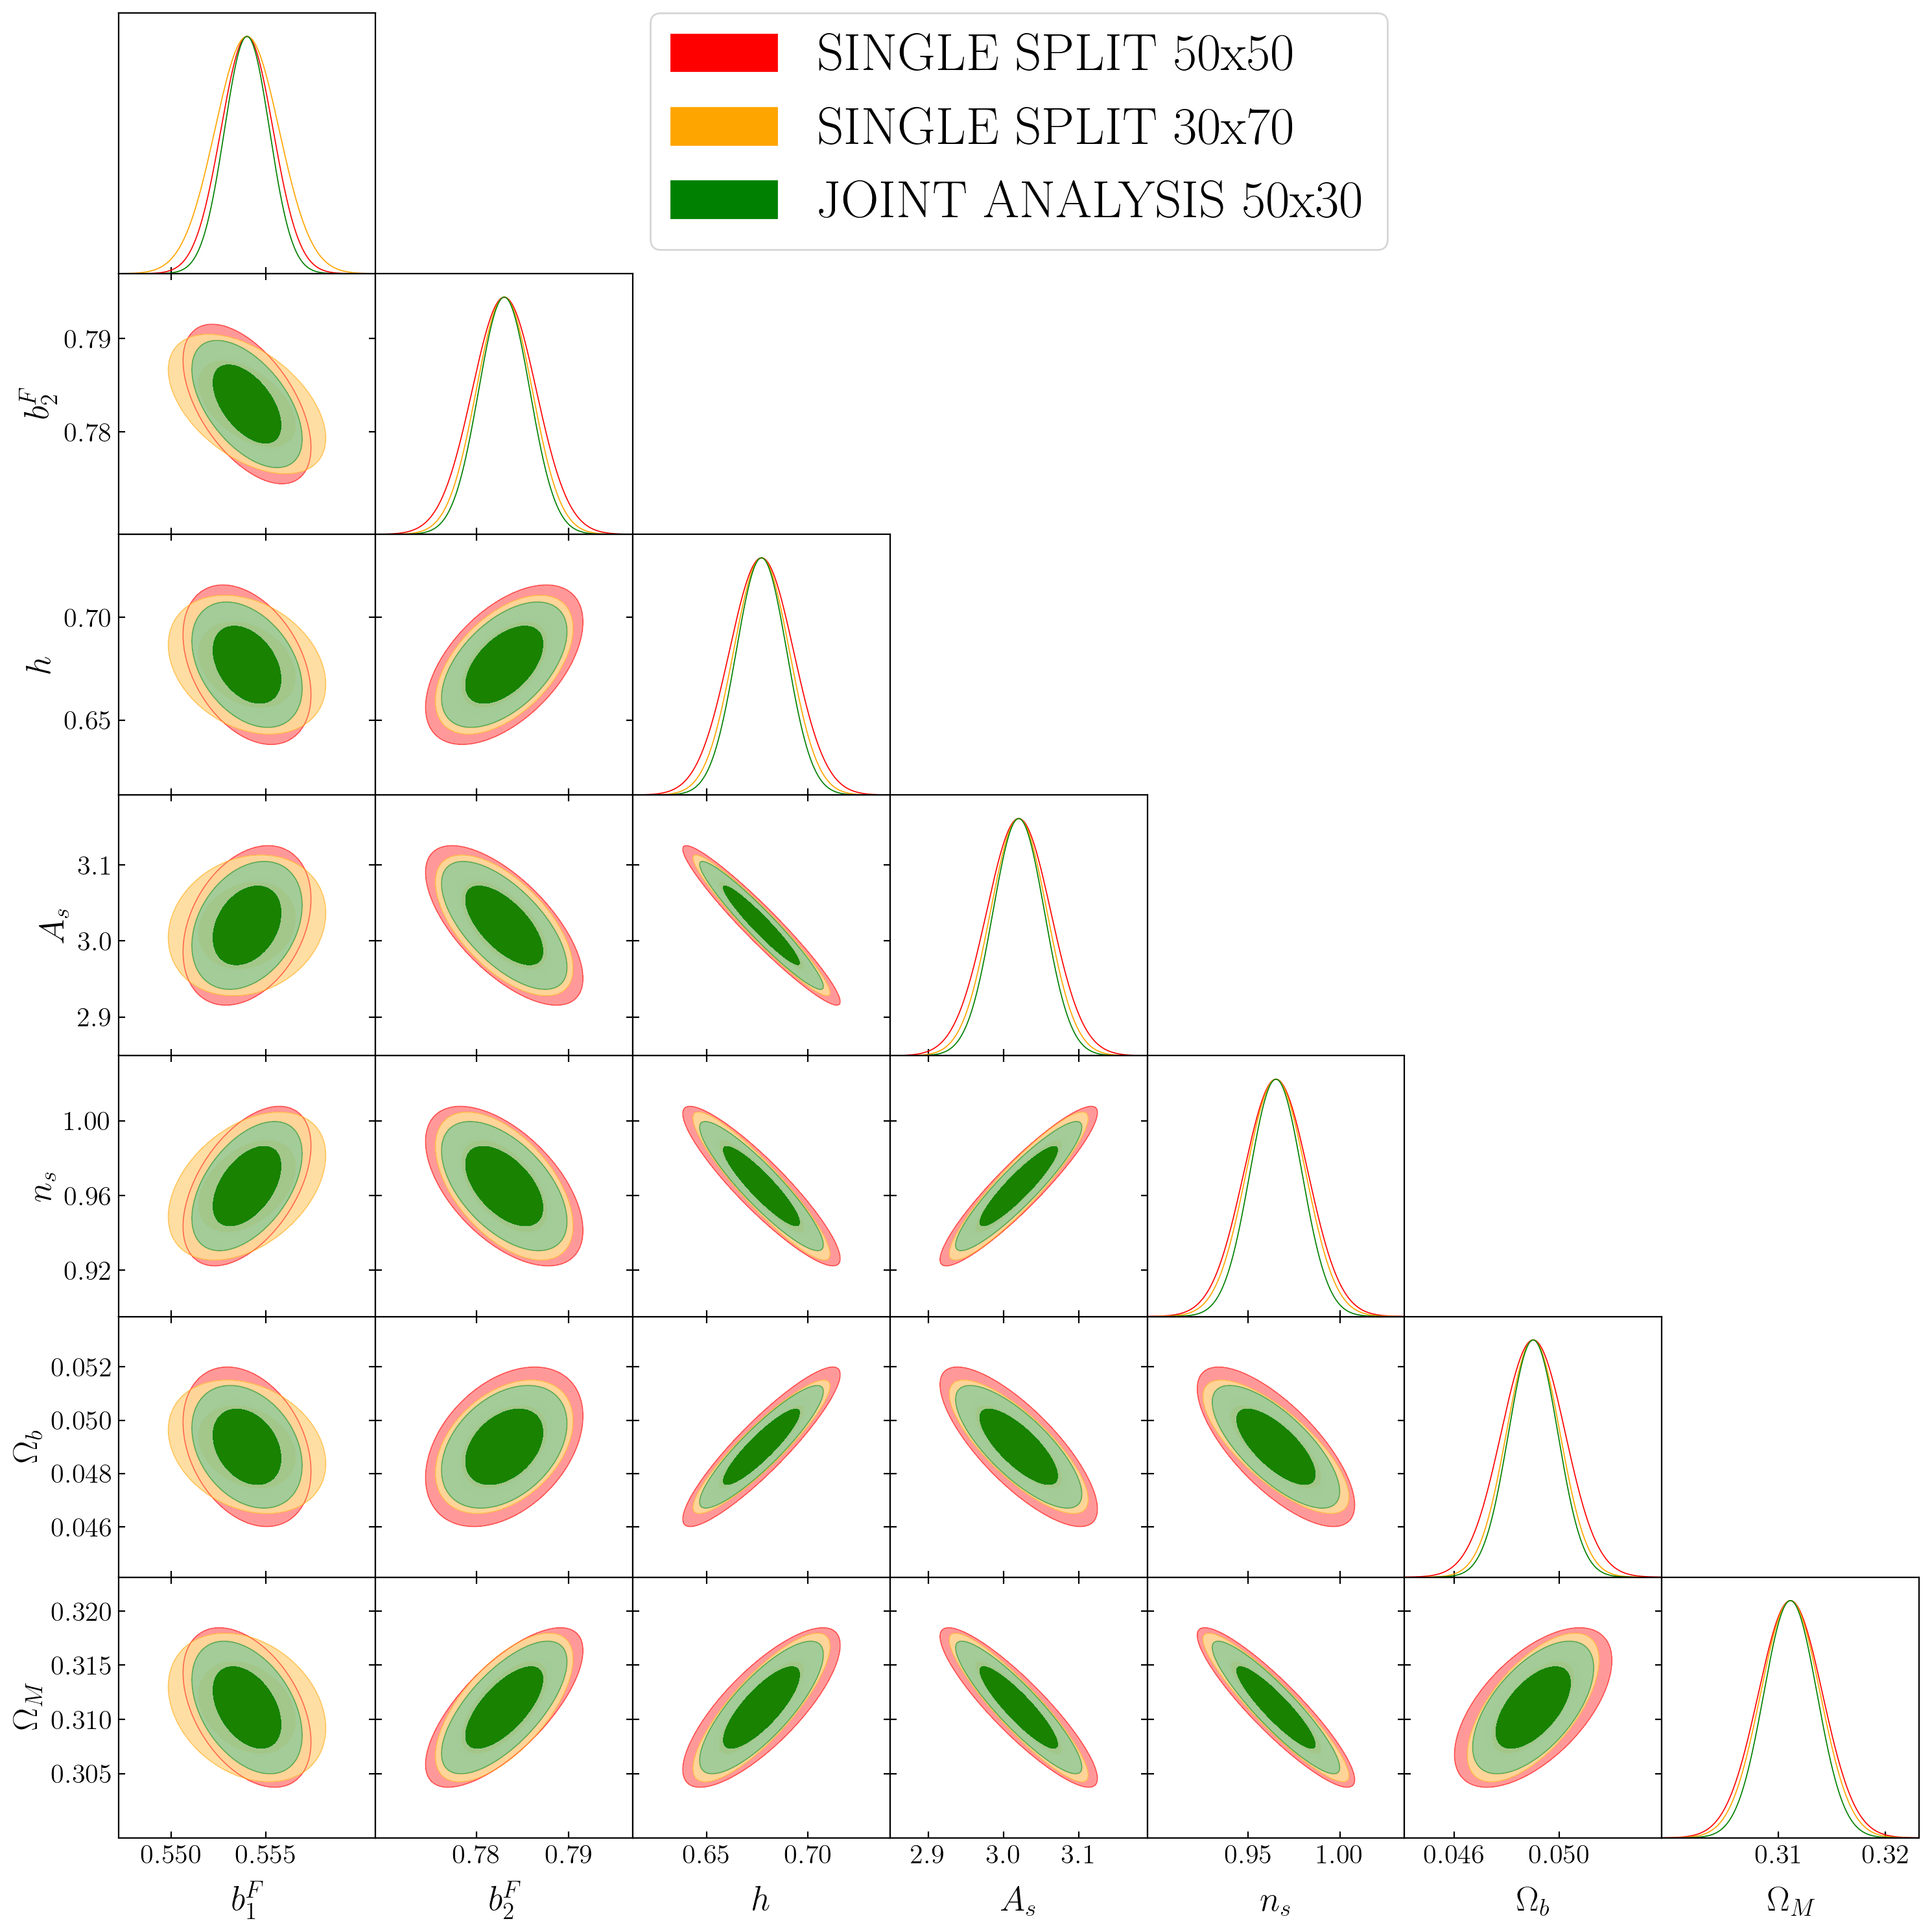

In [252]:
# Triangle plot: GALAXY BIAS AND COSMIC PARAMETERS

mean_50 = params_fid_

gbias_names = ['b1F_m1', 'b2F_m1']
cosmic_names = ['h', 'As', 'ns', 'Ob', 'OM']

gbias_labels = [r'b_1^{F}', r'b_2^{F}']
cosmic_labels = [r'h', r'A_s', r'n_s', r'\Omega_b', r'\Omega_M']

param_names = gbias_names + cosmic_names
labels = gbias_labels + cosmic_labels

GaussDist_gbias_cosmic_fit = GaussianND(mean_50, Sigma_Matrix_Joint50x30_, labels = labels, names = param_names)
GaussDist_gbias_cosmic_fit_50 = GaussianND(mean_50, Sigma_Matrix_50[12:, 12:], labels = labels, names = param_names)
GaussDist_gbias_cosmic_fit_30 = GaussianND(mean_50, Sigma_Matrix_30[12:, 12:], labels = labels, names = param_names)


g = plots.get_subplot_plotter(width_inch=15)
g.settings.legend_frame = True
g.settings.alpha_filled_add=0.9
g.settings.legend_fontsize=32
g.settings.axes_fontsize=18
g.settings.axes_labelsize=22
g.settings.axis_tick_max_labels=6

g.triangle_plot([GaussDist_gbias_cosmic_fit_50, GaussDist_gbias_cosmic_fit_30, GaussDist_gbias_cosmic_fit], param_names, 
                filled=True, 
                legend_labels=['SINGLE SPLIT 50x50', 'SINGLE SPLIT 30x70','JOINT ANALYSIS 50x30'],
                contour_colors=['red', 'orange', 'green'])

# Comparing 1 vs 2 vs 2x2 populations

In [253]:
print(' ... COSMIC PARAMETERS ... \n')
print('-'*150,'\n')
print('Cosmic pars with b pop only (50x50) = ', cosmic50x50_bright,)
print('Cosmic pars with b pop only (30x70) = ', cosmic30x70_bright,'\n')
print('Cosmic pars with f pop only (50x50) = ', cosmic50x50_faint,)
print('Cosmic pars with f pop only (30x70) = ', cosmic30x70_faint,'\n')
print('Cosmic pars with b pop only (Joint) = ', cosmicjoint_bright)
print('Cosmic pars with f pop only (Joint) = ', cosmicjoint_faint, '\n')
print('Cosmic pars with b (Joint vs 50x50 %) = ', (1-cosmicjoint_bright/cosmic50x50_bright)*100)
print('Cosmic pars with b (Joint vs 30x70 %) = ', (1-cosmicjoint_bright/cosmic30x70_bright)*100, '\n')
print('Cosmic pars with f (Joint vs 50x50 %) = ', (1-cosmicjoint_faint/cosmic50x50_faint)*100)
print('Cosmic pars with f (Joint vs 30x70 %) = ', (1-cosmicjoint_faint/cosmic30x70_faint)*100, '\n')
print('-'*150,'\n')
print('Cosmic pars with 2 pops (50x50) = ', cosmic50x50)
print('Cosmic pars with 2 pops (30x70) = ', cosmic30x70)
print('Cosmic pars with 2 pops (Joint) = ', cosmicjoint, '\n')
print('Cosmic pars with 2 pops (Joint vs 50x50 %) = ', (1-cosmicjoint/cosmic50x50)*100)
print('Cosmic pars with 2 pops (Joint vs 30x70 %) = ', (1-cosmicjoint/cosmic30x70)*100, '\n')
print('-'*150,'\n')
print('Cosmic pars with b pop vs 2 pops (50x50 %) = ', (1-cosmic50x50/cosmic50x50_bright)*100)
print('Cosmic pars with f pop vs 2 pops (50x50 %) = ', (1-cosmic50x50/cosmic50x50_faint)*100)
print('Cosmic pars with b pop vs 2 pops (30x70 %) = ', (1-cosmic30x70/cosmic30x70_bright)*100)
print('Cosmic pars with f pop vs 2 pops (30x70 %) = ', (1-cosmic30x70/cosmic30x70_faint)*100, '\n')
print('Cosmic pars with b pop vs 2 pops (Joint %) = ', (1-cosmicjoint/cosmicjoint_bright)*100)
print('Cosmic pars with f pop vs 2 pops (Joint %) = ', (1-cosmicjoint/cosmicjoint_faint)*100, '\n')





 ... COSMIC PARAMETERS ... 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

Cosmic pars with b pop only (50x50) =  [1.84615358 1.13214617 1.68993266 1.74452575 0.89027757]
Cosmic pars with b pop only (30x70) =  [1.91962638 1.17540912 1.77251154 1.80273113 0.92633778] 

Cosmic pars with f pop only (50x50) =  [2.3438039  1.4171619  1.8093616  2.49724144 0.9664905 ]
Cosmic pars with f pop only (30x70) =  [2.03985112 1.2501404  1.67769746 2.08885639 0.89995893] 

Cosmic pars with b pop only (Joint) =  [1.57862828 0.99428492 1.42026256 1.51191321 0.7605842 ]
Cosmic pars with f pop only (Joint) =  [1.84188555 1.13643791 1.46491187 1.91989557 0.80318947] 

Cosmic pars with b (Joint vs 50x50 %) =  [14.4909559  12.17698361 15.95744676 13.33385533 14.56774608]
Cosmic pars with b (Joint vs 30x70 %) =  [17.76377424 15.40946022 19.87287383 16.13207388 17.89342775] 

Cosmic pars with f (Joint vs

In [254]:
print('\n ... GALAXY BIAS ... \n')
print('-'*150, '\n')
print('Gbias pars with b pop only (50x50) = ', gbias50x50_bright,)
print('Gbias pars with b pop only (30x70) = ', gbias30x70_bright,'\n')
print('Gbias pars with f pop only (50x50) = ', gbias50x50_faint,)
print('Gbias pars with f pop only (30x70) = ', gbias30x70_faint,'\n')
print('Gbias 50x50 pars with b pop only (Joint) = ', gbias50joint_bright)
print('Gbias 30x70 pars with b pop only (Joint) = ', gbias30joint_bright)
print('Gbias 50x50 pars with f pop only (Joint) = ', gbias50joint_faint)
print('Gbias 30x70 pars with f pop only (Joint) = ', gbias30joint_faint, '\n')
print('Gbias pars with b (Joint vs 50x50 %) = ', (1-gbias50joint_bright/gbias50x50_bright)*100)
print('Gbias pars with b (Joint vs 30x70 %) = ', (1-gbias30joint_bright/gbias30x70_bright)*100, '\n')
print('Gbias pars with f (Joint vs 50x50 %) = ', (1-gbias50joint_faint/gbias50x50_faint)*100)
print('Gbias pars with f (Joint vs 30x70 %) = ', (1-gbias30joint_faint/gbias30x70_faint)*100, '\n')
print('-'*150, '\n')
print('Gbias pars with 2 pops (50x50) = ', gbias50x50)
print('Gbias pars with 2 pops (30x70) = ', gbias30x70)
print('Gbias pars 50x50 with 2 pops (Joint) = ', gbias50joint)
print('Gbias pars 30x70 with 2 pops (Joint) = ', gbias30joint, '\n')
print('Gbias pars with 2 pops (Joint vs 50x50 %) = ', (1-gbias50joint/gbias50x50)*100)
print('Gbias pars with 2 pops (Joint vs 30x70 %) = ', (1-gbias30joint/gbias30x70)*100, '\n')
print('-'*150, '\n')
print('Gbias pars with b pop vs 2 pops (50x50 %) = ', (1-gbias50x50[:2]/gbias50x50_bright)*100)
print('Gbias pars with f pop vs 2 pops (50x50 %) = ', (1-gbias50x50[2:]/gbias50x50_faint)*100)
print('Gbias pars with b pop vs 2 pops (30x70 %) = ', (1-gbias30x70[:2]/gbias30x70_bright)*100)
print('Gbias pars with f pop vs 2 pops (30x70 %) = ', (1-gbias30x70[2:]/gbias30x70_faint)*100, '\n')
print('Gbias pars with b pop vs 2 pops (Joint %) = ', (1-gbias50joint[:2]/gbias50joint_bright)*100)
print('Gbias pars with f pop vs 2 pops (Joint %) = ', (1-gbias50joint[2:]/gbias50joint_faint)*100, '\n')



 ... GALAXY BIAS ... 

------------------------------------------------------------------------------------------------------------------------------------------------------ 

Gbias pars with b pop only (50x50) =  [0.88251079 0.56813654]
Gbias pars with b pop only (30x70) =  [1.17898709 0.73559427] 

Gbias pars with f pop only (50x50) =  [0.24867974 0.44495619]
Gbias pars with f pop only (30x70) =  [0.3060357 0.389084 ] 

Gbias 50x50 pars with b pop only (Joint) =  [0.75712393 0.48601852]
Gbias 30x70 pars with b pop only (Joint) =  [0.95328614 0.61368466]
Gbias 50x50 pars with f pop only (Joint) =  [0.21440306 0.35470457]
Gbias 30x70 pars with f pop only (Joint) =  [0.26551231 0.35881853] 

Gbias pars with b (Joint vs 50x50 %) =  [14.20797    14.45392371]
Gbias pars with b (Joint vs 30x70 %) =  [19.1436326  16.57294104] 

Gbias pars with f (Joint vs 50x50 %) =  [13.78346087 20.28325853]
Gbias pars with f (Joint vs 30x70 %) =  [13.241395    7.77864755] 

-------------------------------